In [1]:
import numpy as np
import cv2
from PIL import Image
import socket
import pickle
# import shutil
# from skimage import io

class State:
    def __init__(self, state_data):
        self.state_data = np.asarray(state_data)
  
    def process_state(self):
        pass
  
    def get_batch_tensor(self):
        holder = np.asarray(self.state_data)
        holder.reshape((1, ) + holder.shape)
        return holder
  
    def get_individual_tensor(self):
        return np.asarray(self.state_data)

    def get_shape(self):
        return self.state_data.shape
  
    def display(self):
        print(self.state_data)
        
# ------------------------------------

class Frame(State):
    def __init__(self, state_data, crop_factor=None, destination_size=None, vert_cent=0.5):
        State.__init__(self, state_data)
#         self.state_data = self.process_state(crop_factor, vert_cent, destination_shape)
        self.state_data = self.process_state([0.7, 1.0], 0.7, (128,64))
  
    def process_state(self, crop_factor, vert_cent, destination_shape):
        """
        Does all the processing of the frame using the helper functions
        """
        frame = self.crop_frame(self.state_data, crop_factor, vert_cent)
        frame = self.normalise_frame(frame)
        frame = self.gray_scale(frame) # cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        assert len(frame.shape) == 2
        frame = self.downsample_frame(frame, destination_shape)
        return frame

  
    def gray_scale(self, frame, gray_scale_factor=[0.3, 0.3, 0.3]):
        frame = np.dot(frame, np.asarray(gray_scale_factor))
        return frame

    def normalise_frame(self, frame):
        frame = frame.astype('float32') / 255.0
        return frame
  
    def downsample_frame(self, frame, destination_shape):
        """
        downsamples the frame. decreases the resolution
        """
        frame = cv2.resize(np.asarray(frame), dsize=destination_shape, interpolation=cv2.INTER_CUBIC)
        return frame
  
    def crop_frame(self, frame, crop_factor, vert_cent):
        """
        input is the frame
        output is the cropped frame
        crop_factor is the ratio at which you want to crop the height and width(0.8, 0.8)
        cent is the ratio at which the centre of the cropped frame should be
        """
        if crop_factor is None:
          return frame
    
        height_factor = int((crop_factor[0]*frame.shape[0]) // 2)
        width_factor = int((crop_factor[1]*frame.shape[1]) // 2)
        vert_cent = int(frame.shape[0]*vert_cent)
        width_cent = int(frame.shape[1]*0.5)

        frame = frame[vert_cent - height_factor: vert_cent + height_factor, 
                      width_cent - width_factor: width_cent + width_factor]
        return frame

# ------------------------------------
class DataBuffer:
    """
    Keeps track of n latest states 
    """
  
    def __init__(self, size=1):
        self.buffer = []
        self.size = size

    def get_input_tensor(self, in_batch=True):
        arr = np.array(self.buffer)
        if self.size == 1 or in_batch:
            return arr
        else:
            return arr.reshape((1, ) + arr.shape)
    
    def get_input_shape(self):
        return np.asarray(self.current_state[0]).shape

    def assign_to_buffer(self, state):
        if isinstance(state, State):
            state = state.get_individual_tensor()
        if len(self.buffer) >= self.size:
            self.buffer.pop(0)
        self.buffer.append(state)
        
# ------------------------------------

class FrameBuffer(DataBuffer):
    def __init__(self, size = 4):
        DataBuffer.__init__(self, size=size)
    
    def get_input_shape(self):
        return self.get_input_tensor().shape
  
    def get_input_tensor(self, in_batch=True):
        temp = np.array(self.buffer)
        return  temp.transpose((1, 2, 0))
    
    def assign_to_buffer(self, state):
        if isinstance(state, State):
            state = state.get_individual_tensor()
        # if buffer not initialised
        if len(self.buffer) == 0:
            self.buffer = [state]
            return

        if len(self.buffer) >= self.size:
            self.buffer.pop(0)
        
        self.buffer.append(state)

In [2]:
from pathlib import Path
import os
import os.path
import random

class EnvironmentWrapper:
    
    def __init__(self):
        
        
        # initialise comms with the simulator here
        self.sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM) # initialise the socket
        # connect to localhost, port 2345 
        self.sock.bind(("127.0.0.1", 4444))
        self.sock.listen(1)
        print("Waiting to connect to Simulator...")
        self.clientsocket, _ = self.sock.accept() # connect to simulator [BLOCKING]
        print("Connected to simulator!")
        # =========================================
        
        
        # initialising frame buffer
        self.buffer_size = 4 # could change this 
        
         # this is the FrameBuffer that keeps track of the latest frames.
         #initialising the frame buffer by just giving it multiple copies of the same starting frame
        # =========================================
        
        self.current_state = None
        
        self.current_buffer = None
        
        self.prev_dist = 0
        
        self.time_steps = 0
        
        self.done = False
        
        self.max_time_steps_per_episode = 500 #change this based on the enviorment
        
        # initialise buffer
        self.current_buffer = FrameBuffer(size = self.buffer_size)
        
        # =========================================
        
        
        # Create target directory if it doesn't exist
       
        parent_path = os.path.abspath(os.path.join("", os.pardir))
        self.final_path = parent_path + "/simulation/Screenshots"
        if not os.path.exists(self.final_path):
            os.mkdir(self.final_path)
            print("Directory " , self.final_path,  " Created ")
        else:    
            print("Directory " , self.final_path,  " already exists")
            
        
        # Save scr1 to Screenshots if it doesn't already exist
        if not os.path.exists(self.final_path + '/scr1.png'):
            scr1 = Image.open(self.parent_path + '/simulation/scr1.png', 'r')
            scr1.save(self.final_path + "/scr1.png", "PNG")
        
        # reset actually initializes self.current_state, self.current_buffer etc.
        self.reset()
        
        
        
        self.action_space = ['as', 'ar', 'al', 'ds', 'dr', 'dl', 'bs', 'br', 'bl']
        
    
    
    def get_input_shape(self):
        """
        returns the input shape for the input layer of the network
        """
        return self.current_buffer.get_input_shape()
    
#     def get_state_shape(self):
#         """
#         not to be confused with the input shape. This is the shape of individual state (the shape of an individual processed shape of the environment)
#         """
#         return self.current_state
    
    def get_random_action(self):
        """
        returns a random action to be taken. [steering, acceleration, brake]
        """
        return random.choice(self.action_space)
    
    def get_action_at_index(self, index):
        return self.action_space[index]
    
    def get_num_action_space(self):
        """
        returns the number of permuations of valide actions. For Eg. [steer left, accelerate and no brake] is ONE action
        [steer right, accelerate and brake] is invalid as we cannot accelerate and brake at the same time.
        there are 9 possible actions I think?
        """
        return len(self.action_space)
    
    def reset(self):
        """
        resets the environment. self.done denotes whether the episode is done i.e. the car has crashed or we have stopped it
        """
        self.done = False
        self.time_steps = 0
        
        tup = self.step('reset') # initial step. Says don't do anything but send the first 4 frames and game info
        self.current_state, _, self.done = tup
        return self.current_state[0] # send only the frames
        
    
    def step(self, action):
        """ 
        does the action and returns the reward for that action along with the next state

        This function may get complicated as it has to interact with the car simulator throught sockets.
        """
        self.time_steps += 1
        
        if not self.is_done():
            # if the episode has not ended
            #=======================
            
            # send the action
            self.send_message(action)
            
            # wait for results from that action
            angle, distance, speed, self.done, frames_captured = self.get_game_stats() # blocking line
            # print("5: info:{0}, {1}, {2}, {3}, {4}".format(angle, distance, speed, self.done, frames_captured))
            
            
            # add images from path to current_buffer
            for i in range(1, frames_captured + 1):
                # each Frame object is then assigned to the FrameBuffer class in chronological order
                path = self.final_path + '/scr{0}.png'.format(i)
                self.current_buffer.assign_to_buffer(self.get_frame(path))
            
            buffer_tensor = self.current_buffer.get_input_tensor()
            # ========================================
            
            # calculate reward
            dist_delta = self.prev_dist - distance
            self.prev_dist = distance
            if abs(dist_delta) > 10:
                dist_delta = 5 # if there's too big a negative jump in the distance, the car has passed a checkpoint.
                # so, don't penalise it for that.
 
            reward = (dist_delta * 0.9) - (abs(angle) * 0.1)
            #=================
            
            # A buffer is a collection of consecutive frames that we feed to the NN. These frames are already processed.
            
            # the current state consists of all the information from the environment
            self.current_state = (buffer_tensor, angle, distance, speed)
            
            # this returns the state of the environment after the action has been completed, the reward for the action and if the episode ended.
            return self.current_state , reward, self.done
        else:
            return None
    
    def send_message(self, string):
        self.clientsocket.sendall(string.encode())
    
    def receive_message(self):
        data  = self.clientsocket.recv(256).decode()
        return data
    
    
    def is_done(self):
        """
        returns if the episode is finished
        """
        return self.done
        
    
    def get_frame(self, path: str) -> Frame:
        """
        communicates with the sim to get the latest state/frame. 
        returns a Frame object
        Get image from path then convert to np array then make a frame object
        """
        image = Image.open(path, 'r')
        image.load()
        np_data = np.asarray(image, dtype="float32" )
        return Frame(np_data)
    
    
    # def delete_screenshots(self, folder_path: str) -> None:
    #     """
    #     This method deletes the four screenshots saved in folder_path, along with the entire folder.
    #     Method must be called after all four screenshots are converted to Frame objects.
    #     """
    #     shutil.rmtree(folder_path)
    
    
    def get_current_state():
        """
        get the last n frames from the simulator (they might be stored in a folder by the simulator)
        and store them in a buffer and return them
        """
        return self.current_buff

    
    def get_game_stats(self):
        """
        returns a tuple of angle, distance from checkpoint and speed from the sim. Again requires comms with simulator.
        """
        # wait for info to arrive
        string = self.receive_message()
        
        # process string
        value_list = string.split(", ")
        angle = float(value_list[0])
        distance = float(value_list[1])
        speed = float(value_list[2])
        crashed_state = False
        if value_list[3] == '1':
            crashed_state = True
        frames_captured = int(value_list[4])
        # return tuple of values
        return angle, distance, speed, crashed_state, frames_captured
    
    def close(self):
        """
        in case we need to 'close' the environment
        """
        self.sock.close()
        self.clientsocket.close()


In [3]:
class Agent:
    def __init__(self, environment, network, run_only=False, eps_decay_rate=0.9975,max_exp_rate=1.0, min_exp_rate=0.05):
        self.env = environment # this should be the environment wrapper class
        
        if not run_only:
            self.exp_rate = max_exp_rate     # our network starts off with this exploration rate
        else:
            self.exp_rate = 0.0
        
        self.min_exp_rate = min_exp_rate  # have at least 0.01 exploration rate at all times
        
        self.decay_rate = eps_decay_rate   # decay the exploration rate at this rate
        
        self.time_step = 0     # keeps track of time steps
        
        self.network = network
    
    def take_action(self, current_state):
        # Implement the epsilon greedy strategy 
        result = random.random()                      # get a random number from 0 to 1 with linear distribution
        if result > self.get_exp_rate():              # if it falls over the explore rate, exploit
            # Get the action with the maximum q-value
            action = self.env.get_action_at_index(
                self.network.get_max_q_value_index(current_state, which_net = 'online', batch=False))  # exploit
        else:                                         # if it falls under the explore rate, explore
            action = self.env.get_random_action()          # explore (generate a random action from the environment class)
            
        self.increment_time_step()                    # increment time step as well as update the decay rate
        next_state, reward, done = self.env.step(action)# finally, take the action and record the reward
        
        return current_state, self.env.action_space.index(action), reward, next_state[0], done  # return an experience Tuple
        
    
    def reset_time_steps(self, i=0):
        self.timesteps = i
    
    def increment_time_step(self):
        self.time_step += 1
    
    def update_epsilon(self):
        if self.exp_rate > self.min_exp_rate:
            self.exp_rate = self.exp_rate * self.decay_rate
        else:
            self.exp_rate = self.min_exp_rate
    
    def get_exp_rate(self):
        return self.exp_rate

In [4]:
network_name = 'ddqn.h5'
from keras import layers, models
import tensorflow as tf
from keras.optimizers import Adam, RMSprop
class NetworkTracker:
    
    def __init__(self, environment, source=True, verbose = True): # pass in the environment which has input shape of the frame
        if source:
            self.model = models.load_model(network_name)
        else:
            self.model = self.define_model(environment)
        
        self.target_model = None
        self.clone_policy()
        
        self.verbose = 0
        if verbose:
            self.verbose = 1
              
    def define_model(self, env):
        model = models.Sequential() 
        model.add(layers.Conv2D(filters=10, 
                                kernel_size=(3,3), 
                                activation='relu', 
                                input_shape=env.get_input_shape())) # first layer takes input shape from the environment
        
        model.add(layers.MaxPool2D((3, 3)))
        
        model.add(layers.Conv2D(filters=20, kernel_size = (3, 3), strides=2, activation='relu'))

        model.add(layers.MaxPool2D(3, 3))
        
        model.add(layers.Flatten())
        
        model.add(layers.Dense(64, activation='relu'))
        
        model.add(layers.Dense(16, activation='relu'))
        
        model.add(layers.Dense(env.get_num_action_space(), activation='linear'))
        
        model.compile(optimizer=Adam(lr=0.0005), loss='mse')
        return model
    
    def get_q_values(self, states, which_net = 'online', batch = False):
        """
        get q values for specified states.
        INPUTS:
        1. states: the input states
        2. which_net: which net you want the prediction from
        3. batch: true if there are multiple states, false if there is only one state
        """
        if isinstance(states[0], DataBuffer): # if you have a list of buffers, convert them to numpy tensors
            states = np.asarray([i.get_input_tensor(in_batch=True) for i in states])
        
        if (not batch) and (not states.shape[0] == 1):
            states = np.expand_dims(states, axis=0)
        
        output_tensor = None
        
        if which_net == 'online':
            output_tensor = self.model.predict(states) 
        elif which_net == 'target':
            output_tensor = self.target_model.predict(states) 
        
        
        if not batch:
            print(output_tensor[0])
            return output_tensor[0]  # you want to convert the 2 dimensional output to 1 dimension to call argmax
        else:
            return output_tensor
    
    def get_max_q_value_index(self, states, which_net = 'online', batch=False):
        return np.argmax(self.get_q_values(states, which_net=which_net, batch = batch), axis=int(batch))
    
    def fit(self, states_batch, targets_batch):
        """
        Fit the states with the target batch
        """
        self.model.fit(states_batch, targets_batch, verbose=1)
        
    def clone_policy(self):
        """
        Clone the target policy
        """
        self.model.save(network_name)
        self.target_model = models.load_model(network_name)
                  
    def get_model_summary(self):
        """
        Return a summary of the defined model
        """
        return self.model.summary()
    
    def save_policy(self):
        self.model.save(network_name)

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [5]:
import random
class Memory:
    def __init__(self, size):
        self.replay = []
        self.limit = size
        self.exp_count = 0
    
    def push(self, experience):
        self.exp_count += 1
        
        if self.exp_count < self.limit:
            self.replay.append(experience)  #append to experiences
        else:
            self.replay[self.exp_count%len(self.replay)] = experience  #wrap around if the memory capacity is reached
        assert len(self.replay) <= self.limit
        
    def is_usable(self, batch_size):
        return len(self.replay) >= batch_size
    
    def reset_replay_memory(self):
        self.exp_count = 0
        self.replay = []
        
    def sample(self, batch_size):
        return random.sample(self.replay, batch_size)

In [6]:
def extract_tensors(sample):
    """
    takes a sample of experiences and converts them into individual tensors.
    """
    states = []
    actions = []
    rewards = []
    next_states = []
    done_tensor = []
    for experience in sample:
        states.append(experience[0])
        actions.append(experience[1])
        rewards.append(experience[2])
        next_states.append(experience[3])
        done_tensor.append(experience[4])
    
    return np.asarray(states), np.asarray(actions), np.asarray(rewards), np.asarray(next_states), np.asarray(done_tensor)

In [7]:
def get_target_batch(states, actions, rewards, next_states, dones, net, gamma):
    assert actions.ndim == 1
    assert rewards.ndim == 1
    assert dones.ndim == 1
    assert len(actions) == len(rewards) == len(dones) == len(states) == len(next_states)
    
    target_q_values = net.get_q_values(states, which_net = 'online', batch = True) # get the q values from the current states
    
    which_acts = net.get_max_q_value_index(next_states, which_net= 'online', batch = True) # this gives you a list of action indices
    
    q_estimates = net.get_q_values(next_states, which_net = 'target', batch = True) # get the q estimates from the target net for the next states
    
    for index in range(len(target_q_values)):
        # index indexes the batch axis
        q_estimate = q_estimates[index]
        decoupled_action = which_acts[index]
        reward = rewards[index]
        action_taken = actions[index]
        ended = dones[index]
        
        # bellman equation related target value calculation for DDQNs
        if not ended:
            prev_target = q_estimate[decoupled_action]
        else:
            prev_target = 0
        
        target = reward + gamma * prev_target
        
        target_q_values[index][action_taken] = target # assign the target to the corresponding (state, action) pair

    return target_q_values

In [8]:
import matplotlib.pyplot as plt

def train_agent(contd=True, verbose=False, num_episodes=1500,
                discount = 0.95, batch_size = 64, N = 40, memory_size = 1024, 
                eps_decay_rate=0.9975, max_exp_rate=1.0, min_exp_rate=0.05):
    # get all the hyperparameters in one place!
    
    # stores all the total reward per episode
    training_stats = []    
    
    # initialise your environment
    env = EnvironmentWrapper()
    
    # initialise your policy and target networks inside net
    net = NetworkTracker(env, source = contd)
    print(net.get_model_summary())
    
    # initialise your agent that will follow the epsilon greedy strategy
    agent = Agent(env, net, eps_decay_rate=eps_decay_rate, max_exp_rate=max_exp_rate,min_exp_rate=min_exp_rate )    
    
    # initialise experience replay memory
    memory = Memory(memory_size)
    
    # graph display init code
    epochs = []
    %matplotlib notebook
    plt.rcParams['animation.html'] = 'jshtml'
    fig = plt.figure()
    subplot = fig.add_subplot(111)
    
    for episode_count in range(num_episodes):
        # uncomment if you want to start the environmet with a random move
        # state = env.step(env.get_random_action())[0]
        valid_episode = False
        # check if the environment is available to run
        while not valid_episode:
            # keeps track of how many steps has been since the reward hasn't moved
            stuck_counter = 0

            # keeps track of the total reward that we got for this episode
            cumulative_reward = 0

            # keeps track of steps in the episode.
            counter = 0

            # reset environement and record the initial state before every episode
            state = env.reset()

            # store the experiences in a temporary tuple so that we only add them to memory if it was a valid episode.
            temp_exp = []
            stuck = False
            # ==============================
            while not env.is_done() and not stuck: # run the environment for one episode
                counter += 1
                current_state, action, reward, next_state, done = agent.take_action(state) # let the agent take an action for one time step
                
                cumulative_reward += reward # add the reward to total rewards.
                
                # check if the car is stuck when the reward isn't changing by much
                if abs(reward) < 0.5:
                    stuck_counter += 1
                    if stuck_counter > 5:
                        done = True
                        stuck = True
                else:
                    stuck_counter = 0
                experience = current_state, action, reward, next_state, done # experience tuple 
                state = next_state # update the current state
                 # push the experience in memory
                temp_exp.append(experience)
            # ==============================
            
            if counter > 5:
                valid_episode = True
                for i in range(len(temp_exp)):
                    # temp_exp[i][-1] = cumulative_reward
                    memory.push(temp_exp[i])

        agent.update_epsilon() # update the exploration rate of the agent after each episode

        if memory.is_usable(batch_size * 2):
                experience_batch = memory.sample(batch_size) # sample randomly from memory
                states, actions, rewards, next_states, done_tensor = extract_tensors(experience_batch) # unzips the tensors

                target_batch = get_target_batch(states, actions, rewards, next_states, done_tensor, net, discount) # get a batch of target values to fit against

                net.fit(states, target_batch) # fit the network

        # append the training stats
        training_stats.append(cumulative_reward)
        epochs.append(episode_count)

        # clone the target policy every N episodes.
        if (episode_count + 1) % N == 0:
            net.clone_policy()  

        # update the training chart every 10 episodes
        if (episode_count + 1) % 10 == 0:
            subplot.plot(epochs, training_stats, color='b')
            fig.canvas.draw()

        # if specified, print stats.
        if verbose:
            print("Episode Count: ", episode_count, "\t Cumulative Reward: ", cumulative_reward, "\t eps: ", agent.exp_rate )
        
    net.save_policy()
    env.close()
    
    # Save the training_stats in memory
    with open('training_stats_2.data', 'wb') as filehandle:
    # store the data as binary data stream
        pickle.dump(training_stats, filehandle)
    
    return epochs, training_stats, net





In [9]:
# env = EnvironmentWrapper()
# lmao = []
# for i in range(10):
    
#     valid_episode = False
#     while not valid_episode:
#         counter = 0
#         env.reset()
#         while not env.is_done():
#             counter += 1
#             exp = env.step('as')
            
#             lmao.append(exp)
        
#         if counter > 3:
#             valid_episode = True
# env.close()    

Waiting to connect to Simulator...
Connected to simulator!
Directory  C:\Users\Sohaib Saqib\Documents\GitHub\SelfDrivingResearch/simulation/Screenshots  already exists


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 126, 10)       370       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 42, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 20, 20)         1820      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 6, 20)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 360)               0         
_________________________________________________________________
dense_1 (Dense) 

<IPython.core.display.Javascript object>


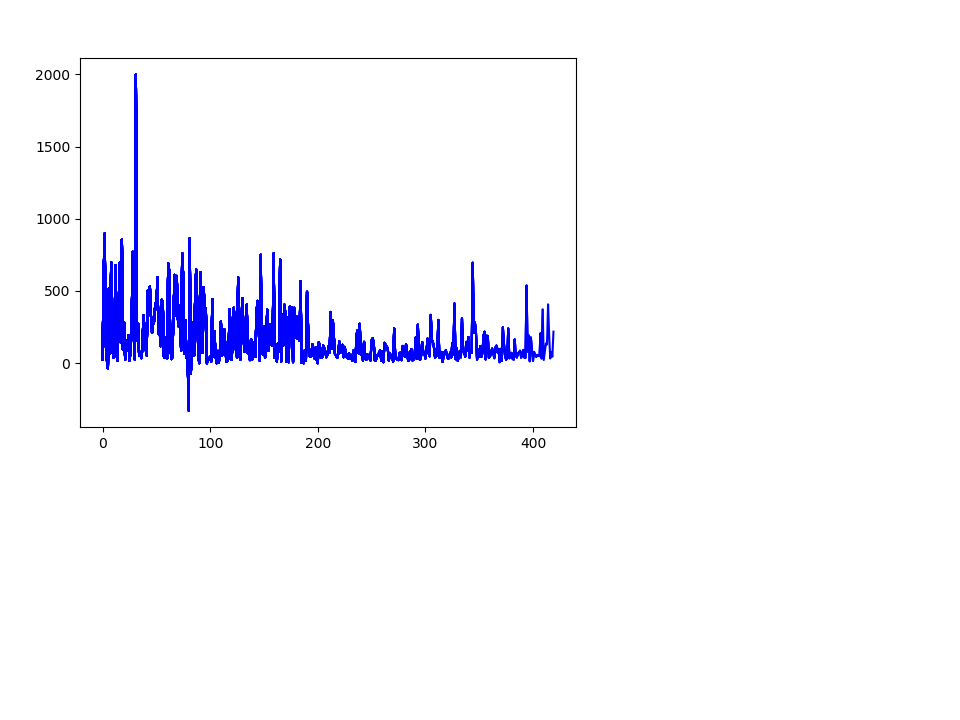

[98.81025  89.384674 82.74214  81.534645 76.11836  75.65244  75.88162
 73.07929  67.868805]
[113.833206 107.747444  90.97408   94.36317   92.41381   84.43413
  87.11244   86.47741   76.9582  ]
[110.361565 106.400085  86.9183    94.58155   91.6485    82.51026
  87.236305  87.08571   76.784966]
[88.23557  78.2099   82.805374 77.74808  73.05778  74.68987  76.44402
 71.67491  71.520096]
[103.05076  102.718895  84.81576   92.08905   90.93619   81.05088
  88.282616  91.27084   79.08028 ]
[99.20463 92.3876  91.64544 89.12807 83.72567 83.76723 86.42934 84.75171
 79.89256]
[87.72369  81.416695 76.39205  80.63135  78.72086  76.99775  80.435356
 76.97119  72.5477  ]
[86.22061  77.852585 77.60932  79.04258  75.68576  78.84869  79.76426
 75.43063  71.99872 ]
[82.12622  70.71857  77.62978  73.39177  68.25219  75.002235 73.84193
 67.67842  67.90752 ]
[73.678276 63.090828 72.623886 66.82953  61.641254 67.255486 66.59907
 60.21231  62.72946 ]
[39.205536 36.34164  54.52802  40.46802  34.26598  40.08171 

[138.29945  128.33327  132.86632  120.09441  111.055374 109.34417
 111.72405  108.70007  106.20643 ]
[127.513504 116.20723  127.373764 107.82896   97.33813   99.47234
  98.88478   95.78386   95.43055 ]
[ 93.27104   73.17474  106.187225  76.943375  63.742416  76.94985
  72.50171   62.472057  73.08957 ]
[130.30551  124.37878  126.45345  114.292946 109.06969   98.90069
 104.44906  100.1897   101.28051 ]
[133.79242  139.86601  118.4603   120.83355  120.40883   96.19035
 108.97397  112.73132  102.538025]
[128.70009 118.31023 128.65648 112.75398 100.27983 102.00928 103.78405
  98.5311  100.06672]
[ 96.6103    78.322136 105.338196  78.981125  68.181274  79.02672
  74.86304   66.438545  74.07662 ]
[119.16779  121.22043  107.199005 103.10382   99.74424   85.40439
  92.08255   95.421425  86.24381 ]
[119.72548  107.505196 123.18264  101.759995  91.74842  100.21037
  95.384705  90.62479   91.828835]
[124.62861  125.04848  121.783775 113.49659  108.39129   97.75618
 104.2382   105.61554  100.1739  

[15.276165 15.09913  16.337233 25.551908 24.689575 31.056751 24.84886
 23.459238 23.06578 ]
[25.967087 18.271042 42.220238 39.170208 36.2664   51.68406  40.96781
 32.315823 41.96425 ]
[60.130505 50.092777 55.09442  59.300842 54.518444 62.752495 59.316833
 52.04716  53.72413 ]
[35.255806 35.548542 27.222572 47.262493 48.15432  46.037514 49.916508
 47.4449   44.97774 ]
[70.969315 71.50361  53.471428 69.877975 69.9159   59.17173  67.44224
 66.75968  59.486324]
[71.59113  65.96321  60.32139  64.3005   60.396572 58.30747  60.813354
 58.36591  54.82255 ]
[78.67057  62.910385 75.29584  71.11905  61.704556 74.10363  70.47628
 62.16193  65.37685 ]
[47.290592 57.308712 24.83763  53.804386 57.99714  36.52719  49.59038
 50.67964  42.91065 ]
[41.00536  51.90302  16.356003 47.980118 55.673115 32.00711  44.952465
 46.46378  37.90851 ]
[44.50615  57.12325  16.325869 46.685318 58.022846 30.420534 42.90114
 43.678173 34.25864 ]
[ -8.974628  -12.111559  -16.680227    6.6630173   8.538577    1.4948645
  1

[141.90485 141.38863 105.5441  112.32026 110.25648  93.05287  98.11188
 103.8641   84.83533]
[139.48894  131.30862  109.96876  111.103546 102.816864  95.35231
  98.27187   98.00485   86.82464 ]
[138.6758   140.07318  101.23339  111.44859  110.19741   87.81336
  96.22205  100.71522   83.673874]
[150.76714  150.02548  114.0078   121.92057  118.97859   97.712006
 105.96653  109.46174   93.29857 ]
[143.57515  143.60123  113.71065  117.729546 112.87877   95.73251
 102.079155 106.4528    91.51092 ]
[151.3069   144.62794  124.37448  122.86707  113.46009  101.855415
 107.01348  106.87817   97.015045]
[152.95247  152.55244  117.84933  124.25717  119.2908    95.72077
 105.73198  107.45309   94.714516]
[140.46062  141.622    113.5957   116.112976 115.25356   90.62825
  99.51957  100.73253   90.969025]
[148.72551 150.09729 115.75828 122.33898 118.28018  93.395   103.86692
 105.7661   93.53384]
[131.67572  118.598145 114.49034  106.03116   90.97025   88.8759
  91.91018   88.042465  85.76687 ]
[156.

[141.0894   143.53125  132.00471  126.60014  126.120575 111.9361
 117.93498  123.84392  110.53099 ]
[136.14474  134.18571  128.98009  120.286064 117.797325 109.08592
 112.99741  115.84797  106.32709 ]
[130.21368  122.96109  131.54306  113.17411  106.34553  105.01231
 104.987495 104.10435  101.428345]
[122.46148  132.58594  107.2251   108.51136  112.27136   89.62142
  98.202644 107.51846   90.78081 ]
[117.26946  129.36655  102.97268  104.06033  109.726494  87.85799
  94.92614  106.39877   87.472435]
[134.40335  132.1024   126.65177  121.16931  118.43457  110.674934
 115.675606 118.20396  108.23082 ]
[122.797134 123.3183   115.70673  111.66258  111.37686  100.62806
 106.22013  109.83337   99.581604]
[125.19124 124.4578  115.24878 110.2997  109.50265  99.3508  103.78504
 107.09802  96.69121]
[124.80463  120.189156 118.57751  111.44616  106.955666 102.82256
 106.0551   107.17479   99.43353 ]
[123.12998  121.81535  114.85278  112.01098  107.26755   99.80227
 105.8141   108.58615   98.864456

[70.6662   67.90628  64.97494  69.80464  66.73028  68.9253   70.19221
 69.890335 64.9586  ]
[47.946625 39.13954  53.92777  59.19553  51.390972 71.15242  64.77253
 60.71721  62.307915]
[38.34073  30.180244 40.982403 56.236248 53.70876  69.88478  65.743324
 61.445843 61.49732 ]
[48.67562  54.579674 36.784904 63.88794  71.01897  62.505383 68.49309
 69.59103  61.719532]
[58.82196  66.59183  40.473698 66.7367   75.067245 57.99855  67.12458
 68.859215 59.303123]
[75.78551  72.505035 61.64995  73.26265  73.907776 70.58022  73.94081
 73.353424 64.909164]
[60.28208  49.364895 62.184242 64.83992  58.32144  73.94244  68.43833
 62.828777 64.50139 ]
[57.211193 50.156452 54.52214  64.51078  62.888214 71.09228  68.51629
 64.260185 63.15859 ]
[73.158966 65.33083  60.882427 73.06945  71.02746  74.41406  74.91509
 71.40772  66.02196 ]
[67.1685   64.73005  50.26316  69.11026  71.403435 63.13777  69.829544
 66.851875 60.93959 ]
[70.56965  60.573124 63.695644 66.906334 63.554607 69.95573  67.837135
 63.605

[88.27563  80.47621  82.00158  79.69147  76.03506  77.221855 78.36577
 74.331635 72.234566]
[55.98951  47.992634 57.84098  58.103    56.731148 63.685524 60.37291
 53.298225 55.74587 ]
[66.24313  58.81993  59.29816  62.005375 61.328022 62.00966  63.415146
 58.047855 57.58719 ]
[83.374115 73.7818   79.021454 75.6024   71.70193  70.75315  74.46594
 66.93362  70.532715]
[65.36144  64.94729  63.75888  63.32654  64.45609  58.15483  63.410694
 61.994095 60.303223]
[67.89564  69.92574  67.25472  68.36804  69.94143  56.534126 68.46274
 70.11766  65.78624 ]
[59.552727 71.75452  50.35312  65.84033  74.18831  48.72253  65.40954
 68.65434  60.712193]
[64.51683  73.22237  52.633    67.76148  76.131355 55.17948  68.87027
 72.58143  62.29217 ]
[14.458238  5.297525 25.185621 31.355196 28.11409  30.242012 40.92711
 35.192036 41.0986  ]
[22.262112 14.977094 23.280039 28.931738 28.022736 23.353344 29.653133
 25.362885 27.266302]
[10.7824135  3.8412433  3.5023713 16.59883   16.312412   5.325055
 16.601065 

[117.13391  112.440956  91.46313   92.63425   88.19866   77.77054
  80.97614   81.63313   71.70938 ]
[110.26019  106.58805   87.94083   88.121025  83.70896   72.46612
  76.27173   76.54769   68.50726 ]
[112.20813  110.95507   89.11256   91.06331   88.73528   74.54588
  79.450134  81.948555  71.18498 ]
[109.17106  100.09779   94.012596  89.554     80.326515  81.07191
  81.241714  80.641136  73.56854 ]
[119.00744  113.54576   90.66886   99.74167   93.83251   82.52579
  89.6554    87.81279   78.967804]
[128.2558   130.37091   91.70114  103.62409  104.293434  82.85461
  90.70458   95.88422   77.970894]
[128.90689  121.26318  102.61941  104.607605  97.08997   90.71585
  93.85426   93.82634   83.07466 ]
[125.62834  120.00859   97.34176  101.748886  95.30208   86.97017
  90.77069   91.82081   79.55343 ]
[127.735916 119.60802  102.93333  103.66582   95.97362   91.47392
  93.54911   93.741486  82.84542 ]
[137.41164  140.3994    97.76941  112.45209  111.79472   88.31464
  98.154854 103.91123   8

[135.03386  127.00098  131.84319  118.52579  111.94554  107.03248
 110.30654  107.043144 105.86873 ]
[53.342587 40.3804   62.993645 47.972927 44.032986 48.070477 48.55568
 42.563427 49.17861 ]
[70.61888  56.79665  78.82356  59.88848  50.15806  56.52581  56.869335
 49.5537   56.51101 ]
[28.685532 30.411684 20.147852 39.409405 40.24901  29.499035 41.25759
 45.19604  37.923702]
[-28.988663  -39.700718  -30.711386    2.336092   -0.092969    0.5872297
  11.3989105   3.7546425  10.651258 ]
[-15.485752  -27.030962  -31.519894    3.993782   -1.9486628  -7.881009
   5.405188   -2.9099445   1.1260283]
Episode Count:  6 	 Cumulative Reward:  518.2850000000003 	 eps:  0.05
[67.29712  55.992256 73.32856  58.949116 51.024776 59.34655  56.800407
 49.851562 56.26449 ]
[84.28868  76.27287  84.22691  75.97752  70.689644 73.77459  73.92693
 69.64647  70.24617 ]
[71.48556  70.89841  61.664234 68.490135 65.96408  61.768192 64.59954
 63.696476 60.471794]
[36.865788 26.677223 55.825764 46.530186 41.50212  61

[155.2619   159.13185  113.69608  125.53847  125.826805  95.48991
 107.10395  112.371124  94.093994]
[151.40749 153.72899 119.35494 126.24295 125.13595 100.08861 109.84289
 114.02493  98.57332]
[145.97748  152.06946  113.16682  123.21367  123.57653   95.030334
 106.38047  112.19228   95.107635]
[150.96895  154.95135  117.25864  124.14316  120.91105   94.86829
 105.157005 110.30296   94.23343 ]
[151.27545  153.11589  116.684525 125.20786  120.46876   97.22372
 107.49912  111.4872    95.7812  ]
[156.60445  148.35176  134.89192  129.28389  117.85365  109.05855
 113.439255 112.48659  104.47502 ]
[157.86714  154.88979  128.44492  133.80449  123.631386 108.38743
 117.94881  119.38872  106.56912 ]
[149.96979  151.90366  118.036995 125.65044  122.33144   97.7514
 109.07538  110.93996   98.41517 ]
[150.27438  148.29047  117.810814 124.86323  118.25717   97.682274
 109.0698   109.91748   97.994675]
[147.85728  125.876564 145.34775  124.486694 103.070755 117.281654
 113.75019  104.34715  108.4783

[141.83981  138.17526  134.42467  126.13125  120.38091  113.92259
 118.096825 120.52605  110.98054 ]
[145.28467  144.28587  135.23508  128.81456  125.93871  114.83263
 120.23193  124.303246 112.52982 ]
[141.17755  141.30226  135.11171  125.26582  123.577095 112.45295
 116.39611  121.23986  109.942276]
[136.21562  133.36778  130.89719  121.997925 118.74727  111.69704
 115.51469  117.967155 108.92428 ]
[130.39601  119.75346  133.94817  113.85438  105.845924 108.75047
 106.98709  103.31688  103.45605 ]
[134.45699  132.81364  129.91501  119.43805  115.043526 105.64224
 110.1085   112.67289  104.937744]
[133.44266  137.43643  121.389206 118.681274 117.61104  101.710365
 109.239746 115.838005 101.97673 ]
[136.61418  138.15533  124.04129  121.671616 121.43673  107.46108
 114.186165 119.07369  106.03318 ]
[129.27519  122.07365  125.89804  114.49434  107.760315 106.20146
 108.488365 106.7307   102.967606]
[132.66339  117.44676  136.754    114.47148  104.16283  111.42842
 108.52685  102.17002  1

[105.631    111.245964  79.05399   89.46057   88.90358   69.46597
  77.99174   84.2494    68.407646]
[104.8194   108.393     79.01645   85.65452   84.197296  67.929504
  73.823166  80.20052   64.551315]
[104.70034  105.20891   76.45981   85.69182   83.162254  69.59504
  75.46218   79.50467   65.041336]
[99.26451  92.176765 85.20202  83.342804 72.139656 76.58131  75.420265
 76.19411  68.52233 ]
[105.028404  90.14826   96.49328   87.264626  74.991035  85.54145
  82.286575  78.87041   75.29928 ]
[109.45362   98.48517   99.31504   93.132065  81.77786   88.0384
  86.93272   86.007454  79.346176]
[94.87375  77.01036  97.20526  85.058655 72.37582  90.904854 83.440125
 75.76607  78.93424 ]
[107.16092   89.36499   99.63929   89.62681   76.647255  90.65002
  86.05189   80.2544    78.63864 ]
[108.41414  103.33776   83.681816  93.46115   83.882355  81.3385
  86.35584   88.67686   74.82559 ]
[107.77891 101.31918  87.02695  91.89082  83.75793  84.46653  86.16993
  88.54742  75.11138]
[82.676384 76.1

[75.752335 68.47846  68.63721  69.9599   64.05796  68.28223  69.53889
 67.147705 63.187057]
[82.685196 73.28798  77.574585 72.65389  68.311005 73.51336  71.90487
 68.729935 66.01744 ]
[74.18515 70.2659  72.37997 68.54649 64.40659 66.9594  67.66942 67.70461
 63.06616]
[81.24888  67.257164 84.41157  70.85085  59.77375  71.602135 68.44605
 61.23555  65.90853 ]
[73.73644  79.313644 67.42165  72.959114 72.73515  60.2571   69.574585
 72.737465 65.322975]
[63.596676 70.13677  48.81094  64.59207  68.39789  48.39344  62.645042
 66.796616 56.161182]
[61.768326 71.77371  45.21094  63.17835  68.76414  48.46102  61.304146
 66.696465 54.02581 ]
[18.204813 23.247879 10.943719 34.906765 47.773853 32.09077  41.80737
 44.73446  38.08614 ]
[38.785793 36.057316 35.047695 43.35035  43.767155 40.155224 43.45801
 41.934258 40.476494]
[43.09391  54.230892 35.561954 44.96367  52.33794  35.37501  38.28728
 46.607937 32.98538 ]
[61.92428  61.98452  54.333973 62.54789  62.41483  60.73658  58.927017
 58.620113 52.

[170.48581 155.21797 156.0044  145.80765 129.77866 129.71    132.10359
 127.76717 123.67071]
[168.67058  152.75446  153.60155  144.59285  126.76004  128.67996
 131.17369  126.667915 122.39225 ]
[171.89197 155.03712 156.75    147.3501  129.59932 132.48192 134.31184
 129.25504 125.11895]
[171.62448  154.42262  158.75414  146.27307  128.01282  132.3172
 132.95287  128.38849  124.471954]
[172.61847 162.86484 150.91516 148.36694 135.11258 128.01515 133.8562
 133.56178 123.42287]
[175.11682 171.50038 150.5946  154.29974 142.50038 126.19046 137.34673
 139.50368 126.85496]
[165.472    166.10228  141.69724  145.61363  137.36288  117.499596
 128.64067  132.93396  118.854645]
[169.16856 160.8324  151.18591 147.37349 132.79025 124.97289 131.72665
 131.43575 122.82112]
[166.40926  146.22661  156.10266  140.88129  120.39613  128.30626
 127.92287  120.95239  120.607956]
[173.69894 153.83969 159.67392 148.48888 129.52078 133.88737 135.46487
 127.291   126.91193]
[167.45557  150.3606   153.1561   144.0

[89.55924  81.63064  89.3254   79.59029  74.236534 75.78874  76.69385
 73.79127  73.67746 ]
[64.4669   59.143276 72.77615  59.368717 54.0077   58.701813 57.5132
 55.04503  57.39798 ]
[83.397606 77.64403  82.82035  78.48401  74.11136  67.81625  74.588905
 67.220764 73.23328 ]
[87.34322 89.61576 83.78047 85.56989 85.40012 71.77035 82.41234 81.54965
 79.51907]
[96.92443  99.41173  89.57381  92.20437  93.052246 78.67574  88.207375
 89.092476 83.54575 ]
[87.19629 93.3665  79.76158 84.84396 88.98848 72.93805 82.47347 85.94465
 77.43099]
[81.51277  79.50773  81.121086 78.71244  76.4046   71.6589   77.84227
 75.95122  74.88852 ]
[81.70666  75.4044   82.26717  77.441414 73.55752  70.540825 76.31949
 71.12955  73.95447 ]
[70.44201  69.20455  71.49853  70.96961  68.69932  61.784294 70.51129
 67.53358  68.59319 ]
[52.808285 64.37177  43.871727 58.60935  65.93087  44.781803 57.982407
 62.008934 53.58801 ]
[33.484467 47.822548 15.472699 40.153397 55.98248  25.683537 40.924896
 50.004692 34.43382 ]
[

[54.227596 40.971237 55.600906 58.566    51.40326  65.149254 61.317924
 52.323864 58.15165 ]
[86.386505 75.05762  80.243225 76.458824 70.0146   76.83825  75.20069
 71.60201  69.282166]
[90.795616 78.67242  84.53391  77.99572  72.17798  78.14516  76.433784
 72.117966 70.50313 ]
[77.018936 78.59582  60.45498  74.148026 78.33852  67.37567  73.192055
 74.324486 64.96299 ]
[100.82829   97.79248   82.3304    84.552345  81.7945    75.710335
  78.73264   81.69529   70.122925]
[101.08742   97.4731    82.22643   85.09847   80.11876   72.28072
  77.05812   77.83154   69.974884]
[107.65779  105.39953   79.045906  91.856834  87.95233   77.18466
  83.49232   84.01863   72.74698 ]
[77.19763  78.90331  51.91558  72.61916  78.13807  64.291084 70.18526
 71.36437  60.772762]
[62.398785 60.43907  52.689117 60.699577 58.54603  54.417667 55.97857
 54.443333 52.409397]
[24.795233 20.882704 21.512661 30.977959 24.907    27.24749  25.586536
 22.983673 22.463211]
[ -1.2937626 -11.400458  -13.38471    15.7350445

[149.24902  147.49193  134.57385  129.71085  125.13446  111.647385
 118.41041  122.51303  111.25098 ]
[148.04308  147.44978  130.71509  129.65042  124.73232  110.45339
 118.47154  122.980446 110.390915]
[145.25957  139.52538  133.5724   124.92089  119.108215 112.42476
 115.68665  117.53092  108.72247 ]
[137.91759  127.261185 136.14018  118.09031  108.384964 110.588
 110.096054 109.5977   105.93224 ]
[138.23357  132.55893  131.90666  119.84898  115.59769  109.64628
 111.99492  113.831116 106.61746 ]
[138.31561  127.6792   136.2509   119.414635 109.97859  110.52882
 110.912125 108.909485 106.905014]
[139.42465  129.30833  135.56242  120.73192  112.26859  110.313034
 111.53715  108.67886  107.23301 ]
[137.15254  128.45659  134.27637  118.35439  110.90981  109.333664
 110.207535 110.13448  105.95903 ]
[133.49358  129.91129  126.04848  116.43321  113.12547  104.157745
 108.48678  111.036316 103.34839 ]
[139.43376  135.01373  130.28871  120.948784 116.6426   108.19186
 112.53328  115.11679  

[109.32193  113.82625   78.52212   86.984886  86.6553    67.51094
  74.0469    81.33048   64.27498 ]
[110.61674 108.31315  86.40286  86.25863  82.66269  71.51677  74.22568
  77.12052  66.26233]
[108.67603  113.365234  76.52789   83.63961   85.717415  65.53444
  70.635666  78.38873   60.765488]
[117.2271   116.457954  83.87031   92.528824  89.55588   75.001076
  80.43223   84.133385  69.38282 ]
[116.47996  106.43714   95.778824  90.64941   83.453445  81.611046
  80.87791   79.4053    72.873726]
[121.62145  110.75411  104.612724  95.48984   88.470634  88.65276
  86.23472   85.39315   78.64462 ]
[117.3289   105.58399  107.964     90.50956   82.312965  86.111206
  79.920364  79.1613    74.66835 ]
[117.89309  115.248566  90.49718   91.37528   87.96555   73.46499
  77.58223   79.37298   69.36986 ]
[127.88076  120.20336  103.0593    99.59161   93.82411   83.65467
  86.336815  84.64407   78.516304]
[121.42541  122.79211   92.07158   97.89123  102.75671   79.75505
  85.389404  88.29337   75.707

[164.46046 144.37978 154.00607 137.56628 119.19175 128.1084  126.26771
 119.8552  118.90499]
[160.81822 145.35289 146.26375 136.26598 119.36872 122.45005 124.13109
 120.10354 116.02004]
[162.99092  152.91461  144.2349   139.36945  126.30672  121.62841
 126.397606 125.74036  117.3204  ]
[171.20853 164.36511 148.94138 147.21437 135.56839 125.23952 132.66396
 134.11398 122.80762]
[171.53049 173.32327 142.17354 148.5891  142.98631 119.35378 132.11017
 137.53563 121.28843]
[165.11382  154.03152  147.74744  141.3372   126.13691  122.382835
 127.326515 125.264404 118.97474 ]
[162.63405  132.19736  161.17758  133.63016  108.132195 131.986
 123.9769   111.046326 118.669655]
[168.88724 143.68576 161.61145 141.23679 118.38046 132.28049 129.46097
 118.35205 123.21264]
[162.63618 138.23277 155.86752 136.24109 116.1827  127.99699 125.31658
 113.34172 119.47171]
[164.02979  141.16957  154.59212  136.85452  117.302124 128.35764
 125.98504  116.91116  119.06165 ]
[116.48601   88.642494 116.95189   98.6

[109.4528   101.12846   88.22308   87.76299   78.641754  80.114365
  80.100685  81.93188   70.84329 ]
[108.486824 102.23334   84.91787   87.38347   79.55878   76.99221
  78.884865  80.8413    69.49192 ]
[88.43668  80.10333  74.457664 79.04297  72.06158  78.31771  76.371124
 76.210945 68.90766 ]
[87.26783 78.26094 74.85409 77.50325 72.14404 79.61799 75.61097 75.51607
 68.49859]
[70.6467   57.42925  71.13332  69.948135 61.320408 79.59608  71.73069
 67.42339  68.11208 ]
[77.83552  75.50346  63.218723 73.64587  69.73059  69.904236 70.34566
 71.96568  63.819008]
[60.742634 65.591484 44.75533  63.771057 64.68382  58.850887 60.95312
 65.05636  55.22132 ]
[63.613235 68.280396 44.188572 68.79232  68.1327   63.55349  66.948135
 72.571785 59.57978 ]
[62.977337 57.196125 60.90837  65.83204  65.80426  71.075096 67.28853
 64.924706 63.295994]
[46.219902 46.83727  46.148605 53.607407 52.242752 56.94375  52.223858
 52.615215 49.951817]
[49.361523 53.505733 37.945763 54.891933 58.51073  50.182224 52.64

[90.125046 68.14592  97.716324 76.75502  65.54692  79.42682  70.738174
 55.61455  68.977745]
[71.53712  79.807335 47.403206 68.05591  72.01555  50.596485 61.663048
 62.257317 53.084137]
[72.107086 79.77087  46.90485  70.19292  74.928894 56.61971  65.70675
 69.19146  55.56231 ]
[104.269966 111.10777   76.72522   94.60051  100.632225  74.83102
  86.89233   90.689964  76.7866  ]
[108.31345   95.22223   91.1052    95.03241   86.10005   82.438255
  88.4979    77.69619   81.534225]
[114.384285  93.13654  107.1279    95.23159   81.167015  89.53405
  88.439186  75.36601   84.098145]
[121.62533  106.502594 105.30998  103.44864   93.146194  90.33381
  95.39041   85.67307   88.97788 ]
[118.20377  103.21207  105.284645 100.55141   89.30797   87.26583
  91.38858   81.277824  86.2648  ]
[134.7841   115.69246  119.76549  112.16705  100.734184 101.39509
 103.096275  91.524506  96.53843 ]
[135.47543  117.32647  118.52221  112.62753  102.14311  100.825096
 102.59386   91.2358    95.46357 ]
[135.85799  1

[166.76181 163.11671 147.82762 145.50983 138.36859 123.15305 132.28131
 133.80188 123.7925 ]
[166.4711  164.49368 145.74936 144.861   138.5609  121.48825 131.06088
 134.08524 122.15601]
[168.75143 165.87964 147.20212 146.57413 137.44109 121.26315 131.2102
 133.44443 122.35431]
[164.50475  167.95311  138.40602  142.55882  138.40425  114.922325
 126.67919  132.73228  116.85622 ]
[170.00934 166.64388 148.55754 147.44112 138.17448 123.62001 132.93846
 135.54808 123.69482]
[167.60779 149.01122 156.53018 141.48863 122.06799 129.26059 129.26512
 123.34145 121.91127]
[169.84163 152.9716  158.93622 143.08517 126.29325 130.12834 130.52867
 125.77643 123.47167]
[174.93532 161.85376 162.35498 148.3065  135.0772  131.48254 134.41632
 131.15187 127.45904]
[171.00133 161.74495 155.80434 146.53593 134.34596 127.2219  132.37956
 131.50258 124.73216]
[172.60391 158.57822 159.66049 146.52568 131.6681  132.1539  133.7325
 130.86194 125.83792]
[171.47739  157.45673  160.25784  145.88274  130.57677  131.877

[ 98.76513  103.419655  75.19694   81.49631   86.97997   68.31894
  73.83828   78.99915   65.303474]
[ 98.923096 102.54077   76.982086  84.44957   85.68401   70.94628
  76.95586   82.12952   68.22893 ]
[104.516014 106.99493   79.37236   86.67201   85.58384   67.64363
  75.35418   78.22686   67.361946]
[109.31352 114.57393  81.72426  92.89969  94.22844  75.18264  83.20637
  89.73117  73.04591]
[110.6154   115.315605  78.08943   92.41298   89.45919   72.36105
  81.24903   88.734     69.85549 ]
[113.34399  104.21572   95.85032   93.79258   83.3567    85.95663
  86.42129   87.433495  77.73359 ]
[110.95771  110.64342   81.023445  90.62173   84.99509   74.16947
  79.95991   84.63672   69.14866 ]
[111.76015  108.40597   84.04033   92.19766   83.52172   77.582596
  82.52269   85.83607   71.78802 ]
[103.05517  100.40948   76.302444  86.86245   79.83863   73.47978
  78.12109   80.294876  68.32833 ]
[108.11591  110.75075   73.08712   90.25274   86.799995  73.04301
  80.69099   87.20682   68.02229

[131.97098  126.69883  125.85517  116.472694 109.578636 105.55449
 109.38608  109.98705  103.72176 ]
[128.99226  130.67749  117.176216 116.19741  114.53139  102.1753
 109.43413  113.59851  101.995735]
[130.15047  127.967155 120.22147  114.66076  111.181015 103.21825
 107.94057  110.18868  101.12236 ]
[124.64641 118.86202 122.63987 109.20087 101.52468  98.57833 100.8138
 100.28957  97.0859 ]
[124.91667  117.61403  120.49692  109.37311  102.82618  100.650276
 103.095406 101.801285  98.2131  ]
[123.68468  123.64486  115.69305  111.15876  107.87444   97.890434
 104.06104  107.17471   98.197716]
[126.56935  125.74961  116.64128  112.05139  109.37142   99.216644
 104.96678  107.72033   98.583755]
[118.43826  123.42334  106.11933  107.08075  107.564865  92.9408
 100.699196 107.333305  93.42773 ]
[118.44377  118.994705 107.70344  104.64403  103.94657   92.47098
  98.03645  100.8254    91.66333 ]
[114.948715 110.36041  107.31819  101.58297   97.12895   92.00771
  96.096985  95.26367   90.55109 

Epoch 1/1
512/512 [==============================] - 1s 2ms/step - loss: 11.0506
Episode Count:  21 	 Cumulative Reward:  23.270000000000003 	 eps:  0.05
[91.897064 89.31029  80.70793  81.99593  79.15606  72.635956 78.146614
 79.292435 72.07181 ]
[79.58052  82.57457  71.773445 74.26894  76.83328  67.94572  72.94414
 77.0619   67.07533 ]
[82.82746  83.231926 70.66277  77.04586  78.64173  68.47806  75.41647
 76.14379  68.761314]
[77.7144   63.691597 77.429375 70.6095   64.73923  75.3957   70.84884
 63.09663  66.54942 ]
[53.524662 45.47593  60.98135  53.796326 52.146835 61.123486 54.71691
 48.538124 52.523006]
[60.26609  51.72888  65.02361  56.48921  53.026688 60.39964  55.12611
 48.11546  52.48667 ]
[69.31019  67.19867  62.602203 65.550606 67.18168  57.725727 63.85713
 59.692745 60.14799 ]
[65.611206 61.20621  65.15689  62.916035 62.23438  58.167873 62.737522
 57.357212 60.657616]
[31.22826  28.381268 43.35183  38.157925 37.45213  33.942463 41.073433
 37.54676  42.302315]
[58.54366  52.7

[-2.2563555 -1.449858   4.0072336 16.326141  14.64072   14.091571
 16.861065  15.229809  19.381016 ]
[-26.063227   -35.722824   -24.024336     0.24504639  -8.155206
  -3.4669063    5.5426946   -1.1612637    7.0211606 ]
Epoch 1/1
512/512 [==============================] - 1s 2ms/step - loss: 10.1918
Episode Count:  23 	 Cumulative Reward:  85.36300000000003 	 eps:  0.05
[142.759    141.3946   119.57804  121.58897  115.58566   98.74082
 107.76359  110.566895  99.18171 ]
[155.60173 154.31725 132.54776 134.7944  128.78598 112.88284 121.59687
 125.118   111.66587]
[151.71783 150.4635  129.99246 131.57274 125.25281 110.16708 118.30471
 122.27994 108.79965]
[154.16396  155.47449  128.91373  135.51758  130.91211  111.80952
 122.21735  126.853806 111.51819 ]
[151.78966  150.41661  129.66309  133.60895  127.638306 113.49334
 121.94912  125.39891  111.57705 ]
[152.03392  146.74037  133.49165  130.96005  122.31645  113.10714
 118.854065 120.30452  109.87893 ]
[157.64256  143.32799  149.78052  133.

[ 8.817463  7.216876 20.624458 17.270184 20.43875  26.342573 20.120523
 19.50512  22.060478]
Epoch 1/1
512/512 [==============================] - 1s 2ms/step - loss: 13.4583
Episode Count:  25 	 Cumulative Reward:  19.264 	 eps:  0.05
[90.771774 88.521355 71.79402  71.36845  70.933334 64.03904  64.27527
 68.95635  56.509666]
[99.56736  99.60574  81.39677  83.47796  83.23475  72.21259  75.455605
 79.91452  67.68196 ]
[104.938866 106.80293   81.88846   86.78423   89.55145   75.66611
  79.09694   86.08638   69.46338 ]
[98.99687  94.38691  78.867424 82.65745  79.66887  75.21655  76.67716
 79.23107  67.380325]
[97.770226 84.25381  84.780685 83.89971  72.52108  80.67099  80.020035
 75.69765  72.01395 ]
[108.5206    92.078705 105.51988   90.513054  79.9093    90.540726
  85.15846   79.1913    80.22528 ]
[32.75599  22.708965 59.72896  45.69834  38.628895 63.190742 49.079273
 41.522545 53.553116]
[47.298317 36.99623  64.61975  48.516212 43.012215 58.546997 46.18089
 38.25095  47.387264]
[80.665

[124.72459  115.78726  106.0244    97.88338   91.62175   84.64498
  84.95388   83.656685  78.41848 ]
[121.62685  118.8336    96.30206   94.523125  92.88473   75.64363
  79.02029   80.089355  71.673035]
[126.11521  122.13522   98.96733  100.28167   98.16581   79.479225
  85.47703   84.5778    77.733665]
[119.52467  116.598335  93.70259   94.841545  91.75875   76.25467
  81.197205  82.98199   73.27425 ]
[126.25417 124.66229  95.27133 103.52908 100.76414  80.51063  89.368
  90.07001  79.96131]
[127.52144 128.9441   92.41104 102.07626 102.10076  79.78624  87.64149
  92.45733  76.69823]
[131.19926 131.4226   98.01907 103.64211 104.09248  83.17924  89.07819
  93.85353  78.56767]
[126.510956 108.431915 112.58812  100.17684   86.81796   95.56306
  91.32755   86.762314  84.03639 ]
[123.93941  112.589714 104.93488   99.51431   89.82741   89.82604
  89.40973   88.67979   81.16437 ]
[128.44539  115.02102  109.14965  102.221634  91.35848   93.747475
  92.31892   91.39153   83.70884 ]
[122.15885  11

[126.070435 108.6253   111.97019  102.14573   93.81453  102.33788
  96.92327   92.2999    88.1588  ]
[125.65164  105.77361  115.664474 101.02178   91.259964 103.166374
  95.30311   88.67799   87.67959 ]
[124.238014 100.391235 122.50676  100.27355   88.16686  104.102356
  95.30812   85.92132   90.63244 ]
[124.116135 100.16689  121.7023    99.675446  86.9343   102.75667
  94.31931   85.08394   89.67744 ]
[133.65007  107.955574 130.04637  107.02912   93.963646 110.49369
 101.05505   91.67657   95.58263 ]
[130.25026 100.22363 136.06914 104.37563  91.83638 109.71572  97.23924
  80.07573  95.28642]
[128.6228    99.09513  117.430214 106.753586  91.01468  104.144066
 101.796     83.09405   95.4688  ]
[126.60642 100.54296 113.73713 105.78639  90.9771  101.12824 100.42141
  84.51853  93.74829]
[129.56192  111.77574  114.92021  109.9667    98.136765  98.978165
 100.92494   90.77656   94.1591  ]
[132.34232  120.7546   107.283745 112.78891  107.07426   95.53462
 102.490746  94.193726  93.50132 ]
[1

[162.99236  160.47298  146.27155  142.68346  133.85413  120.745834
 127.19843  130.70773  119.07236 ]
[165.81976 162.45465 149.36874 145.06635 135.64313 123.0203  129.6081
 132.6026  121.56295]
[169.1384   167.2259   152.55353  147.49525  138.29993  123.08744
 130.63263  134.3389   123.065636]
[168.52621 167.50194 149.77498 147.19301 138.52849 121.75654 130.13739
 134.28687 122.0034 ]
[167.20921 167.73367 149.96005 148.21774 139.87236 123.19018 132.21233
 137.5339  124.02234]
[170.39665 167.20038 154.62746 149.27554 138.34589 125.98651 133.0311
 136.621   125.19747]
[163.75404  147.86438  158.88152  139.5068   121.91521  126.813866
 125.67642  121.168045 120.59876 ]
[163.23853 158.32382 150.07646 142.2989  133.52556 121.13881 127.90638
 129.30948 121.40893]
[166.14952 168.53682 142.72244 144.70503 140.10898 118.4084  128.87732
 134.88528 119.53514]
[158.05544  157.26212  142.36688  140.51964  133.48555  120.371346
 127.45939  131.75708  119.03209 ]
[159.9778   150.47931  151.03336  137

[130.54893   97.64186  128.78015  108.33829   88.72495  105.9563
  99.08394   76.0568    95.566635]
[132.28215  108.005264 119.01165  112.935844  96.55944  100.62787
 102.60912   84.67734   96.78006 ]
[127.79968  107.59224  112.07259  107.763985  94.714874  94.8113
  97.83758   83.66614   91.72669 ]
[130.17952  113.33845  113.8227   110.51167  100.09089   95.07026
  99.12928   86.354454  93.07926 ]
[128.95331  109.95043  115.64518  109.368     98.07572   98.19282
 100.099464  87.57309   94.1606  ]
[131.6896   114.39716  117.19871  111.35308  100.67134   99.17643
 101.18537   90.49072   94.827515]
[131.76176  116.57107  114.669945 111.132645 102.062325  98.32169
 100.801285  91.991135  93.573395]
[135.7601   118.66054  117.11707  114.84978  105.47173  103.670616
 106.13402   96.60994   97.8868  ]
[130.38586  116.97782  110.34207  110.33458  103.936195  99.471794
 102.65984   96.66713   93.939606]
[127.82808  117.26959  109.02552  106.63372  100.66593   93.75332
  96.713264  92.80189   8

[170.76888  166.50365  153.47192  149.99513  138.73766  125.62885
 133.4557   135.19362  125.386795]
[174.13554 168.0548  157.97964 151.80055 139.85144 127.90291 134.88884
 135.66914 127.30258]
[169.79529 167.2466  151.7892  149.20102 139.01834 124.77796 132.68732
 136.20195 124.26814]
[163.7941  164.50458 145.63113 143.70978 136.27557 117.60841 126.67461
 131.14247 118.97479]
[172.61838  162.54834  161.62282  149.38759  134.77116  130.18568
 133.52101  132.38396  126.875175]
[167.94402  151.33784  160.79834  143.62096  124.722694 129.76573
 129.08113  123.86644  123.12259 ]
[166.53038 145.42384 165.39224 140.16644 121.29595 131.11101 126.6262
 118.26152 122.46759]
[167.18427 145.54842 165.2614  141.04478 121.93891 133.87126 128.50966
 120.36742 123.39035]
[165.04643 145.79666 161.68802 140.04419 121.86548 131.11784 127.15073
 120.32641 121.78374]
[163.10535  144.91908  158.41774  138.55862  121.36097  129.36171
 125.945404 119.89671  120.1876  ]
[160.85     145.89241  153.7147   136.7

[ 3.3335717 -2.5465808  6.2215166 15.388092  12.039899  12.831584
 18.891663  16.611176  18.632973 ]
Epoch 1/1
512/512 [==============================] - 1s 2ms/step - loss: 12.6580
Episode Count:  30 	 Cumulative Reward:  24.143999999999995 	 eps:  0.05
[88.16218  89.800224 69.93872  71.739655 69.246925 60.658527 61.632908
 66.649994 55.795082]
[92.50491 89.4015  77.51158 77.50745 74.48692 69.92437 70.80363 73.71619
 63.85395]
[85.634605 81.48848  74.28724  74.65939  74.02111  71.31554  69.30088
 69.23288  63.890606]
[94.85037  82.99692  86.58749  80.721085 72.89942  79.86643  76.20889
 73.23952  70.117935]
[97.12701  92.9596   75.689606 85.57661  83.97995  77.02224  79.72322
 78.78087  70.30487 ]
[103.18161   89.75592   99.86795   86.8352    77.23961   86.17443
  81.24168   76.920685  76.62014 ]
[109.81519  103.522156 101.95711   93.704956  87.32513   84.90256
  84.53764   83.64073   79.690926]
[110.17478   97.921906 105.717285  93.37756   83.00624   87.82694
  85.44681   81.03256   

[164.4158   157.16078  146.61188  139.25555  126.05957  116.17339
 121.56656  121.131676 114.705666]
[165.80019  141.52083  167.39851  138.67493  117.47668  130.54633
 124.958824 113.45874  122.258   ]
[171.34598 163.82727 155.14192 146.555   134.31715 121.11047 127.98405
 125.93018 122.0846 ]
[178.80078  186.87318  148.14915  154.56946  150.76575  117.391624
 131.85764  140.11249  122.425064]
[169.0345   161.00644  156.23509  144.60397  131.25494  123.894554
 127.19033  126.52523  121.02171 ]
[168.54689  144.62428  167.67874  140.86171  118.22379  133.02635
 127.330666 118.05341  123.27882 ]
[168.28642  153.85934  158.26419  144.28038  127.10247  128.35614
 129.36119  124.870544 123.15217 ]
[172.23582 158.16753 160.67644 148.43416 130.2224  130.35242 132.70297
 128.09656 126.14366]
[173.54271  160.9631   161.08344  150.05708  133.08214  132.78845
 134.77106  131.76678  127.365974]
[164.3271   153.40286  152.19572  142.23216  126.48003  125.10719
 127.425766 125.32259  120.41856 ]
[166

[105.66949  106.976204 100.025024  96.46894   94.89726   84.053505
  89.72527   91.87418   85.620544]
[101.30595  100.81906   95.56666   92.80021   90.39623   82.713844
  88.23479   89.6583    83.7456  ]
[102.95631  101.125626  99.691124  92.878624  85.63329   80.61385
  84.90914   85.87609   81.786644]
[90.25423  90.71937  88.34636  82.7574   81.893005 74.15333  78.45495
 79.93934  75.560936]
[98.99535  97.320724 96.21888  89.61452  86.67409  80.146774 84.24663
 84.62967  81.06842 ]
[90.407295 83.24795  93.74836  78.66178  75.387474 74.828156 74.3859
 71.184715 73.414635]
[93.55001  88.00673  95.0276   83.87534  81.002075 76.65372  79.05696
 74.744286 77.76163 ]
[87.92925  90.52297  88.40168  80.38748  80.97937  71.77899  76.010925
 79.76799  74.05675 ]
[78.51998  87.78309  71.70457  70.25505  77.1271   60.276917 65.01055
 72.415245 61.280666]
[87.163284 95.55577  76.32896  77.48146  86.17832  66.36309  71.891914
 77.51406  66.973885]
[58.324505 70.839264 52.67867  60.26145  68.587524

[95.54908  89.81663  95.770035 86.96272  80.766426 81.66687  82.38247
 79.137726 79.25035 ]
[68.67725  64.99818  84.97876  64.424385 59.124672 67.53126  62.157333
 60.207367 63.290985]
[72.19562  61.07634  91.21738  66.66289  55.529583 69.96279  63.943226
 55.273712 66.46586 ]
[84.69463  76.89485  93.42969  79.97838  71.708145 71.76686  74.75995
 64.506    76.08179 ]
[85.581474 85.49291  87.539085 83.80222  80.449776 70.18873  78.14071
 72.193726 77.57175 ]
[95.36996  95.56721  94.588554 93.198    90.34888  76.948814 86.85667
 80.263565 85.52447 ]
[91.63473  97.59956  81.736534 89.86304  90.1591   75.00821  85.301636
 87.06938  79.73997 ]
[103.76423  110.8065    91.68383   93.47978   96.487785  81.26097
  87.02183   94.939606  80.42361 ]
[98.7065   97.25904  96.98256  88.73262  84.17426  80.47142  82.16127
 83.78644  78.799355]
[93.14427  91.6217   91.92206  83.74496  80.13161  75.79142  77.742584
 77.93958  74.92954 ]
[79.533516 75.83941  85.66761  74.98479  69.7056   68.54282  70.963

[131.08745  117.89305  113.63333  105.8336    94.17367   96.197205
  95.08135   92.52634   87.39338 ]
[133.9549   126.88015  107.4628   106.50762  100.44753   92.09353
  93.857315  94.74625   84.27065 ]
[136.00372  136.6954   101.331924 108.4103   106.61309   85.67302
  92.65375   97.44523   81.972755]
[140.05992 132.0617  112.61477 111.16521 104.99842  96.63477  98.16073
  98.51391  88.18848]
[138.80016  128.76729  114.72869  110.548065 101.53174   97.53702
  97.72435   96.69072   88.472984]
[139.80247  127.82685  115.62442  106.838394  99.77414   96.934555
  94.087204  92.79916   85.01834 ]
[143.6633  135.38474 113.69945 110.71013 105.04816  95.70466  96.17564
  96.34009  85.96598]
[151.54155  148.00568  117.189354 119.85385  116.52466  100.6151
 104.32378  107.90376   92.62838 ]
[151.57544 157.89478 108.81391 121.32362 123.59768  91.19149 102.01953
 109.41706  89.71553]
[153.60707  155.82715  117.60774  125.20094  125.09877   97.30649
 107.08428  111.42863   96.438705]
[147.41422  1

[158.70827  152.58717  153.2515   137.54141  127.22615  123.77079
 124.745575 127.535965 119.36295 ]
[149.75175  138.29918  151.09859  128.53676  115.90037  118.1005
 116.18436  113.40737  113.431725]
[158.86539  150.26704  152.52747  137.63469  125.0855   119.45254
 122.484085 120.47106  118.31989 ]
[153.31723  152.73505  142.2921   130.66034  125.97206  111.542465
 115.41729  119.94854  110.18445 ]
[139.36545 137.46921 123.48229 118.2512  114.6219  100.83375 105.77149
 107.52542  99.28524]
[142.1486   142.32486  137.67746  125.45755  118.133545 108.39097
 111.81319  116.63038  107.71676 ]
[154.54224 156.09961 144.69249 137.80908 130.05966 116.98621 123.34903
 129.06715 117.35378]
[148.70065 145.8133  142.2339  130.57999 123.28516 115.40194 118.88755
 121.60811 113.72921]
[146.95564  139.82964  144.29556  129.01859  118.206894 115.47027
 117.43436  116.74719  113.47209 ]
[144.4656   139.5333   139.70111  127.11477  118.25237  113.165985
 116.08746  117.37484  111.45143 ]
[143.2009   1

[77.133255 79.980034 64.23534  77.57289  74.144165 71.39927  72.6482
 76.365204 66.349304]
[70.22368  59.9899   74.791855 72.948395 62.774246 80.551796 73.18658
 69.815956 70.33184 ]
[28.92391  18.64578  45.848473 42.58969  35.49864  55.222565 46.093838
 39.665237 48.482582]
[60.134224 49.841656 64.86138  62.79765  59.217766 70.99308  64.026566
 58.684776 60.973686]
[73.6352   68.87285  70.36319  73.392715 71.67398  73.94976  71.55602
 70.23686  67.29179 ]
[34.09029  48.284187 23.821993 54.65965  63.836655 48.83179  56.888577
 60.376656 51.591957]
[48.35616  63.800697 28.260494 60.11135  72.693245 51.002003 60.470524
 67.36249  52.142708]
[19.287462 35.165245  6.91354  37.793526 51.296154 28.558594 39.44622
 45.248028 34.417515]
[38.448723 52.987377 22.040545 44.372784 59.694096 29.895147 41.272175
 47.040794 34.93881 ]
[49.13754  68.57672  30.94766  52.1753   68.358864 34.67986  44.379013
 51.651134 38.07475 ]
[67.03958  68.64361  56.156567 65.701004 69.02316  58.077328 62.030266
 60.

[66.218765 80.079895 66.60615  70.050735 77.13548  56.236176 66.56733
 71.31628  64.9748  ]
[64.96686  77.719536 55.92266  60.142838 72.87099  51.073154 57.365826
 65.34654  52.84386 ]
[81.34817  91.62541  72.377914 73.9825   83.60291  62.94521  68.965805
 75.359695 64.473885]
[55.599693 71.32409  47.90064  56.439426 68.288956 46.84527  53.93886
 63.19349  49.4528  ]
[53.635006 65.44373  50.460453 55.837555 60.519592 42.63094  51.836395
 58.327152 49.12208 ]
[59.050564 75.069756 48.471603 59.995415 68.75119  42.54547  54.606388
 63.39544  50.213108]
[52.968372 66.99543  43.53997  55.83243  61.598206 42.1612   52.706764
 60.385925 47.942974]
[60.99941  73.78283  52.89315  60.09399  67.17715  48.35122  56.360558
 64.57573  52.009182]
[50.37805  63.888123 41.44136  51.874527 61.440144 41.254196 49.12064
 56.17902  44.846947]
[56.34379  67.71217  48.617542 55.646393 62.77316  46.098743 52.590748
 59.070324 48.32702 ]
[54.431034 68.561066 40.649734 56.355404 65.801834 43.96251  53.100864
 6

[146.43115  139.17784  142.90059  129.04277  119.10529  114.14922
 116.79828  115.3556   112.696335]
[140.44531 132.50964 136.71657 122.67838 114.76485 111.57367 113.43745
 113.21764 108.90714]
[139.07355  128.09802  141.837    119.84225  110.813095 111.36202
 109.68716  106.735405 107.35465 ]
[139.47624  140.09126  135.89432  123.7655   119.94416  107.06983
 111.4065   115.991425 107.642784]
[140.76712  146.77478  130.09854  123.2423   123.64646  104.21554
 109.833176 118.01716  104.08579 ]
[136.43521  139.8601   128.38686  121.44724  120.78477  105.46024
 110.713844 116.79694  105.12956 ]
[138.99506 136.06017 135.38472 121.44723 115.40747 108.10013 110.37622
 114.16849 106.13371]
[134.53197  131.54051  132.02269  118.323425 112.656494 105.67854
 108.23527  111.56723  104.34745 ]
[132.3188  129.93803 128.35184 118.00048 112.75451 103.35406 107.84457
 109.49958 103.8833 ]
[136.33195  130.94159  132.15344  120.997    114.042534 107.62115
 111.25434  110.982834 106.92527 ]
[133.61545  12

[15.327354  9.615294 29.040117 25.008522 19.061968 29.831633 27.012457
 26.288036 28.467388]
[-15.682541  -23.148125   -5.168795    6.365529    0.4780696   9.846662
  12.022076    7.3692365  12.405292 ]
[-21.245132  -23.409258  -20.486265   -6.9475746  -3.5842006  -3.37237
  -3.3813734  -7.3311734  -3.3140266]
Epoch 1/1
512/512 [==============================] - 1s 2ms/step - loss: 11.4339
Episode Count:  35 	 Cumulative Reward:  78.336 	 eps:  0.05
[78.70704  76.44437  69.62091  74.35974  71.50714  65.229935 71.35645
 68.75052  66.08251 ]
[62.55738  68.51327  55.117958 61.621017 66.01743  49.9577   57.303513
 57.66639  53.681488]
[74.2801   75.70331  67.51295  70.446884 71.71957  60.923653 67.17631
 66.896545 62.981533]
[65.95606  58.706867 65.735054 63.91832  63.403778 65.913956 65.19964
 60.027992 61.14874 ]
[42.89027  37.77198  53.712635 48.141384 46.141266 57.23311  50.96134
 47.760216 49.82517 ]
[58.715313 53.617786 64.24933  59.462513 58.04205  62.570873 60.262104
 56.49095  58.

[128.62297   99.524864 133.64426  105.62385   92.056015 108.848694
  97.836845  80.44843   95.28401 ]
[134.30206  106.1645   124.56835  112.600105  97.393364 110.671745
 106.472466  90.49019   99.34026 ]
[134.82784  122.9936   110.53013  115.6659   109.64764   99.114845
 105.62807   98.46906   96.12578 ]
[127.99286  123.256905 102.76672  108.56284  106.681595  90.2911
  97.06425   95.80625   87.72393 ]
[131.39415  125.567444 108.453224 109.447975 107.78073   92.5715
  96.89513   95.70258   88.18894 ]
[125.724724 125.229324 100.50652  108.19559  107.327545  87.24374
  95.90746  100.36066   85.28481 ]
[126.72484  126.11578   99.49249  108.677246 107.803024  88.179726
  96.78989  101.054344  85.65314 ]
[123.48877  125.588135  93.71717  103.42208  105.38787   85.037834
  91.7169    98.6108    79.8304  ]
[126.72205  116.081856 106.11013  103.327736  99.41224   97.16786
  95.47975   95.28627   85.13842 ]
[128.55219  109.19218  116.34279  103.272865  94.028046 103.61139
  96.74945   90.79916 

[130.34554  110.047005 120.054665 109.35421   98.50097  104.152275
 101.70072   91.95255   95.04051 ]
[128.85281 107.80408 119.62055 107.71852  96.34866 103.45053 100.19803
  90.02561  93.80275]
[129.8761   104.84599  123.305405 108.84082   94.667534 106.84223
 101.788956  88.66678   95.74655 ]
[131.01997  102.98357  129.58919  109.29635   93.83963  109.452644
 101.40984   85.23174   96.75344 ]
[131.7222   103.761116 126.80864  110.45931   95.22542  109.61611
 103.3826    87.03846   97.72475 ]
[130.65707 102.26759 124.94032 109.66626  93.88386 107.98498 102.91365
  85.88411  97.36578]
[128.76863  101.326645 119.18918  108.86001   93.02329  105.77663
 102.735725  86.27049   96.07442 ]
[126.67764  97.98346 119.48243 107.48816  91.42792 104.48499 100.67582
  81.45446  94.95599]
[127.91089   99.79057  119.51549  109.19867   92.37016  103.98509
 101.513626  82.14889   95.707214]
[132.10173  100.63492  129.71863  111.451385  93.90759  109.264946
 102.717865  80.77466   98.39728 ]
[129.0959  

[79.59635 80.25341 60.75215 79.20827 81.52445 68.07309 77.06649 76.13394
 68.22228]
[66.45642  57.12698  67.85256  57.924133 52.90199  60.75417  56.09926
 52.92253  53.153557]
[ 3.4756825 -2.9006157 20.255627  21.35634   20.101522  32.05092
 25.943958  20.86237   27.614908 ]
[65.61031  58.426422 59.31907  70.20595  68.15489  68.55662  70.33935
 63.014984 64.22211 ]
[79.54898  76.52115  62.41439  75.905624 74.11493  66.550255 73.45603
 71.32627  65.26202 ]
[56.15321  47.67345  64.25575  56.087425 50.664658 61.511936 56.121605
 50.561417 55.018276]
[91.67504  86.89893  80.72201  85.2343   82.01461  76.484085 80.86943
 77.84469  74.425156]
[86.322    89.07495  81.00902  83.924446 83.8082   75.009224 80.88509
 83.40467  75.695274]
[34.502785 30.18424  49.43792  34.066982 30.20568  35.42829  33.35185
 31.813732 35.133602]
[  0.78120726 -10.790571     4.9891224   19.205416    17.10379
  17.633236    23.739109    17.863155    20.886148  ]
[-10.110431  -19.196995  -19.064577    7.875737   10.2

[ 93.64751  105.87459   88.12892   88.66757   93.42045   71.83716
  80.34633   89.35058   76.521286]
[106.21009  112.6322    96.66992   96.14962  101.518074  82.38137
  88.96244   94.553764  83.483604]
[94.54874  99.1661   89.8411   88.18804  90.89904  80.679184 85.21838
 92.39296  79.772224]
[88.02146  92.535835 83.34161  84.03741  85.254326 73.85321  80.16248
 84.74297  75.52975 ]
[82.37609  82.94738  78.600334 77.47633  75.811    69.44184  74.19788
 76.416885 70.047134]
[89.734726 84.208824 89.55366  81.611015 76.40461  73.635475 76.93703
 74.3124   74.61289 ]
[77.159485 74.58168  79.08244  71.65124  68.06162  64.90714  67.7841
 66.696846 66.10228 ]
[90.15466  89.59234  91.90749  84.827446 82.25512  75.330765 79.74772
 79.35183  77.707115]
[70.09587  83.05239  71.254524 74.15768  77.32769  59.966106 70.34699
 77.086914 68.32137 ]
[63.574608 81.98693  52.754025 61.297523 76.49021  48.205513 56.54288
 67.124245 51.687344]
[58.780785 70.6717   53.3938   59.97337  70.91679  53.297703 59

[77.829544 88.361565 69.107895 73.87347  80.411255 62.527473 69.80938
 78.23532  64.52726 ]
[74.73028  74.012535 71.503975 71.23378  65.86625  63.088318 67.33068
 67.92629  63.493942]
[64.93203  72.25374  57.040382 64.51602  68.238304 56.94785  63.171555
 69.39428  57.465324]
[65.410614 76.63435  58.37615  66.08644  69.94748  56.001076 63.537285
 72.98196  58.200356]
[66.77821  80.794426 59.39762  67.71493  73.0183   54.723938 63.729572
 73.77918  58.830837]
[81.09635  91.61123  67.877556 78.1167   82.225395 64.15459  73.185295
 81.196915 66.34093 ]
[81.78595  87.14996  71.63533  77.87533  77.19277  64.53366  72.38008
 76.71137  66.803696]
[89.42811  96.207954 70.78643  79.91889  81.683105 66.39952  73.16002
 80.88279  64.82922 ]
[81.76405  86.4903   65.89485  74.562485 74.8402   61.735615 68.83415
 72.86564  61.742947]
[78.782196 84.3449   58.93518  73.042    78.7131   62.423023 68.458145
 73.75484  59.563545]
[37.768158 42.121933 27.79779  44.195255 51.852337 35.832176 42.546738
 42.

[156.18587  151.56209  147.79646  138.89941  130.14912  121.233734
 125.480934 127.83255  118.8188  ]
[160.24316  148.68803  157.30852  140.7161   126.4538   125.66568
 125.763535 122.805336 120.65344 ]
[160.30424 156.24695 151.48315 142.70166 132.5608  122.61698 127.35077
 130.15862 120.74144]
[162.47911 164.21118 148.52885 144.98853 137.92488 120.35543 128.28838
 134.84715 120.58452]
[159.85954  156.83195  153.54593  143.5187   133.30782  122.46544
 127.79059  130.28221  122.132355]
[158.44164 135.15024 163.18935 136.44266 114.59287 130.34383 123.60931
 113.08052 119.90069]
[156.5093   148.7725   150.57196  138.78816  126.43431  119.28762
 123.130104 121.64821  118.019485]
[156.64743  153.29407  145.48639  138.68124  129.72516  117.71419
 123.74513  126.10596  117.016266]
[159.2006  161.47833 146.25888 142.02823 136.71164 118.2356  125.90224
 131.76805 118.65865]
[150.40031  151.00417  138.01811  135.0658   130.88333  116.459015
 123.190575 128.10797  115.32102 ]
[151.5603   136.3498

[167.3246   171.57898  140.28868  147.30843  141.36147  113.467186
 126.45374  131.79744  117.16651 ]
[168.5136   165.20029  147.347    145.02174  135.89766  117.17709
 125.48662  126.740166 117.72435 ]
[169.81543  162.33165  151.9145   147.50208  135.98228  121.226685
 128.99338  127.08431  121.95771 ]
[178.93343 176.55223 162.9002  159.16568 147.51634 126.66728 137.47354
 138.44073 131.23169]
[174.02956 166.14928 161.73712 154.13582 138.9189  127.58675 134.64098
 132.79329 128.64215]
[164.16077  164.60278  145.92896  145.83942  136.85576  116.979935
 126.66863  130.3097   119.19868 ]
[171.74055  149.90216  170.3236   148.2414   125.82998  136.30017
 133.12608  124.120705 128.4904  ]
[164.69475 138.7707  166.54524 140.60095 117.10397 133.83484 127.54794
 116.05513 123.5689 ]
[172.22646 156.74103 163.4529  150.76057 132.47404 132.8779  134.69774
 129.1191  128.38364]
[159.3604  164.04532 134.47398 140.5464  136.43407 109.69881 121.44464
 126.86131 112.55086]
[170.08662  164.19128  158.

[122.607346 129.5565   113.73212  112.28425  113.578705  94.25233
 101.729965 108.856445  96.44416 ]
[125.234924 127.17485  118.21464  114.32422  112.59492  100.85909
 105.9736   111.086464 100.22257 ]
[122.59859  119.77433  117.925095 111.48925  106.24372   99.359344
 103.57376  104.85867   98.80088 ]
[120.17851  119.084    115.47378  111.17031  104.795494  96.47836
 102.243706 103.8733    97.708206]
[115.1674   112.51542  109.792625 106.72107  101.06731   93.29252
  99.13726   98.662445  94.55161 ]
[108.61044  111.18989  101.10017  101.673195 100.21839   86.73528
  94.18572   97.17487   89.224724]
[105.749855 108.9382    98.37048   98.82752   99.09589   85.54916
  92.136765  95.73428   86.9957  ]
[101.315125  94.66906  100.88939   92.41111   84.04647   85.02617
  87.272606  85.6911    84.00488 ]
[102.52576   97.181595 102.20776   94.596405  84.19646   82.42848
  86.54512   84.09357   84.143135]
[97.729    90.68766  96.769356 88.95529  83.48654  81.23392  83.790535
 79.71161  81.0186 

[159.92859 153.21732 155.2071  142.66675 129.53761 124.51497 127.94533
 127.89088 122.63126]
[158.33534  157.11667  150.71738  143.51875  134.94229  122.119125
 128.76254  131.11388  122.8618  ]
[158.50594 157.12193 150.08296 143.47728 135.71678 122.12319 128.82593
 130.78354 122.7333 ]
[160.73291  156.72452  154.29417  143.47107  133.32532  123.062035
 127.99845  129.0549   122.645966]
[156.89526 156.31688 149.40524 140.80545 133.09242 121.5705  126.83154
 131.70253 120.61141]
[156.28789  159.25926  145.12793  139.29626  136.00691  119.472435
 125.35136  132.28134  118.1647  ]
[155.63588 149.04945 154.28156 138.8352  127.57312 123.25369 125.22227
 124.93242 120.80098]
[144.12886 125.78552 155.33621 124.57768 106.78344 118.89782 112.63955
 104.25155 112.01938]
[150.24355 141.55869 150.29678 132.18541 120.99682 116.96746 117.77649
 115.16348 114.62243]
[149.42151  148.9556   141.45552  132.03809  124.89306  110.95772
 116.49886  120.433624 111.4901  ]
[144.9457   149.29285  135.32362  1

[70.49573  88.629166 57.656208 72.32778  83.186424 54.38477  67.48532
 76.39231  62.235554]
[56.933716 70.45132  48.21511  57.270725 68.26953  47.19593  54.112778
 60.929073 49.713116]
[52.309887 63.992767 51.418106 54.89927  60.479637 44.627    51.372616
 56.958565 49.52505 ]
[26.802488 38.338303 22.019089 38.42899  54.842976 31.437954 39.86047
 46.116314 35.46432 ]
[33.373035 45.133926 27.08852  45.476707 57.822014 35.535736 44.905308
 50.088108 39.888947]
[26.581968 37.099277 19.23378  36.96608  45.126324 21.549244 33.174713
 38.223495 28.532429]
[41.301975 47.14532  36.733902 51.66217  58.774864 49.266438 53.609528
 56.723454 47.91235 ]
[50.791027 45.11487  50.496746 55.37024  56.2433   57.92965  56.422607
 53.580463 52.27126 ]
[37.45666  32.33062  51.203537 45.051342 44.193165 56.834103 40.748867
 38.115864 38.59255 ]
[26.458021 24.05086  29.075653 33.250595 32.08639  39.988678 27.360584
 24.8551   24.07058 ]
[36.57809  36.17437  42.1862   33.51727  33.675133 40.52476  27.099316
 

[-13.463229  -20.746262  -26.39338     3.7762809   6.699914    1.8323647
   3.8388813  -3.5067124  -0.5792665]
Epoch 1/1
512/512 [==============================] - 1s 2ms/step - loss: 10.5610
Episode Count:  46 	 Cumulative Reward:  209.69600000000003 	 eps:  0.05
[76.35859  76.90926  59.014687 67.34252  67.76794  59.044388 63.371716
 66.07409  56.01511 ]
[70.714554 76.20159  55.33572  67.76142  73.885605 62.228775 66.755066
 73.58668  58.766727]
[84.4636   86.45875  66.15877  76.80322  79.60295  67.32547  72.51006
 76.05922  64.415665]
[78.42323  66.88185  69.079445 73.35232  67.39557  74.4176   72.57177
 68.09922  65.370605]
[69.17822  56.440098 67.68304  70.640884 64.006874 75.10112  71.34593
 63.331303 66.668335]
[93.5447   79.68526  90.84497  80.152596 70.49078  79.666016 75.20456
 70.093636 71.063416]
[91.32102  89.88603  76.23719  83.01743  80.969406 73.991646 78.31652
 80.609215 70.84297 ]
[62.94508  67.72263  43.345787 66.472534 69.54583  54.34442  64.164474
 65.012054 56.4307

[127.763306 127.144    117.775276 117.9204   112.90013  103.69836
 110.07564  113.11217  103.42712 ]
[130.55235 133.71384 120.27789 120.65375 119.26241 103.91223 111.3765
 116.06448 105.0886 ]
[121.540695 118.73058  118.58493  109.98608  107.65144  100.93325
 103.004524 104.707436  98.599464]
[127.83528  126.17242  123.0101   115.55139  111.35842  102.52889
 106.08181  108.446556 101.52181 ]
[127.164    127.12752  119.655106 110.95311  109.06135   97.573074
 100.581215 105.77074   95.87948 ]
[124.08224  129.2034   115.725494 112.5248   112.01496   96.29484
 102.2476   109.86924   97.01943 ]
[126.25764  124.7169   120.17895  113.98467  109.45981  101.00097
 105.09717  107.88854  100.174416]
[123.565506 119.90966  119.96945  112.32784  105.36363  100.23655
 103.9048   105.16448   99.662476]
[117.80075  119.907585 110.28104  109.87235  106.393875  93.846855
 100.90636  104.30293   95.86701 ]
[119.44958  114.11714  114.62264  108.31486  100.49092   96.743034
 100.50488   99.92325   96.0804

[-2.3713446 -7.3018513  4.461616  17.40377   12.835267  18.774565
 19.787857  14.705948  19.918427 ]
[ 6.7100925  2.3384552 10.610395  21.002447  15.3558655 23.23773
 19.338419  15.513512  18.366816 ]
[-3.3423588e+01 -4.3000473e+01 -4.0187901e+01 -2.5828869e+00
 -3.8669126e+00 -3.3646450e+00  2.8758874e+00 -7.3349166e+00
  1.8351644e-02]
[-10.93909   -20.974878  -22.669296    5.3687487   3.9236205   1.6657964
   5.228246   -1.7350061   0.6907073]
[-15.082843  -21.288689  -17.301035   -6.034354   -7.1738386  -4.3638287
  -6.429423   -7.943352   -6.02145  ]
Epoch 1/1
512/512 [==============================] - 1s 2ms/step - loss: 8.4537
Episode Count:  48 	 Cumulative Reward:  289.503 	 eps:  0.05
[132.12294  128.19669  109.30106  104.26197  101.16652   87.65429
  89.2202    92.57403   81.538605]
[132.14174  130.96121  107.77811  111.89358  107.77047   88.60113
  96.13412   97.446976  88.20275 ]
[151.69983 150.04245 123.07574 131.6048  128.46803 106.00596 115.74074
 116.12708 105.6732 ]
[

[147.94347 152.72983 134.15872 132.57521 130.95113 112.2093  118.9598
 126.89294 111.61571]
[147.19223  147.60512  136.43481  130.99907  126.39388  111.09804
 116.80106  119.891945 110.95935 ]
[148.81087 140.93593 148.50272 132.35863 121.71818 120.04476 120.04992
 119.34448 116.04081]
[146.6279   129.57848  153.00682  127.29377  111.27235  120.164856
 115.3472   108.1062   113.50458 ]
[156.02571  148.87904  151.48901  137.52655  126.878654 118.668175
 122.05402  121.26147  118.20627 ]
[148.31546 149.72852 141.04987 133.98361 127.73677 112.50033 118.9813
 123.88914 114.12912]
[149.31647  147.65793  144.4741   134.5781   127.72829  118.357025
 121.90506  125.64861  116.682495]
[149.11275  140.09018  147.89287  132.0629   119.06238  118.96906
 119.578606 118.96549  115.48068 ]
[151.55775 145.83391 147.7262  136.32526 127.49635 119.67707 123.60055
 122.76181 119.22417]
[144.81606  139.35085  141.14465  130.44678  120.78259  114.669685
 118.17154  117.84166  113.77783 ]
[141.92519  137.4465

[162.73795  142.17729  167.26253  139.93147  118.872734 132.88884
 125.921745 117.687    122.770805]
[161.03162  155.27014  157.28255  142.32082  130.5669   124.07065
 126.06066  126.763664 121.79855 ]
[160.80785 162.77374 150.01083 143.56699 136.44966 119.56971 125.85665
 131.07468 119.99342]
[149.5043   143.55594  139.23715  128.28773  117.92973  111.05765
 112.817406 111.523026 107.41691 ]
[161.68475  143.89719  167.35541  141.01134  120.70982  130.64064
 125.98169  117.77044  123.789444]
[165.80663 160.9059  159.24057 148.6264  136.23569 125.62042 131.19333
 130.24371 126.65973]
[154.71112  154.73059  145.29811  137.16275  131.05891  116.058266
 121.333015 124.34109  116.0685  ]
[159.6461   159.21643  152.80046  144.45651  137.84383  125.56566
 130.15497  133.42871  124.388695]
[154.27766  138.1708   157.42871  133.85727  116.27665  125.412994
 121.25796  116.01889  118.11706 ]
[161.97557 159.5966  154.68681 144.35948 134.51028 124.26265 128.5814
 131.876   123.14554]
[150.97157  1

[163.70123  163.8343   151.34007  146.57713  136.58585  118.94419
 127.15201  129.5345   121.147736]
[171.4672  151.89896 171.67078 149.35797 126.9606  135.16245 133.24403
 123.56738 129.41809]
[169.68535 150.43828 167.46367 146.85378 126.01321 134.2227  131.92181
 123.85872 127.05049]
[169.71358 165.46944 156.4147  152.52055 138.92767 125.1731  133.74542
 132.58151 127.14412]
[166.52303  166.16371  154.03601  149.969    138.60512  124.017525
 131.33795  134.42622  124.35846 ]
[163.27487  163.6024   147.08751  145.90543  134.9936   119.4416
 127.140785 130.07695  119.34389 ]
[164.32162 153.74344 159.79199 145.59413 128.13934 128.00343 129.22162
 125.94927 123.90025]
[170.20973  149.50667  169.6119   147.49744  126.660034 138.27866
 133.82756  124.89596  128.63513 ]
[161.5382  143.2509  158.90434 140.81038 122.56343 130.82133 127.92218
 119.59178 122.47099]
[170.09988  157.40323  163.72586  150.04413  133.72643  131.71198
 133.77298  127.990265 128.23564 ]
[171.13083 160.46217 161.7788 

[119.958694 113.89398  119.780685 108.59977  100.839005  97.99211
 100.16165   97.55483   97.01681 ]
[109.39834  102.24858  110.66134   98.22516   90.80201   87.618546
  89.562904  84.88749   87.842476]
[108.02543  101.287125 109.34365   97.41478   91.06388   88.96997
  90.491585  86.86629   88.24189 ]
[104.38123  112.502304 100.32527   98.04881   98.97876   82.166046
  89.36434   95.452805  85.82418 ]
[ 94.64766  105.07114   89.88668   86.145744  90.05852   71.621864
  77.071526  85.212875  73.93011 ]
[ 97.86852  102.81349   91.760185  90.49076   92.22123   82.595085
  85.94269   92.473114  80.27692 ]
[88.65198  95.4203   87.10439  83.63555  86.81552  76.333145 79.267426
 86.690796 75.213776]
[90.218735 97.36621  83.510124 86.46635  88.964806 76.82427  82.155716
 89.00383  76.46902 ]
[85.28537  95.81418  80.41413  83.236595 85.43185  72.42867  78.133835
 87.62042  73.068375]
[83.83454  84.68887  82.82987  79.29873  75.89816  73.36234  75.383545
 77.99715  71.49872 ]
[81.43794  85.5276

[46.627842 37.57738  56.441715 59.891968 59.2337   73.016106 63.374043
 52.774223 61.169006]
[70.80093  65.46646  62.892662 73.875465 72.462814 72.04311  73.116104
 68.454765 66.611664]
[74.12381  67.42645  62.966698 75.61724  74.168205 73.64651  75.31293
 70.28108  67.328606]
[80.54144  74.92168  66.214195 76.37128  75.46722  72.090904 74.25078
 70.34351  65.99215 ]
[16.389824  8.327036 27.966581 34.41257  30.960133 43.380768 37.189884
 27.466814 37.04156 ]
[-21.810555   -26.579315   -22.19708      0.55420285   1.9892945
   1.9323642    6.273275     0.24259345   5.7047462 ]
[ -7.3673897  -13.916891   -19.947998     7.0320263    9.931918
   4.160672     7.523439     0.95539397   2.7389364 ]
[-11.509373  -16.52779   -24.936562   -1.9731017  -1.3861442  -7.240218
  -2.5956683  -7.530299   -5.227582 ]
[ -9.621625  -13.348401  -15.804937    5.111495    5.7363124   3.5822608
   6.2240562   0.5610997   4.4383345]
Epoch 1/1
512/512 [==============================] - 1s 2ms/step - loss: 10.992

[115.95557 111.7392  101.73429  99.39402  91.81652  85.88143  87.92705
  89.41407  81.14784]
[114.56573  113.511375  91.7432    99.33939   93.718     82.68168
  87.86826   89.80731   78.60083 ]
[49.676544 62.33608  32.067394 58.28394  66.8004   50.444374 54.53618
 62.881176 47.829166]
[93.57809  99.090385 69.14422  84.17594  87.28698  67.40478  73.93345
 77.58119  64.86011 ]
[105.39649  109.3804    82.016884  91.98533   89.653336  74.11473
  79.81462   85.44678   70.790054]
[95.73931  79.84459  99.169334 79.634415 65.00862  80.03548  71.83821
 65.67041  70.04453 ]
[96.82206 81.11746 99.46054 84.10462 69.57347 84.17923 76.87343 69.22324
 74.76118]
[124.72922  109.60278  122.46608  105.65102   93.39136  100.17654
  95.221886  89.25127   91.03914 ]
[116.01357 106.92228 102.97432  97.78613  87.84597  86.62304  86.86117
  84.26347  80.53085]
[123.26839  119.36751   99.471214 100.76195   95.31525   84.21541
  86.97185   87.79508   78.33626 ]
[120.34306  113.90326  102.10733   98.416595  91.0

[88.266464 88.54713  86.09778  84.88075  77.46146  66.789505 74.29502
 70.35865  72.588326]
[67.517624 58.899956 84.507866 71.1359   58.55794  69.7668   67.766235
 54.63559  69.6357  ]
[65.61187  56.397964 81.73447  62.3659   52.175777 61.793278 55.318714
 47.75763  56.215782]
[78.68453 66.69299 98.57032 76.88953 64.28471 75.8998  70.36263 55.7945
 73.44827]
[71.96763  80.019    67.556564 76.582794 74.44726  54.428257 68.36196
 65.38016  66.53848 ]
[94.59325  98.92896  85.22116  91.87881  90.31733  79.239235 86.54948
 88.36587  80.60659 ]
[98.71464  94.495316 99.001015 89.75689  84.45586  87.240036 85.53724
 86.69022  81.30601 ]
[91.00732  95.6441   87.42041  87.30933  85.59786  77.02487  82.06797
 86.839485 77.82042 ]
[86.54375 95.26522 80.71969 86.01908 84.85961 74.05671 80.78852 87.8013
 75.5399 ]
[89.60159  87.9622   88.84535  83.54058  77.75854  76.992966 78.25804
 79.13564  74.68567 ]
[76.27318  82.1978   80.77144  73.92654  73.010376 65.16013  68.39419
 73.11206  67.43938 ]
[11.

[146.21936 142.81284 142.74274 132.14528 121.47638 115.21002 118.81382
 119.32192 114.27233]
[146.60707 151.21707 137.26651 131.4407  129.04678 109.94459 116.74769
 121.81359 111.50665]
[138.94037 141.06201 134.27727 127.64107 121.64663 109.8304  115.13489
 117.74344 110.39497]
[134.96669  130.53322  137.35132  121.90102  113.37573  113.17939
 112.53833  113.464386 108.73519 ]
[132.43526  128.11758  135.321    118.99986  110.65223  106.76971
 107.50045  106.7514   105.153046]
[135.86328 137.05254 132.0749  123.78876 116.59617 106.06107 110.88836
 113.91717 106.70902]
[127.31973  137.1017   121.88223  117.21838  115.419014  97.27049
 103.79417  112.49376   99.4727  ]
[130.64653  135.54077  124.87896  121.102394 117.505455 104.89352
 110.6299   116.473724 105.19872 ]
[132.97327  131.03886  129.77869  119.94127  112.39591  106.89503
 109.42393  110.791534 104.87602 ]
[132.17216  127.822105 131.72697  120.01148  109.82374  107.902885
 109.96151  110.12728  106.05023 ]
[133.42126  128.94728

[156.67697  154.82225  147.1312   142.48274  131.91092  121.395134
 127.29999  128.72296  120.52888 ]
[157.09673 156.08943 148.09749 142.23265 132.49036 120.6203  126.44594
 128.80699 120.06483]
[162.6377  159.32573 154.74934 145.77386 133.7212  125.35177 129.49951
 131.66609 123.10013]
[161.7688  159.94965 152.83627 146.2103  134.9753  123.20728 129.41417
 131.13564 123.20628]
[162.20148 161.4933  151.62741 145.77303 136.74103 122.63459 129.23453
 131.59857 122.73962]
[120.96869  126.73682   99.35978  108.080826 107.91544   84.16799
  93.78053   98.7969    85.98173 ]
[137.0786  144.1878  118.07363 120.46925 117.78871  95.63749 103.38199
 109.03709  95.93192]
[133.44063  141.39493  114.574394 116.85276  114.18141   90.09697
  98.42442  103.53252   91.75606 ]
[150.983    150.10612  135.76169  128.1858   120.35016  103.74324
 108.86329  110.392166 102.970184]
[125.33256  125.39516  105.777466 108.9099   105.696495  87.26513
  95.40998   97.45397   88.3137  ]
[147.76811  144.43596  135.20

[ 99.94759  101.187386  84.25613   92.89284   87.09448   81.51133
  86.39301   91.7978    77.30892 ]
[101.04953  100.42638   88.56284   91.43744   85.98548   81.39694
  83.90947   88.35985   76.114624]
[96.31577  80.7186   99.54801  90.81135  78.121765 95.310326 88.14109
 82.228195 83.72528 ]
[92.981834 85.13256  87.882195 86.06716  80.13161  86.318695 81.84811
 81.32724  75.94908 ]
[79.44298  68.94063  76.543495 75.585365 67.18602  79.16671  73.47297
 70.9568   68.05423 ]
[69.47475  65.05964  68.10603  72.49229  64.465675 74.505104 69.976425
 69.90666  65.962456]
[60.22672  65.057915 48.822723 71.01593  69.38595  64.918945 67.84987
 69.649994 61.911083]
[60.731823 67.724815 46.353092 68.77011  69.71126  60.056396 64.575615
 67.969505 58.103645]
[53.74     65.88916  32.21757  64.16616  72.22601  53.504578 61.511703
 66.142265 52.716274]
[37.079205 25.939451 57.039307 56.764286 48.176414 71.31385  62.018562
 53.77728  63.096092]
[47.434464 36.427544 66.19894  60.280697 54.30292  75.0921

Epoch 1/1
512/512 [==============================] - 1s 2ms/step - loss: 9.8908
Episode Count:  59 	 Cumulative Reward:  179.892 	 eps:  0.05
[79.56563  77.55547  68.84916  67.955536 66.35154  65.7077   65.41314
 69.623474 58.859715]
[71.55001  79.34632  58.19664  66.99125  68.92232  53.68139  61.229248
 66.67775  55.65055 ]
[72.90268  69.02133  69.588936 68.256615 61.264656 66.73057  66.65195
 67.073456 61.560307]
[75.315155 71.26249  70.102    69.85585  62.173416 67.144844 66.38332
 66.32001  60.62317 ]
[81.70215  78.00433  66.738075 78.00753  69.43752  69.661896 74.169876
 72.3119   65.66271 ]
[75.80928  81.47409  64.42596  74.78896  73.995834 63.223106 70.885155
 74.7882   64.509384]
[76.130356 73.44199  72.57777  70.40821  64.63657  67.026985 67.40204
 69.15641  62.641064]
[73.690056 71.829155 73.302734 70.40505  63.43681  65.004    66.791466
 67.55005  63.652203]
[48.086884 42.053627 65.10133  46.37947  31.834045 46.463127 41.79492
 39.13286  44.348087]
[75.65358  65.179825 85.43

[83.55261  70.35914  90.960335 68.83842  57.127083 70.51824  60.888317
 56.14048  59.757374]
[109.903275 101.06091   94.65683   86.37642   78.79823   75.45413
  73.87023   71.4309    67.78791 ]
[113.80128  106.94829   94.151634  91.73368   83.07446   76.22469
  78.83074   77.86892   71.65506 ]
[115.89637 109.10307  97.67237  95.47426  86.89367  81.36723  83.90588
  84.11282  76.29716]
[115.18538  102.53311  104.89228   94.19898   82.6931    87.06915
  84.60236   81.537155  78.37487 ]
[114.16508  107.148445  92.866425  90.32485   85.68236   76.31711
  78.043106  76.398476  70.51378 ]
[124.65597  110.79023  115.1354   104.13001   93.047844  93.929924
  93.80849   88.89954   88.1358  ]
[119.013535  96.190994 106.597786 105.833694  88.89846   94.9868
  98.19798   79.5623    91.51815 ]
[120.585434  94.260796 114.52433  103.986404  88.60786  100.5803
  97.35062   78.34079   91.66689 ]
[118.205185  98.0857   106.74207  103.52691   89.68495   92.97538
  95.54323   80.44795   89.34799 ]
[118.23

[163.03899  161.05728  148.45906  148.3283   137.42473  121.479965
 132.06279  132.01157  124.257484]
[162.84637 163.12962 143.94966 144.43259 135.96574 115.3539  125.82359
 127.526   117.67247]
[165.11424  154.95778  155.14268  146.63116  131.62714  124.976555
 130.77884  125.87749  124.133484]
[169.75392  153.41849  163.81035  148.23308  129.56474  131.33788
 133.25414  125.981964 127.200775]
[154.34822 133.94983 153.52052 133.63158 113.80535 124.2977  121.77013
 111.92418 116.76633]
[ 97.916565  72.51939  123.032265  90.51133   71.34257   95.2826
  85.348404  68.934814  87.953255]
[108.82553  86.69014 135.2385   93.19321  73.41088  98.14195  83.78858
  69.8983   87.35666]
[126.31974  106.58111  129.8922   105.68532   87.640656 102.30813
  95.67558   86.4439    92.62525 ]
[107.13241   91.4566   116.51344   90.69405   75.68379   89.45695
  82.47191   74.200645  81.89376 ]
[142.13712  141.87851  127.75569  123.222565 117.59438   97.52088
 105.77851  105.73303  100.45412 ]
[156.75337  1

[69.5282   77.11105  62.2651   68.77134  67.28566  58.14149  64.35265
 70.563324 59.114666]
[76.87134  79.52296  69.6213   73.39167  67.52727  62.92796  68.700386
 71.997284 63.65549 ]
[84.3316  87.2265  69.09439 77.83731 73.50636 63.18209 70.93887 73.30596
 64.21627]
[83.31375  88.97173  68.15987  76.7165   74.57164  61.363117 69.86801
 74.109314 63.53433 ]
[88.871635 91.93657  75.64181  79.88719  76.93298  66.32165  72.66042
 75.46465  66.711266]
[92.20273  94.94201  68.03687  85.04992  85.93266  71.632675 78.824005
 82.2261   69.28258 ]
[103.58487  109.733     76.32338   89.03358   90.2332    72.738075
  79.759445  86.82383   69.06959 ]
[86.78394  94.196625 57.523914 80.2091   89.534966 67.61977  73.94712
 78.21884  62.317593]
[85.15266  84.49366  64.94516  78.54698  82.593506 68.67497  72.75142
 69.575195 64.23678 ]
[65.84373  60.530422 56.43142  66.55306  65.58479  60.473446 62.568752
 56.476063 57.931477]
[43.96985  46.0362   36.36448  49.269947 52.21983  44.987118 46.23255
 46.2

[ 91.24098   64.55627  105.90159   84.78168   65.97236   85.177216
  80.83945   64.177055  81.10941 ]
[61.642166 49.281292 76.68356  58.10667  48.28547  62.222214 52.33643
 44.469555 53.01158 ]
[141.4623   116.91737  150.18945  118.27234  100.57983  120.91576
 110.516785 100.35061  107.61624 ]
[155.91853  148.44489  148.53053  136.84532  124.86124  116.14552
 121.13353  118.15992  116.060234]
[141.21388  124.04409  141.91171  120.59653  102.35636  109.560974
 107.00518   97.43974  103.937706]
[157.23366 147.63156 143.98251 133.65353 120.6639  111.1949  115.88415
 111.07662 110.01212]
[171.02817  166.01859  145.91272  146.6744   135.56831  116.430565
 126.67761  124.4974   117.51278 ]
[164.56018  169.51323  138.29271  141.36517  137.07578  107.51103
 119.33265  123.649445 110.529106]
[171.53212  159.62094  159.67938  149.30386  131.90875  128.83324
 132.52852  127.887596 125.00941 ]
[171.68938 147.91759 169.89122 148.2262  124.30394 137.67241 134.8997
 123.27404 129.10487]
[170.07167 15

[46.516975 38.411404 56.84341  55.033604 48.554207 50.046307 53.748016
 44.706486 53.108295]
[46.646603 52.111786 50.33328  59.98853  62.426956 47.58978  59.847435
 55.791607 58.917477]
[44.119343 56.784805 37.40282  53.396553 60.28591  39.643738 52.45584
 56.31102  48.87917 ]
[59.68316  69.367035 46.99117  60.84064  65.66715  48.40147  58.29293
 61.548172 52.712074]
[63.714237 70.98342  60.930637 64.12938  68.97747  58.19445  63.401028
 67.51898  59.56162 ]
[60.817562 62.99561  62.672478 59.01448  60.391544 58.254528 58.270054
 60.031723 55.26475 ]
[39.67948  37.894756 41.047054 48.613735 49.158543 52.46866  53.329334
 53.780228 48.244244]
[25.329947 22.132383 41.85988  33.3042   30.095526 43.805523 31.21146
 31.4775   31.452799]
[ 8.324563   3.5628839  5.27531   18.401669  15.795317  17.480917
 16.324331  12.157594  13.79746  ]
[-3.6640337 -8.452535  -8.848095  13.528118  16.466627  13.636402
 15.010254   8.732717  11.566237 ]
[ 2.9655902 -0.4807829  2.6806407 15.408261  15.318369  1

[94.81424  99.62362  88.975136 89.89914  90.55622  82.63007  87.339165
 94.2538   81.52273 ]
[93.65215  95.51922  89.26769  88.85159  87.00131  81.28341  85.100555
 88.01586  79.9754  ]
[82.77601  83.6985   79.33002  79.28214  76.461136 72.59071  76.40263
 78.048805 71.99944 ]
[79.907684 74.931816 80.32395  75.175    68.9693   75.43484  73.50692
 72.960915 69.022   ]
[78.805305 85.160675 74.79753  77.380264 75.89625  64.55059  72.029144
 75.96609  68.69225 ]
[58.6922   77.37536  50.264385 57.332268 66.65958  40.947918 49.961487
 60.49474  47.149414]
[68.614174 79.526054 63.014866 69.97664  75.627014 57.84201  66.2832
 71.3338   62.631718]
[71.66181  82.21871  65.99462  72.74785  77.8182   62.41101  70.09795
 76.27749  65.741005]
[58.90289  70.6128   55.024315 61.164066 65.48768  51.95647  58.940346
 66.71301  55.38755 ]
[59.976818 69.74025  57.03098  60.385555 62.4875   48.06304  55.574215
 60.63786  53.508087]
[60.760235 68.43903  58.12029  61.354725 62.282074 50.34325  57.436672
 61.

[152.5472   150.9665   124.011894 127.128876 121.51755   99.135086
 107.69114  106.97495   98.79915 ]
[153.19037  156.44032  121.195015 126.22965  125.30688   94.53398
 104.82627  106.75484   95.862564]
[159.67432  160.58687  129.90631  134.37492  128.23825  102.97725
 113.10465  114.129616 103.88087 ]
[153.47893  138.6574   143.32713  128.29375  111.847755 112.85444
 112.29557  105.200035 106.7249  ]
[142.11864  118.22684  137.7632   115.171715  94.994705 104.81288
 101.67111   90.022026  97.67567 ]
[152.10562  130.28061  154.80374  129.05591  108.626396 119.27011
 115.525764 104.375854 113.13015 ]
[123.27013  128.59769   90.68228  107.47901  110.44311   72.8168
  90.685196  91.99503   82.0441  ]
[88.44998  96.56736  55.999554 83.372604 91.31788  54.070526 71.63399
 78.23971  62.056896]
[118.74054  126.25893   84.64779   98.879265 101.12113   66.66546
  80.01847   84.81304   69.91873 ]
[139.9521   152.69276  103.36946  115.39767  117.337494  79.91169
  92.99418  102.761086  82.3428  ]

[132.04288  125.30549  132.78395  118.855125 110.568695 110.83153
 110.950356 109.74318  106.93222 ]
[97.71342 96.36099 84.88039 92.40235 88.11579 77.44319 85.60575 85.25115
 80.05879]
[119.11919  123.61622  107.0079   107.43688  106.39191   91.403755
  97.65317  101.77008   91.49625 ]
[124.23859  123.24684  123.318634 113.06488  106.85731   98.52966
 102.180664 102.398056  99.20554 ]
[130.45432  126.908714 126.606766 114.524704 107.877556 102.71705
 104.057686 105.33181   99.75752 ]
[127.70959  126.967125 125.21827  116.5638   110.32104  101.728806
 106.21546  107.53667  102.49915 ]
[122.68078  124.28821  116.68103  112.57215  107.8018    96.966415
 102.43319  104.86687   97.71342 ]
[124.25089  122.643036 117.00095  113.28109  106.42206   98.53952
 103.85587  103.855736  98.722595]
[117.66503  113.63031  118.7241   108.03386   98.840225  97.039154
  99.153435  97.70562   96.14821 ]
[113.34241  116.85014  108.391045 106.07651  102.09997   90.36568
  96.75869   99.718735  92.54848 ]
[11

[76.21937  80.317665 73.954155 74.77353  72.5      65.18202  70.55905
 72.68399  67.234566]
[81.252625 80.522095 82.570625 76.83341  71.98252  68.41577  71.129814
 69.65878  69.070816]
[61.014687 64.73937  67.34079  60.66919  58.827747 52.394043 56.124763
 56.176342 56.625736]
[76.493256 82.32217  78.558266 77.079666 75.46994  65.83362  72.494774
 73.77553  70.970634]
[65.59191  78.17765  61.02079  69.89305  72.97744  57.763435 67.429665
 73.43877  63.688923]
[67.98808  79.23267  61.176003 70.90511  76.583725 61.423355 69.41668
 75.10387  64.364   ]
[78.00056  81.42634  74.98752  74.80554  76.109985 66.08296  70.909325
 72.010086 67.626495]
[66.87868  75.907776 62.945152 67.79871  69.29044  56.69408  63.936172
 68.8945   60.548912]
[67.86168  77.6791   62.57536  68.02594  73.10263  57.59744  64.87937
 69.78212  61.179733]
[75.351425 85.932    66.23219  72.990364 77.58296  61.90677  68.97923
 75.95796  63.76852 ]
[73.29218  84.60872  65.083984 69.13383  76.33858  59.540977 65.05656
 73.

[59.844883 63.15237  52.388424 62.50603  69.50941  55.070892 62.317547
 62.883274 57.486877]
[78.50094  85.2082   71.40494  77.86812  80.4608   68.412506 75.09136
 78.36351  69.88256 ]
[81.425415 75.174644 84.41164  76.28015  68.78401  78.83577  74.70858
 73.021194 70.361946]
[79.184006 80.92599  79.88198  75.738556 72.1658   70.64589  72.16336
 74.755615 68.73173 ]
[82.81674  85.223755 81.32455  79.2814   74.79366  69.9672   73.32308
 75.09538  69.82166 ]
[81.16193  81.9289   76.42756  77.51286  69.83872  66.261185 71.18869
 72.16524  67.08773 ]
[68.74242  59.32515  72.846466 63.856487 52.17562  63.57421  60.278847
 54.70593  57.924385]
[68.13178  79.30095  60.268196 70.86006  70.198105 56.90572  66.56782
 73.37462  61.75101 ]
[ 3.8458395 21.485142   4.369633  22.516354  39.736492  14.210655
 23.369755  33.1686    22.363218 ]
[19.40704  31.582336 13.753386 32.204407 46.47951  21.339424 29.245644
 36.655293 25.069586]
[36.518738 47.224552 27.681128 40.348465 51.043068 29.965187 34.5802

[163.1326  162.35928 152.35146 148.54787 137.52397 124.51315 131.64313
 132.57587 124.51897]
[157.5419   158.4704   148.434    145.18039  135.51826  121.266335
 129.41649  130.87646  122.99881 ]
[159.28014  155.34834  155.96391  144.30307  131.80415  125.615875
 129.14493  128.93504  123.82267 ]
[155.39929  137.89978  161.40497  135.1797   115.79515  126.38437
 121.52332  113.32867  118.598656]
[155.60654 153.71971 148.81444 139.87076 130.508   118.36674 124.21621
 124.87301 118.95924]
[159.90622 162.65233 143.56253 139.46747 134.72183 115.05194 121.9825
 125.89532 114.54595]
[155.09398  156.31155  145.47583  140.28114  134.00148  118.363174
 124.77613  126.243904 118.48229 ]
[150.50438  144.35616  150.45987  134.2206   122.36747  119.00297
 120.145615 118.76886  116.17688 ]
[145.3497   128.93463  155.51085  126.47147  111.2251   120.11345
 113.857666 104.55122  112.560135]
[153.97192  145.43861  153.39919  136.00514  124.43696  119.875824
 121.09084  117.335495 117.44918 ]
[154.98462 

[20.74216   17.892195  15.06796   19.498293  14.6928425 15.528681
 14.021769  12.93648   11.4005165]
[ 9.631819   5.1671505  2.0978472 13.696233  10.499898   9.755115
 10.482103   7.8435826  7.1715384]
[12.174717   9.0758705  3.1864913 16.083702  12.703939   9.018555
 12.877031   8.723453   9.892942 ]
[ 8.285762   4.2790947  2.1949284 16.66264   13.288361  11.548657
 14.734726   9.977058  11.9211645]
[-12.040476  -19.053442  -17.791079   -4.43975    -4.181423   -7.3186145
  -3.3791535  -5.278219   -4.7494984]
[ -4.7090096 -12.469954   -4.5403867   2.2146976  -5.570853   -4.215957
   3.6440446   1.5622329   3.670291 ]
[14.144471  10.098413  -2.236161  10.654003   7.9119797 -2.349815
  6.92851    3.9862309  3.1090899]
[  6.105011   -1.5277765 -16.639658    4.5161033  -1.4865398 -11.092933
  -0.3730949  -3.944397   -5.879177 ]
[  4.6566668   -2.8365133  -13.135472     9.427526    -0.6390304
  -6.5960994    5.766418     0.08305444   1.369773  ]
[ 4.516876  -1.3481214 -8.8588705  8.94148   

[111.9372    97.92164  105.676544  98.578575  83.326645  96.980835
  93.03036   90.01861   85.44572 ]
[106.03733   90.65236  105.067154  95.270584  81.977325  96.24414
  90.708466  85.499504  84.697655]
[98.99466  85.731674 95.29279  90.74298  79.417465 91.507454 87.28472
 83.36028  80.39158 ]
[ 97.7346    82.01375  100.353645  89.472786  78.59187   92.425
  86.04452   78.78486   81.327065]
[99.554276 89.49268  91.595085 88.99331  81.639084 88.18904  84.48287
 82.8289   76.82378 ]
[77.761024 77.72267  63.12487  78.900475 77.39319  73.678154 75.15664
 76.04732  66.645256]
[66.179436 68.17753  55.74231  72.16406  72.839096 69.42183  69.83102
 70.881996 62.95065 ]
[78.968155 70.61303  73.47767  79.46805  72.77968  79.95762  77.99045
 73.846405 71.12963 ]
[45.045883 34.52238  59.247185 59.570885 54.8432   71.38192  63.697147
 53.548603 62.738846]
[53.179287 51.019493 60.651657 63.879505 62.92484  70.61365  64.97876
 63.20618  62.75199 ]
[61.44279  69.49824  47.128025 68.09397  72.894196 59

[53.363503 47.715614 60.34381  63.130108 56.116653 69.86438  63.95084
 60.145924 61.64684 ]
[54.483932 42.53635  78.639336 62.82032  55.343796 77.01835  64.28907
 54.528606 66.56122 ]
[57.537495 51.836113 75.387184 67.37231  64.65336  77.99898  68.21653
 63.34212  69.08731 ]
[34.98629  42.662357 42.6942   49.29671  51.888363 50.51626  47.23413
 49.496975 46.773552]
[45.537724 41.54632  53.235443 52.446785 50.01883  59.647156 52.06088
 48.760918 48.582127]
[28.875694 26.898962 30.033533 33.40571  34.14197  36.41625  28.967329
 27.121899 25.321981]
[27.670383 23.645054 35.911922 36.249462 37.84753  42.148838 33.88612
 32.047543 30.656927]
[44.88264  37.192646 58.27289  52.31503  50.53476  60.726414 51.013268
 42.04219  49.43798 ]
[72.169    65.149445 69.74321  71.24622  65.55867  70.06299  69.69654
 65.36345  64.46987 ]
[77.24233  73.61038  74.69456  79.624214 75.63927  77.520874 78.353584
 76.31847  72.82977 ]
[80.60485  80.40991  68.97613  83.023674 82.78538  75.806015 81.4029
 79.0118

[73.33953  81.37027  72.967026 73.74319  77.013756 63.851868 69.24314
 72.70087  66.63606 ]
[72.81169  76.88664  73.98759  72.45781  72.83313  64.798645 68.81853
 69.8373   66.50685 ]
[72.41     75.11344  73.179276 71.77925  68.311615 63.15097  67.371994
 68.1956   65.01068 ]
[79.153145 79.18699  81.21895  75.57355  72.50036  67.87313  70.55128
 69.86409  68.66258 ]
[72.68295 75.19207 76.04227 71.87676 70.62322 64.1586  67.6796  67.26737
 66.29686]
[68.669334 79.31226  68.86418  72.99517  73.00938  58.66033  67.522606
 71.130196 65.69182 ]
[76.9703   86.67165  72.64103  75.646065 77.982834 61.75489  69.2594
 74.51097  66.119415]
[53.60323  68.049736 52.520336 54.897396 64.334045 48.442867 52.691044
 62.72125  49.945156]
[48.592167 66.51169  46.11465  53.18695  64.29636  43.35182  50.248302
 61.067986 47.6273  ]
[43.456043 52.300617 43.23563  53.420246 63.43769  48.748222 53.036358
 53.19908  50.177197]
[49.719418 63.00739  47.29152  59.35153  67.68373  48.015377 54.185326
 58.90803  50

[-30.12795   -34.867523  -35.63062    -4.8246346  -0.9881845  -8.528724
   1.8616712  -3.7320642  -1.1057619]
[-10.350979   -20.394451   -21.373213     4.0907364    2.035892
  -3.7776673    7.0704975    0.44939235   1.8385206 ]
Epoch 1/1
512/512 [==============================] - 1s 2ms/step - loss: 13.2160
Episode Count:  73 	 Cumulative Reward:  85.67800000000001 	 eps:  0.05
[144.38934 143.55347 129.95337 132.27254 121.85968 109.04144 116.55297
 115.52157 108.93938]
[140.54756  137.73705  127.20651  126.12314  116.837585 107.323044
 112.01895  111.22241  104.47321 ]
[152.05438  145.27097  146.12558  139.2561   124.6986   121.39942
 125.00183  121.34231  118.818825]
[159.24545 159.54692 146.44324 149.47626 138.09769 124.70661 133.21255
 132.6084  125.01322]
[159.03516 158.17749 147.22685 149.12122 136.5255  126.7314  133.4827
 132.95087 124.94172]
[162.69264 160.117   152.43977 151.05524 137.0942  128.0757  134.3778
 132.70483 126.65157]
[157.22676  151.14879  152.84525  144.87553  1

[64.71665  70.17903  57.67898  72.45814  73.966675 61.509884 70.79696
 70.90905  64.92124 ]
[68.13499  60.686745 66.48192  70.49253  65.532715 70.389175 70.7516
 64.17207  65.23478 ]
[76.37837 66.10236 75.98329 73.37212 66.76902 75.74194 71.81221 64.45347
 66.70031]
[80.936935 65.16538  95.22417  73.24624  66.192535 79.59441  69.88483
 57.144764 70.07635 ]
[86.405426 81.90775  80.478676 81.855064 79.32449  75.14534  76.74124
 70.30939  71.69659 ]
[49.13162  58.584835 43.32219  58.495724 64.6577   47.517513 56.823532
 57.50051  53.190514]
[50.976555 66.989235 45.029594 56.85963  64.01133  44.085415 53.932175
 62.328728 50.53243 ]
[53.50537  66.9137   50.500256 58.340317 65.0319   49.24471  56.608788
 63.857937 53.482872]
[62.904198 66.07457  67.36544  62.893818 62.935455 60.40716  60.912346
 62.75689  59.034233]
[69.95111  68.37813  74.678185 67.45427  64.01394  66.19951  64.54855
 64.4289   62.323097]
[43.9312   58.654655 29.77462  53.17646  65.46158  40.936546 50.99121
 54.562725 44.8

[76.84796  69.897484 78.45199  72.87493  61.354275 68.184685 68.44875
 63.652714 65.73246 ]
[71.44498  76.40698  62.40393  71.74234  70.95849  60.59771  67.50677
 69.24713  62.211346]
[59.862602 72.07289  56.695114 62.833855 65.82848  53.339787 59.295887
 68.41409  55.599545]
[56.83448  73.49478  52.501125 62.216824 70.14608  50.631317 58.60064
 68.93118  54.657307]
[59.56127  72.604034 52.555042 61.6293   68.65354  51.43588  56.85194
 64.64543  52.255882]
[65.86409  80.157585 57.99217  66.532974 71.61815  52.415867 59.92581
 68.14716  55.65533 ]
[40.312008 60.42725  28.032108 47.229656 63.904728 35.237408 43.086098
 54.400208 37.155373]
[62.90885  73.27431  54.237278 68.37585  73.65643  56.44855  64.20458
 69.971466 57.917183]
[54.13427  54.480614 51.918667 58.46068  58.23645  57.241005 57.758278
 58.498627 52.029297]
[58.068096 55.337463 56.204517 61.640087 60.102394 63.264904 60.808876
 59.48598  55.293915]
[40.469154 38.134975 38.54922  51.218716 49.90399  51.18495  52.204784
 49.5

[148.87654  163.16618  119.72448  129.91856  131.57962   94.176834
 106.58063  113.12517   97.248184]
[170.28543  171.99414  151.09946  151.97366  143.91685  121.23321
 130.6326   129.89688  122.426834]
[168.19106  161.85435  155.29218  146.29865  133.31487  120.887314
 125.92088  121.49948  119.602066]
[174.11288  168.46637  162.30621  154.04489  141.06468  127.82907
 133.79004  129.93954  127.318665]
[164.14311  166.40105  153.16663  150.34906  141.28944  121.21015
 130.39337  131.26703  124.257126]
[171.41515 158.329   173.85854 154.30952 136.34154 136.85985 137.18991
 128.57928 133.47725]
[172.04092 163.97351 168.31194 156.0427  139.61758 132.38724 137.30983
 132.13678 132.50687]
[173.10143 168.1637  168.99466 157.00409 142.72153 132.35889 137.5212
 134.8401  132.60466]
[171.66183 169.6224  163.99352 157.61858 143.90407 130.52502 137.98505
 136.77823 131.99634]
[172.47339 167.99991 164.7415  157.64732 144.30698 132.81323 139.25322
 136.5525  132.98924]
[165.85309 166.59885 154.9314

[120.589516 123.170784 115.729675 115.0062   108.081314  98.33134
 104.43343  106.35318   99.19136 ]
[119.295815 120.097244 115.36979  111.93419  106.984215  99.42888
 102.95862  104.3323    97.61309 ]
[119.89192 110.61701 121.12407 110.05001  97.26148 101.78729 101.52317
  96.40615  97.53232]
[112.06603  105.827034 111.86667  104.07007   95.06171   94.92807
  95.98679   91.5353    92.03617 ]
[99.60726  96.93924  95.688774 93.52802  87.24071  85.298584 88.05281
 86.84437  83.10498 ]
[101.83635   93.6179   108.06957   93.426186  82.81647   87.48818
  86.262375  81.25657   84.66046 ]
[103.03039   98.5269   105.720116  95.92778   86.12902   84.32042
  86.64951   82.91858   84.74504 ]
[88.36234  98.05556  85.40417  86.917984 86.0637   74.36494  80.44088
 89.01784  76.236855]
[ 87.19916  101.85899   79.33547   84.12614   91.92091   70.32799
  76.81381   86.579254  71.73862 ]
[96.32222  99.72179  94.62439  90.77079  93.01038  84.88224  86.531136
 90.95711  81.919075]
[89.89193  97.54472  86.

[75.51929  74.019455 76.2553   72.72622  66.9763   67.54576  68.86028
 68.690186 65.93722 ]
[70.66359  71.063995 71.23552  68.891014 66.7452   61.71232  64.66626
 63.53259  62.634857]
[64.25041  74.824234 63.098278 68.59911  71.84535  55.431477 64.037155
 67.26112  62.21369 ]
[60.76544  77.46918  54.01646  66.07166  72.99961  53.180664 62.837646
 73.423485 58.561485]
[54.38968  66.91351  53.39961  56.97664  64.11147  48.28431  54.123405
 61.635036 52.04032 ]
[66.05084  71.55283  65.6973   66.264915 69.470894 57.893402 61.88026
 63.22759  59.807568]
[48.547195 60.526882 41.572433 57.579678 70.5563   48.75876  55.869717
 58.765068 51.419174]
[45.982693 64.13351  42.13977  55.302155 68.969505 43.00318  49.74316
 58.55573  45.93565 ]
[53.557175 64.31019  47.37241  62.079464 66.828575 47.320633 57.01568
 61.10613  51.93846 ]
[61.623283 65.742744 57.104908 66.06084  65.94548  58.598743 62.684284
 66.50896  56.566063]
[18.035032  9.069509 27.439342 33.46306  31.783613 39.463615 37.4805
 28.95

[91.37242 94.76054 87.60247 89.68396 86.5169  76.66223 82.99131 85.14227
 79.15009]
[90.6881   84.66991  92.66659  85.90054  78.07226  78.875244 80.184044
 75.68091  77.80265 ]
[75.12874  79.32717  73.58679  76.30181  74.61539  64.426796 71.22072
 71.872604 68.74387 ]
[85.85072  88.643715 84.37484  84.34611  81.464554 71.12456  77.21925
 77.58921  74.725174]
[79.387215 85.0843   75.05803  79.94862  81.52327  69.695564 75.81179
 78.63916  71.72286 ]
[77.01273  80.53761  75.15456  76.99373  77.28698  68.638565 73.11256
 74.422714 69.730446]
[70.184586 76.362495 67.46623  71.15675  71.7072   61.240036 67.18417
 70.92273  64.00733 ]
[75.500336 78.64867  74.12939  74.85443  73.5091   63.156647 68.52841
 68.41535  66.27099 ]
[64.72213  67.72601  65.386696 65.34021  64.53014  55.91033  61.045174
 60.79806  59.654415]
[59.948425 52.561253 71.55886  58.97285  52.722107 61.81133  57.594395
 51.303596 57.739056]
[57.19497  57.39534  68.31823  58.890755 54.091614 56.81048  56.58231
 55.56798  57.2

[158.2412   153.63104  141.28708  140.18077  129.05626  114.26138
 120.88969  117.99699  113.480774]
[155.84755  137.25546  160.4494   137.69539  117.441925 125.66374
 122.169975 111.69584  119.49912 ]
[102.7908  109.48954  77.45789 101.53554 106.77538  72.29756  89.52721
  91.91938  81.39443]
[22.803625 36.505947  1.521561 35.660316 47.540485 12.909275 30.837763
 38.90203  23.709534]
[33.048763 37.074768 19.04851  47.81283  50.025574 40.437485 47.028763
 47.506737 38.619022]
[80.48293  81.145645 59.649292 80.39915  80.99985  61.17639  72.71533
 70.90308  63.613605]
[34.917957 29.488731 35.062386 45.128765 48.75884  41.77063  46.57687
 39.71572  42.970734]
[11.196196   4.351166   7.9335065 21.978682  19.472935  17.208876
 22.629004  16.774231  18.764511 ]
[-12.436834  -23.152752  -16.332552    9.4673395   4.280275    5.508402
  14.510688    6.5306115   9.62708  ]
[ 3.4313757 -7.90604   10.603422  23.453768  20.47258   24.873236
 29.995699  22.008154  27.377752 ]
[55.96767  44.177803 61

[148.04942  145.6975   130.43011  130.31085  122.011246 104.58809
 111.372025 109.56637  104.34662 ]
[158.12035 156.07745 140.18706 141.1753  131.76854 111.71845 120.55519
 118.10936 113.53538]
[161.218   164.4041  143.63573 148.23973 139.90149 115.23454 126.65234
 127.62344 119.43334]
[166.33737  165.08122  146.33823  148.76103  139.0509   116.095116
 126.55316  124.33252  119.11187 ]
[162.42651  153.33826  159.34055  147.26723  133.76996  123.36431
 128.19551  121.41156  124.857376]
[156.77742  140.99847  160.0544   141.2279   123.36659  124.85582
 124.989494 115.263725 122.5888  ]
[123.26597  129.58723   99.03961  108.37252  103.575165  76.51396
  88.9253    94.28762   80.79041 ]
[161.78001  174.01256  131.32559  143.14485  143.49132  103.99856
 118.160675 125.30674  108.541954]
[166.72462  168.56783  152.18813  149.36058  139.88211  118.29429
 126.19801  127.740685 119.75272 ]
[175.9371  163.77448 171.86505 161.20242 142.2177  139.26868 142.7191
 135.75453 137.21773]
[174.62859 158

[ -8.7545185 -14.559686  -11.924407   -4.7534423  -3.6800396  -6.926114
  -1.2913547  -2.918131   -2.5242925]
[ -5.93004   -11.261067  -13.485997   -4.212353   -2.4431574  -7.106492
  -2.3241863  -3.8801029  -4.7568746]
[ -3.302442    -8.648683   -11.609805    -1.2506279   -1.2417214
  -6.27063      0.04056504  -2.40255     -2.4351535 ]
[ -6.359205  -14.963538  -13.50393    -3.4167094  -2.4289    -10.988364
  -1.0306478  -2.3669336  -4.7490706]
[ -4.777256   -11.358971   -10.693627    -2.6419473   -0.03802413
  -8.4631195   -0.87688017  -1.6980588   -4.114905  ]
[ 1.1119332  -4.8328032  -9.181521    2.1806693   2.0067537  -6.680087
  2.0928721  -0.39663005 -1.6539111 ]
[ -7.5133233 -15.267099  -16.459448   -5.464742   -2.6884463 -11.104146
  -2.976729   -4.269222   -6.718164 ]
[-1.3095756  -8.196893   -9.756505   -0.26631582  0.41622716 -8.087909
  1.0364757  -0.789078   -2.4005294 ]
Epoch 1/1
512/512 [==============================] - 1s 2ms/step - loss: 14.4181
Episode Count:  80 	 C

[126.99995  111.61078  123.58806  114.715515 104.72232  111.27975
 107.70416  103.35089  100.08083 ]
[130.72636 111.35197 131.12944 114.58106 103.55068 117.00183 108.37496
 102.55998 101.79388]
[130.45102  118.31723  121.06009  112.73895  107.28678  108.17782
 104.04958  101.78307   96.216736]
[137.15161 135.0518  114.82693 118.8782  118.34028 101.26979 105.43091
 107.69712  95.65479]
[128.27531  127.587654 109.75905  116.606346 114.24409   96.352936
 103.671974 106.83365   94.03926 ]
[124.13204  123.474594 108.55855  116.92779  111.03081   98.02186
 105.30776  110.67453   94.69389 ]
[127.35503  124.623665 116.80501  119.870514 111.00759  104.08577
 108.66665  115.273     98.294205]
[132.54445 132.42436 115.7265  124.19802 117.52452 100.95549 110.07784
 115.05944  99.47327]
[134.12093  140.28845  108.180725 120.91474  121.55387   94.52224
 104.49732  113.15062   92.39678 ]
[132.35928  127.89275  119.429405 118.81293  114.44727  102.94157
 106.969795 110.2668    97.61227 ]
[123.9164   1

[170.45619 164.28894 164.33899 160.37561 147.21147 137.90993 142.99146
 139.40688 136.45166]
[168.91325 164.66336 161.75372 159.07787 146.28604 136.02122 141.51465
 140.13539 134.60516]
[168.79358 164.22426 162.19865 158.70953 145.35698 136.04147 141.12422
 139.86623 134.32387]
[167.73679 162.46379 162.74002 157.36021 143.77068 135.01198 139.6437
 137.60724 133.52031]
[168.65445 164.90686 160.52196 158.63834 144.92302 134.72607 140.72305
 140.4352  133.57956]
[169.36829 168.44818 159.02992 161.27786 147.67819 133.22687 142.09122
 142.4498  134.70995]
[167.88333 166.47856 158.32108 159.81224 146.75748 132.2462  140.9427
 140.47682 133.94923]
[158.21657  155.33142  147.5703   149.51495  137.84598  126.548805
 134.09357  133.58571  126.63056 ]
[167.31154 164.89497 159.10349 158.526   144.17535 133.19238 140.48898
 140.93347 133.49115]
[162.81139 165.60281 154.10164 155.79692 145.8137  128.46733 137.36989
 140.61092 130.63226]
[167.02925 164.29745 157.32626 158.57616 145.5998  134.49496 14

[95.84126  96.01645  81.76869  92.95945  89.0181   80.402916 86.102394
 87.125046 77.95786 ]
[95.03166  86.99716  82.432304 89.66117  80.81699  83.65777  85.20674
 82.551865 76.57657 ]
[92.016495 81.1814   82.33602  87.846054 78.39057  83.36657  84.11402
 77.99764  76.45123 ]
[100.14697  91.57172  91.574    93.91596  85.90525  88.4834   88.68496
  85.20718  81.25662]
[ 99.585785  84.23982  100.07973   90.314125  79.35234   90.691414
  85.67613   77.80508   80.888374]
[96.21246  94.00746  78.769196 90.259155 85.35746  78.08324  83.12134
 83.31388  74.211655]
[105.79555  102.98959   96.41029   98.984535  91.72497   86.94902
  90.12875   90.9181    83.38332 ]
[114.766205  97.45067  116.283905 103.08643   84.75822  100.76487
  95.52054   89.094215  90.58366 ]
[112.39046  106.982834 101.83068  105.82711   92.94774   92.35193
  96.16101   96.273766  88.592415]
[105.59637  106.35229   84.29958   94.381355  89.4829    77.748795
  83.42733   87.59083   74.05376 ]
[107.9012   110.06309   82.1126

[105.9432    89.67758  105.106224 104.03385   87.13311   97.6471
  99.539696  92.69373   92.034096]
[115.91816   96.306435 119.90539  105.80598   94.17431  107.44811
 100.56926   87.88726   96.40102 ]
[126.528076 111.50249  121.59828  118.91509  106.44613  111.672195
 112.35656  106.743484 104.31633 ]
[133.04526  125.032555 118.859344 126.562325 117.826836 111.6795
 117.597626 115.092094 107.57636 ]
[127.75721  119.43774  117.321106 121.66522  111.55996  106.04623
 112.197685 110.22922  103.240456]
[130.6902  116.24708 127.56172 124.0696  109.30546 114.88642 116.60889
 113.30386 108.26221]
[132.13809  119.54453  126.377686 126.38523  112.8191   113.53472
 117.91473  114.46487  109.28235 ]
[130.52623  115.74261  127.72316  124.482635 109.67293  113.95402
 116.71484  112.20613  108.767136]
[133.51225  120.97036  127.099655 127.36431  113.94582  115.269875
 119.1357   116.40493  109.87809 ]
[133.9146  122.44499 124.70913 129.77887 117.32466 116.75399 122.40337
 120.45893 111.66711]
[132.4

[57.740387 56.813034 55.36728  62.468777 63.383892 61.082108 63.80089
 60.741695 59.639347]
[62.517044 63.76374  56.837452 67.106636 68.786446 62.488365 67.36842
 65.987885 62.332767]
[65.5433   63.58817  64.935905 67.65943  66.67689  64.44054  66.85543
 63.651367 63.613026]
[72.54359  70.48578  71.61435  74.59522  74.10247  72.26826  74.3209
 71.63478  70.336494]
[72.736626 72.916306 69.92356  75.523926 75.617966 71.85919  75.042496
 74.37403  70.41818 ]
[73.08487  70.926056 72.74734  74.091064 71.77445  71.49678  73.01741
 71.6041   69.19923 ]
[68.46394  69.650406 67.3382   71.596535 72.78522  66.33318  70.118164
 68.670006 66.79367 ]
[70.437035 70.876175 69.27418  72.830444 73.10276  67.389114 71.0104
 69.473175 67.67496 ]
[69.131996 69.46612  68.45251  71.21149  72.30139  67.10086  70.13248
 69.03385  66.84625 ]
Epoch 1/1
512/512 [==============================] - 1s 2ms/step - loss: 11.3832
Episode Count:  85 	 Cumulative Reward:  50.39500000000001 	 eps:  0.05
[122.96708  112.299

[164.03214 165.29257 158.39859 157.31668 147.62088 133.23079 139.91942
 142.19745 133.61475]
[161.78102 157.34233 158.88612 154.29164 140.96909 134.51372 138.1307
 136.43668 132.11592]
[158.44858  150.4304   160.31786  148.29625  132.31943  131.27972
 132.05887  129.23201  127.718925]
[169.10783 165.89651 164.45999 160.76237 145.86139 135.22571 141.58157
 140.43546 135.85634]
[159.08119  164.88644  148.42093  149.94788  141.95033  122.397934
 130.32442  135.68878  123.434204]
[152.18489  145.31366  152.81924  144.26755  130.008    126.94108
 129.70638  126.461525 125.36305 ]
[158.15417 155.00143 154.77974 151.2183  138.20032 129.48608 134.71326
 133.49222 129.1926 ]
[153.2327  155.24248 144.14117 143.52306 135.9383  122.43378 127.56558
 131.82433 120.45068]
[150.35104 149.13602 146.06763 144.38556 134.58806 125.64133 130.09694
 130.47961 123.94194]
[151.53513 147.80905 149.85553 145.47404 132.57878 126.19878 130.70563
 128.73465 125.66152]
[148.63397  148.6572   145.21277  144.47662  1

[120.02015  119.57602  102.12307  112.17863  107.781746  94.27145
 100.84589  101.279976  92.169235]
[112.9002   98.64503 111.31136 102.43922  87.27767  96.53448  94.05425
  88.01012  89.3118 ]
[129.22758 114.788   125.02244 114.7914  102.43137 107.96925 104.96801
  99.13608  99.25577]
[129.04695  118.39491  119.409225 114.93807  103.50839  103.18117
 103.60271  100.093605  96.92171 ]
[111.54264  102.05005  108.41702   99.3216    89.54285   91.083244
  88.89788   84.11935   84.54172 ]
[92.5427   80.133484 98.742325 80.925186 69.543495 81.7981   72.364174
 66.35683  69.98769 ]
[107.9524   103.848175 101.25294   99.84668   91.17243   85.85454
  88.95056   88.44697   84.08148 ]
[108.54637 105.87634  97.79104  99.06857  91.29167  84.25661  87.73299
  88.53824  81.65479]
[119.94324  120.85447   98.60425  110.06986  105.09486   91.78389
  98.32782  102.183075  88.486374]
[121.85285 109.45284 112.22251 110.04211  98.15562 103.50272 102.03365
  97.87029  94.19517]
[133.17548  126.8198   115.70

[148.2232   147.85669  143.46112  144.27252  135.59625  123.812706
 130.73033  131.00314  124.958374]
[147.22214  150.33765  138.30403  140.33018  135.27382  118.415504
 125.50987  128.15727  119.02461 ]
[146.11482 147.17874 143.04605 140.1288  132.7153  120.91714 125.59394
 127.9448  120.29566]
[139.95331 134.59697 136.9526  132.5659  120.59001 115.66264 119.3541
 116.15469 114.48715]
[142.80109  134.83383  146.03897  136.6746   123.31943  121.47986
 123.97685  118.57005  120.765305]
[152.44986  146.19342  150.88528  145.75122  132.64766  126.40917
 131.108    127.05869  126.461685]
[139.00426 141.6887  134.11092 133.3593  126.60823 113.35698 119.31982
 122.33242 114.02262]
[130.7801   135.55714  126.60765  124.17379  120.49681  104.411224
 109.75579  112.90737  105.41707 ]
[136.07445 128.30563 139.40303 128.10547 116.65349 114.66765 116.30214
 112.69476 113.48527]
[143.92694  135.03468  146.40533  135.91623  122.864655 121.52157
 122.83596  117.667595 119.29994 ]
[145.0719   137.9479

[157.36859 147.52557 153.32799 149.95529 131.68532 131.77689 135.68663
 130.08327 129.62265]
[166.54944 144.4188  174.79424 153.91165 129.70447 144.53354 140.00084
 126.09445 136.82939]
[166.89226 154.43956 167.14455 156.58171 138.23402 138.99017 140.64377
 133.00354 135.9617 ]
[164.15373 160.2992  155.09947 157.85187 143.33624 133.11032 141.71866
 139.7459  134.80713]
[157.31187  163.86949  144.79033  152.3188   145.5812   124.59497
 135.1797   139.94191  127.640884]
[158.46146 158.13744 151.48958 154.11453 144.01653 130.64972 138.69112
 138.08221 132.31206]
[160.73717 157.99297 153.14386 154.29459 141.75377 132.20377 138.80435
 138.33832 131.88264]
[160.17259 157.6309  152.05382 154.23364 141.40779 128.43639 137.16176
 134.70142 131.03625]
[162.4786  164.50075 152.67827 158.71643 146.87952 130.53107 140.9156
 141.83865 133.9419 ]
[165.5575  163.18799 157.0384  159.86844 146.16505 135.04977 143.06702
 141.77422 135.9932 ]
[169.74911 155.35869 168.12599 159.27998 139.25197 143.09988 14

[70.81071  67.98097  60.65726  73.248344 71.56139  67.36714  70.86109
 68.07603  63.83675 ]
[71.32805  60.32532  70.17358  74.37234  68.84453  77.08365  74.93805
 66.838066 69.45773 ]
[56.86196  55.773083 48.8871   62.84144  62.886253 58.20917  61.713913
 58.2177   55.875206]
[68.652374 70.26338  56.240635 71.91289  72.76271  61.97473  67.94011
 66.33981  61.406143]
[55.12792  58.966293 50.396084 62.32971  62.946243 55.97234  59.111828
 58.552963 55.434265]
[42.79951  40.651264 42.77765  48.6802   47.376472 44.739986 47.893715
 45.24076  45.99647 ]
[40.26258  40.263165 42.371284 45.821587 43.497524 41.74648  43.335125
 41.36795  42.842762]
[33.338703 33.474308 36.54821  40.785316 38.723236 36.02041  39.0009
 37.32036  39.116558]
[33.563873 34.1351   36.395256 40.016266 37.652958 34.676132 37.59095
 36.248676 37.837936]
Epoch 1/1
512/512 [==============================] - 1s 2ms/step - loss: 14.5774
Episode Count:  89 	 Cumulative Reward:  40.012 	 eps:  0.05
[60.159042 57.858078 54.919

[125.749916 123.9927   106.99394  110.93942  106.45467   89.07647
  96.600975  95.155785  89.15152 ]
[124.30517  124.13582  104.67977  110.32078  107.758095  88.21731
  95.72009   94.792076  87.90797 ]
[129.9272   130.0265   109.18488  113.24354  110.03893   89.4527
  97.271225  97.40754   89.425316]
[131.65764  132.66797  110.25593  116.81981  113.10538   94.18315
 102.171776 104.45334   93.23606 ]
[125.6755   111.01096  124.35506  111.78351   98.40829  105.50059
 102.5831    95.918175  97.5935  ]
[111.38047   92.862915 122.16871   98.314674  82.56386   99.88336
  91.03462   82.44367   89.28581 ]
[123.180695 119.49795  107.82195  110.551575 103.247444  94.12812
  98.99372   99.37211   91.01997 ]
[134.35884  133.67958  109.8137   119.15028  113.53539   98.18961
 105.63519  107.997604  94.932045]
[138.021    141.48941  105.427055 119.83246  118.87973   94.29483
 104.27733  108.20707   92.027275]
[144.08208  145.49834  114.410065 128.15797  124.45188  101.639984
 112.42421  113.9069   10

[155.58989 154.41629 149.84573 149.78145 139.63322 130.45084 136.89706
 138.08548 129.72783]
[149.75017 146.43422 147.46819 144.44777 134.35138 127.36768 132.7958
 131.1986  126.98659]
[134.26508 134.66087 131.35382 131.10318 123.70388 114.0638  120.54713
 120.73146 115.18485]
[141.61838  141.85976  139.35275  138.03362  130.15634  120.14165
 126.35271  126.757835 120.87765 ]
[144.9733   138.81409  146.01315  137.2025   125.35156  121.74554
 124.87223  122.000465 120.52997 ]
[143.26157  135.30151  145.76993  133.62392  123.500854 120.82089
 121.90051  118.02647  118.043686]
[151.055   144.49113 148.54123 143.08449 130.61285 126.41919 130.41364
 127.324   124.65008]
[149.94072 150.84259 144.42612 144.9971  134.56543 122.50587 130.81151
 132.66972 124.63671]
[152.88017 150.26143 147.45757 148.37048 136.17609 130.42616 136.79945
 136.8447  129.44878]
[144.1531   138.12062  144.37865  138.2275   126.609566 124.30642
 127.58107  124.49921  122.4249  ]
[147.6216   145.83296  143.24542  143.7

[103.447296  97.354324  99.504555 102.33604   96.13407   95.92948
  99.912285  96.2484    93.68736 ]
[108.89112  107.03458  102.493996 110.10641  106.83877  101.21554
 107.26449  105.56367   99.89529 ]
[109.45162  107.153206 104.99991  109.05524  106.61544  100.576996
 105.47398  103.68466   98.94653 ]
[106.70959  104.83792  104.70594  106.95376  105.23226   99.9878
 104.08712  102.53753   98.211815]
[96.53661  92.69123  94.425385 95.14235  92.717285 90.61416  93.43345
 91.87216  87.97035 ]
[92.41736  91.36167  93.64059  94.06731  93.05377  87.713264 91.809685
 89.59373  87.86547 ]
[73.39001  76.8109   75.83998  75.86251  77.093216 70.98096  74.177284
 75.67054  71.171875]
[60.692944 58.984528 70.80187  74.02352  68.00901  66.90953  75.84817
 73.009636 72.863464]
[60.411137 62.171494 63.71219  67.62425  67.71786  63.483517 68.43451
 70.00645  64.54976 ]
[48.902103 49.16898  52.13946  60.727425 59.933422 56.770718 63.30924
 62.111744 59.12956 ]
[55.21522  50.58874  64.81444  57.928482 5

[132.19156  126.327545 116.17304  119.523384 111.20968  103.49909
 108.54196  107.40211   99.42453 ]
[133.38136  125.03523  118.21003  116.004326 107.56431  104.25736
 105.16996  103.877266  95.88567 ]
[135.58185  129.46123  122.15086  120.28236  113.16213  105.443665
 108.52646  107.98694  100.2288  ]
[143.69156  139.16112  124.351036 128.20511  121.74634  108.99075
 115.23958  114.97764  105.3682  ]
[142.95195  139.04036  120.33044  124.62408  120.73916  105.939026
 111.49658  111.62064  100.85113 ]
[106.74934  107.02067   85.91434  100.301155  97.23299   81.80576
  90.3957    88.85058   81.24113 ]
[132.6199  132.90358 118.17848 125.65774 120.65233 102.99601 112.80679
 112.15371 105.01358]
[103.49332   92.75994  108.6883   104.835335  93.14519   99.029945
  99.44653   92.062546  96.068954]
[45.24991  24.956137 64.00626  61.432713 53.415188 68.9387   68.56311
 54.03604  67.35686 ]
[73.4296   59.07439  92.39485  81.62743  73.30413  90.49373  82.48821
 70.54676  81.674385]
[148.65918 14

[24.448416 15.493137 29.419468 34.11874  28.206095 28.933361 37.65673
 29.81337  36.035995]
[11.811687 11.850431 19.722944 17.521856 14.047866 17.32402  19.56438
 22.946207 19.116018]
Epoch 1/1
512/512 [==============================] - 1s 2ms/step - loss: 18.0041
Episode Count:  94 	 Cumulative Reward:  526.7439999999999 	 eps:  0.05
[89.04806  84.983    82.57572  79.80659  74.04313  78.135735 76.398895
 80.90914  69.57115 ]
[98.908325 97.060844 84.68223  92.54394  93.374245 85.294136 88.0959
 89.28694  79.11086 ]
[104.154045 104.189125  88.407814 100.64881   99.58378   92.62733
  96.908264 100.696236  86.48568 ]
[93.97826 90.11337 78.59595 90.61869 85.59113 80.897   86.03911 83.49282
 77.10326]
[100.38451  100.06778   93.44219   96.37004   96.36569   87.77651
  90.702484  91.81436   84.18402 ]
[ 98.19619  100.76811   89.54067   95.00646   93.68924   81.483215
  87.198235  89.66141   81.01546 ]
[102.98008  106.64281   87.425674  97.02103   95.16275   80.02394
  87.605545  91.32909   7

[154.7927   152.40163  138.82014  146.61127  135.5376   119.76387
 131.26671  127.581894 122.64639 ]
[153.2057  158.69243 132.0524  145.54579 141.10356 113.16656 128.46951
 128.92468 119.2684 ]
[155.53003 158.22025 136.69452 148.22852 142.18166 119.32388 132.53557
 131.97223 123.13307]
[159.49336 159.66481 144.40727 152.78258 143.29391 123.37265 136.20575
 133.18045 127.92836]
[171.46356 160.42386 164.07529 159.26268 142.7185  137.00801 143.65805
 136.59476 136.69476]
[159.19981 140.99472 163.10033 147.43129 128.27081 137.27727 136.02765
 125.65859 131.11731]
[144.10332  150.19516  121.227394 131.41748  131.9835    96.78363
 114.08306  117.894035 105.027626]
[28.425941 35.532806 21.381752 37.098846 37.379395 19.613813 33.002575
 35.34567  28.969942]
[ -9.924189  -14.298449   -7.5703335  10.723591    9.025018   11.366844
  17.96643    13.620934   13.836895 ]
[-14.164446 -22.340372 -12.414846   8.494367   7.438087   8.440474
  18.688221  12.545541  13.756207]
[-18.61312   -27.794783   -1

[149.18265  143.9545   146.73204  144.74919  133.40121  127.243645
 133.66971  129.70592  127.89906 ]
[142.88396  143.93166  140.21541  140.10103  132.48347  119.49381
 127.90427  128.06635  122.737175]
[139.1262   138.162    136.20424  137.17737  129.22896  120.66805
 127.892715 127.20472  121.9811  ]
[146.17085 138.64124 148.4025  139.19547 129.15703 127.17452 129.92514
 126.39553 125.34538]
[153.9666  153.22699 148.85551 150.68636 141.43192 129.96552 138.7401
 138.23933 132.09259]
[143.02054 143.50807 137.16258 142.322   134.79079 125.81871 133.87894
 134.77557 126.34402]
[130.95787  125.33622  134.11394  127.284004 118.811516 119.21665
 121.33852  119.226234 116.689255]
[129.39525  126.616234 132.18861  126.254265 120.51771  117.20748
 119.74374  119.19651  115.11974 ]
[108.08213  114.449646 109.652145 111.43914  108.25953   96.722755
 103.69335  106.41795   99.96838 ]
[123.8376   127.12986  123.43924  123.9685   119.152626 108.7505
 115.589615 117.093956 110.88909 ]
[116.612076 11

[103.83554  104.770226 105.24789  107.35259  102.93294   98.97773
 104.207535 102.9506    99.648674]
[34.744133 37.390064 43.656464 51.940952 53.55303  48.838367 57.290817
 55.295605 55.854603]
[14.968783 17.132301 28.879814 37.43904  40.325493 40.937057 44.062542
 40.005642 43.74068 ]
[33.96768  35.53855  40.557133 46.985485 47.997417 44.967274 49.706245
 46.25753  48.172066]
[26.141672 20.828224 32.200645 38.817898 35.88813  39.831573 45.206165
 39.44266  42.828995]
[34.365864 30.085243 30.088945 36.035618 31.676716 29.973145 38.076687
 36.251358 33.40935 ]
[52.998505 45.483624 57.13156  53.57551  44.84551  49.120712 54.200798
 49.916653 51.93072 ]
[21.839098 19.567677 32.656734 31.355396 25.838913 31.06335  34.901054
 30.83563  35.79543 ]
[39.84974  34.396152 51.86178  45.85016  39.302032 46.577255 48.317383
 41.79546  49.04328 ]
[39.743946 38.032543 46.387615 49.59744  45.56946  48.581573 53.377567
 49.891544 51.770336]
Epoch 1/1
512/512 [==============================] - 1s 2ms/st

[166.4402  159.58383 161.31857 160.0858  145.52097 143.8201  149.83426
 146.66183 142.34636]
[159.57083 152.9768  155.30338 154.15671 140.43521 139.69597 145.47453
 142.55159 138.32994]
[160.29228 157.27719 154.52933 155.08708 145.42397 138.10783 145.5839
 144.52939 138.48193]
[166.3294  164.50055 157.9596  161.48738 152.33708 141.88544 150.8362
 149.78316 142.88496]
[159.01625 157.5517  152.2461  153.90916 145.35065 135.34242 143.65895
 143.40141 136.56087]
[157.76952 158.585   150.35301 154.28128 146.77249 135.43039 144.69125
 146.01056 137.25267]
[159.3219  151.47461 158.34447 151.53532 139.19733 138.5532  141.78305
 138.0151  135.80347]
[154.82101 149.3994  153.77669 147.5167  136.65279 132.8684  137.31595
 135.17546 131.91069]
[151.23534  135.77966  154.64374  142.3403   126.270325 135.3595
 134.93958  125.481964 130.19585 ]
[156.95683 142.83719 161.72226 146.96901 132.25186 136.72437 137.94463
 129.15875 134.46686]
[159.39195 157.54984 153.37604 153.80153 144.15738 134.06021 143.

[-2.2708297 -7.3392773 -4.573146  10.123371   7.355326  10.306807
 14.498002   8.858961   9.768745 ]
[-3.883482  -6.4025645  3.3229234  8.717039   3.964643  12.609798
 13.056465   9.768485  12.265057 ]
[-19.264055   -23.230883   -23.586653    -4.7320395  -10.406393
  -3.756106     0.14364463  -6.7817507   -3.4753003 ]
[ -8.110851  -10.548844   -8.400545   -4.390135   -1.7613635   2.7034059
  -0.8402087  -2.9105158  -3.1718373]
[-10.008822   -13.623674    -8.75297     -3.5467153   -5.58604
   2.2717767   -0.03382224  -2.8389382   -2.0899959 ]
[ -8.609282   -12.184758    -9.367573    -2.292028    -5.942821
   2.3386006    0.27564985  -3.085163    -2.4058003 ]
[-14.636097  -18.299423  -14.355131   -6.97239   -10.405655   -0.8346821
  -3.255102   -6.3636537  -5.633268 ]
[-14.243421  -17.41956   -10.959891   -5.348717   -9.341728    1.1089882
  -1.3976614  -4.5009227  -2.6075988]
Epoch 1/1
512/512 [==============================] - 1s 2ms/step - loss: 10.9737
Episode Count:  103 	 Cumulativ

[-16.158398  -23.16523   -16.516922   -1.4589531  -3.5275187  -4.396183
   8.819896    3.157653    5.1876674]
[4.507337  1.796842  2.0119472 7.0883512 2.1027207 2.9508781 9.361871
 6.7198105 6.8930297]
[11.240963   7.8110824 12.109387  15.53491    7.525539  11.778025
 16.779556  13.533041  14.394633 ]
[ 4.5613856  5.044914  14.884747   9.148869   3.7017698 12.000949
 11.59349   12.130185  12.900055 ]
[ 2.9990058  1.8022674 11.935059   7.851556   2.8949857  8.967451
 11.8635435 11.479989  12.86138  ]
[ 9.600824  8.375997 20.406446 11.757468  6.678698 14.117315 14.852407
 16.22318  15.691182]
[-26.905468  -31.207544  -10.601181   -3.7743495  -6.6114883   3.4783745
   9.962893    5.6233616  10.903968 ]
[-2.329842  -6.2854657 10.619327   9.192701   5.5437884 12.157026
 17.21442   15.942274  17.453432 ]
[-11.780711  -16.520586   -5.7334905   3.41063    -1.3771682   5.10445
  11.902589    7.4898834   9.729261 ]
[ 2.1920285 -3.1867797  6.5109    10.764911   3.9998593  7.308592
 16.1465    12.

[132.00443  123.95081  131.0283   127.551956 116.28626  118.57674
 121.925186 118.15997  116.77642 ]
[137.22615 127.4904  137.9448  132.19858 119.58266 124.56898 126.99001
 122.65673 121.99738]
[136.18037  134.22502  129.73901  134.9403   127.77349  120.69118
 129.09709  128.08174  122.666306]
[141.00726 138.48048 134.1358  141.33707 131.50873 126.58707 135.79248
 134.08186 128.80304]
[136.32483 142.15108 127.02693 136.82184 132.69147 118.67756 129.03246
 132.61479 121.65538]
[138.5246  143.70695 124.88685 136.585   134.18756 117.1736  128.08658
 129.77638 119.7724 ]
[142.21518  145.52164  134.00908  140.15681  135.56615  122.489265
 131.54063  133.45494  124.491936]
[142.85475  136.3931   137.90915  134.60248  126.73642  119.75592
 126.811195 124.03824  120.72446 ]
[146.21523 141.71861 145.90297 145.57442 134.72437 130.0175  137.07503
 131.60909 132.27306]
[142.80087  137.6319   144.13544  139.91795  129.71124  125.72139
 131.35562  126.859924 127.33731 ]
[143.64236  141.1478   143.17

[126.52739  124.95168  124.01779  125.767624 121.65462  110.19987
 117.43229  117.55427  110.25801 ]
[129.31012  132.99976  124.85635  131.24745  129.32935  112.204865
 122.73434  127.44471  114.16394 ]
[125.92091  126.46637  119.59133  123.41603  121.982124 110.79344
 117.82134  122.280624 109.59237 ]
[139.87358  134.82712  120.14507  122.69967  116.74183  109.635574
 113.17358  114.093025 102.92863 ]
[120.07267  108.71951  114.464    111.866066  98.74185  104.579666
 105.94387  101.142944  99.757706]
[125.31369  120.15914  116.105545 119.03952  109.20142  107.960655
 112.1756   111.91202  104.73888 ]
[123.65283  116.85731  112.09215  115.63271  106.187805 104.88482
 109.081924 107.32368  101.24062 ]
[125.6224   120.909325 110.44623  116.907845 108.422104 101.88789
 108.57069  106.727165 100.358894]
[119.02993  115.0937   106.37639  109.190315 103.040855  93.32086
  99.726265  96.70246   93.30131 ]
[124.04761  122.4439   109.49342  113.289604 109.66391   96.47634
 103.40152  102.79655

Epoch 1/1
512/512 [==============================] - 1s 2ms/step - loss: 8.5813
Episode Count:  111 	 Cumulative Reward:  52.15599999999999 	 eps:  0.05
[133.15073  126.91975  109.358864 112.643486 108.533104  98.892685
 103.275154 104.18384   93.32441 ]
[127.301506 127.0529   103.279305 109.88381  110.32598   90.325226
  98.17537   99.454315  89.502144]
[151.37018  148.92134  128.44553  137.58488  138.22127  116.17913
 126.546974 124.89374  117.51527 ]
[154.95891 154.26773 128.32404 142.32716 144.52327 119.80457 131.6682
 130.70235 121.26266]
[155.56651 163.1919  137.78694 146.90157 152.72853 119.89398 133.0075
 136.66624 125.88593]
[155.55244  156.55562  138.00754  144.09569  144.52023  120.54101
 131.08344  131.16707  123.638435]
[164.19989 162.58488 139.60194 147.97812 146.41551 120.54469 133.0382
 130.84267 124.15317]
[160.51591  158.02563  138.15257  144.49156  141.59967  117.530594
 129.56712  127.21146  121.50876 ]
[160.92058 160.20465 138.994   147.07368 147.40424 121.68748 13

[158.15117 154.29126 153.63129 153.35307 142.5481  136.65489 143.13339
 142.68869 137.2827 ]
[151.9348  147.21422 148.77399 146.4302  136.91739 131.5731  137.03189
 135.95436 131.87387]
[157.4331  154.81238 154.00194 151.94342 142.81679 135.67313 141.81131
 143.05707 136.42084]
[153.34468 149.99815 146.98616 149.38173 140.03317 133.4165  140.815
 140.67169 134.59265]
[159.27167 155.29366 154.9818  153.03888 143.7183  136.70404 143.12187
 143.40036 137.58983]
[162.17838 156.70688 161.7388  156.1743  147.61427 141.21211 146.59122
 144.39412 142.28647]
[156.32362 152.19246 153.38062 151.92537 142.57722 135.71344 142.36191
 140.7012  137.37123]
[151.6885  152.03091 149.3991  148.43571 143.2996  131.78084 139.0382
 140.43643 134.51883]
[154.36108 152.78363 151.47311 150.3424  142.5698  134.1825  141.10652
 142.18863 136.13614]
[152.77438 144.93175 152.78139 145.59009 136.06705 132.69785 136.57819
 133.04582 132.60164]
[100.7563   108.7172    86.361336 102.34039  103.26111   84.548615
  96.7

[10.385663   5.1683035 13.517997  19.891716  17.236305  20.636986
 23.670038  19.557276  19.718822 ]
[12.0568285  4.021762   5.5287657 17.343601  15.642533  12.106973
 19.623991  14.078322  12.184123 ]
[ -3.0898323  -8.741902  -14.258496    7.750989    7.3479714   2.4315672
  13.113283    4.916374    5.94878  ]
[ -8.662688   -14.563911   -24.447908     0.09738246   5.0111375
   0.67546356   5.92396     -3.177886    -4.413579  ]
[ 9.504665    0.56804967 -7.910672    6.3115606   2.9501836  -1.9616767
  7.306911    1.2770559  -2.0039492 ]
[10.886107   5.887624   6.1679354  9.120263   5.311993   6.11078
  9.886307   7.835126   5.5747824]
[11.643449   4.0344057 -4.9155836  6.91418    5.6409335  2.8170443
  6.5918193  1.6641484 -3.2725239]
[12.195618   5.797673  -6.4345713  2.3878088 11.865284   6.23701
  3.0670636 -0.1318902 -9.031797 ]
[11.247838   5.193948  -5.1130667  3.561244  11.894556   6.006997
  4.863436   1.0347358 -6.0071125]
[10.4011345   4.4918814   2.1336854   8.602406   15.453

[70.930756 68.87053  73.10902  71.96203  66.45134  67.92725  69.482155
 67.39836  67.698204]
[80.83551  80.25415  79.30433  82.06396  77.93847  75.95201  79.348015
 78.316025 76.175735]
[85.63994  85.84759  84.00498  87.17263  84.783516 81.51681  84.97704
 84.397804 81.53893 ]
[86.24425  86.759705 84.14834  88.53507  86.70809  82.711395 86.67491
 85.693474 83.10505 ]
[84.72222  82.8757   80.143074 85.67782  80.60592  79.29463  83.41406
 81.75605  79.07705 ]
[84.39577  82.44129  80.82772  85.76722  80.93136  80.10044  83.7124
 81.572296 79.58707 ]
[82.6172   78.80833  81.10694  83.16701  77.50231  79.752716 81.82143
 78.996216 78.22323 ]
[79.16176  80.05402  73.519684 81.93821  78.75379  74.455765 79.83266
 79.16777  75.45042 ]
[79.51151  79.50333  76.77367  81.18554  77.190506 73.763054 78.18501
 77.051216 74.88344 ]
[78.29857  77.040634 76.34043  79.43378  74.57751  73.201126 76.856606
 75.33889  73.73638 ]
[76.90864  74.893715 75.84446  77.70753  72.42417  71.85268  75.11115
 73.0318

[157.33519  154.73236  142.92937  144.0024   137.295    117.4672
 128.08972  123.33095  122.164696]
[150.0658  139.63905 144.52014 138.04712 124.09492 121.79776 125.85129
 118.49652 120.91946]
[114.84998   95.33696  136.83426  106.17202   89.564354 109.27085
  99.4467    85.86669  101.92947 ]
[147.14413 131.08582 154.68045 138.10593 122.43503 129.41121 129.17053
 118.0476  127.61559]
[139.40353  137.06667  127.77148  130.50769  122.63868  106.302284
 118.31795  115.290375 112.64037 ]
[ 96.44729  105.86536   78.896675 101.47847  102.09011   74.89028
  94.609505  98.90278   87.10949 ]
[38.460243 40.899742 24.088173 47.49077  48.462624 32.00538  47.66529
 45.04623  39.608524]
[54.83131  71.83402  35.758076 68.56725  73.6956   50.139404 64.331276
 69.803375 55.03331 ]
[98.59425  96.86847  82.3165   97.150696 92.86186  80.69196  91.83605
 88.31074  83.6256  ]
[94.30442  78.27143  94.72228  94.28127  80.93816  85.09694  93.346695
 84.060974 88.2314  ]
[50.860104 33.821796 64.634544 61.68222 

[129.5997   131.50008  105.1826   115.14762  114.482086  91.30796
 100.658966  97.74972   91.882324]
[128.16167  129.00792  106.17816  114.066345 112.39385   92.03678
 101.25852   99.252716  93.21328 ]
[105.31266  111.08235   81.86614   94.82048   97.999985  73.40938
  82.82393   83.211044  74.07362 ]
[104.90778  109.261406  82.833755  90.45477   89.887     69.426765
  77.245285  77.52858   69.44885 ]
[105.33593  115.87575   81.663284  92.2215    95.93029   65.76281
  77.74096   82.813156  69.94903 ]
[118.17573  120.44779   95.98628  103.46486  100.474205  77.0481
  88.9067    87.44967   81.31164 ]
[153.24666  159.63266  130.98495  140.39041  139.06317  108.24126
 122.84196  123.862885 115.15291 ]
[149.4173   148.88664  131.88116  137.00069  130.18614  108.9865
 121.172554 117.63116  114.44671 ]
[155.76324  157.81595  136.32332  143.85518  140.36179  113.55291
 127.32018  124.0688   120.312325]
[157.39435  145.46808  153.60526  143.6641   130.8156   129.4156
 131.88315  124.10538  127.

[156.5743  151.86287 150.97281 152.09348 142.75072 135.55263 142.9033
 139.8403  137.4634 ]
[153.77542 152.25789 144.79407 150.96436 141.84894 131.77005 141.25291
 140.36293 134.87105]
[164.05634 164.7174  152.76535 160.80118 152.34055 137.91016 149.28694
 149.43463 142.31755]
[172.52988 173.85576 162.78868 170.71948 162.1583  146.06618 158.21997
 157.78209 151.54594]
[174.49449 170.00818 169.8105  169.08554 157.333   148.60417 156.83308
 153.95447 151.41112]
[167.40834 158.74118 167.45735 160.19647 148.05872 144.9813  149.74467
 144.53351 145.79143]
[163.932   160.07184 159.21666 158.72919 148.84378 139.7497  147.54436
 145.11133 142.40776]
[163.87358 160.60915 159.2807  158.4075  148.5365  139.81357 147.89883
 147.16513 142.88942]
[159.73769 161.5515  151.79953 157.6137  150.5417  136.01865 146.74207
 147.85838 140.87785]
[161.17926 156.99689 158.65115 155.51143 146.6007  139.19754 145.4501
 143.59482 140.87737]
[162.4555  155.06148 161.5844  155.26724 144.55156 140.13463 144.88243
 

[170.83788 169.38487 163.74498 166.36757 154.19345 141.43196 152.48875
 150.46127 146.82635]
[171.1769  168.7956  164.19745 166.45088 154.1818  141.54593 152.71584
 149.71706 147.23479]
[170.78922 168.16048 164.84459 165.49644 153.27167 140.1147  151.18358
 147.8429  146.25246]
[162.24802 162.42892 155.7636  158.725   149.9317  136.5485  147.00198
 146.36191 141.63747]
[168.96347 164.56305 163.53824 163.90446 153.52899 144.42606 153.29706
 149.59555 147.88622]
[171.37538 162.46915 167.81522 164.0143  150.1084  146.15657 152.82985
 146.61739 147.69055]
[174.27689 166.74355 168.36493 167.60222 154.95999 148.38005 156.3029
 150.5227  150.39957]
[171.63672 165.43353 165.89424 164.35529 152.34117 144.38821 152.3758
 148.20992 146.72311]
[171.45836 164.50572 167.42892 164.00607 151.8786  143.88953 151.705
 146.33942 146.83443]
[132.0817  114.56997 139.10643 127.50343 114.3977  128.78056 124.96645
 113.24062 121.6453 ]
[112.11654   94.025406 122.787636 109.8997    99.23597  111.796524
 108.22

[164.68188 157.92062 153.12752 149.85298 138.40707 128.55809 136.01584
 130.75407 129.8182 ]
[161.26329  140.38727  168.49117  148.42162  128.6611   143.33417
 140.22142  127.538994 137.44614 ]
[161.79837 157.51794 151.82678 151.75592 141.08493 129.82228 139.40546
 136.23433 133.58018]
[153.24187 159.45938 135.7472  142.9979  140.52629 114.93796 128.60394
 129.96419 121.88486]
[159.27197 161.11848 145.44576 148.91402 143.96039 123.87209 134.85168
 133.14465 128.53223]
[163.21854 162.29398 151.28185 152.65585 143.96231 127.54106 138.35895
 135.48454 132.49168]
[165.39877 162.00333 157.28902 156.021   145.35902 133.04881 142.60623
 138.55464 137.3984 ]
[158.82184 158.33017 150.93024 151.02881 144.46725 129.64023 139.30113
 137.39066 134.24225]
[166.01857 166.06226 155.35248 158.61815 150.78761 132.96701 145.12871
 142.56621 139.41257]
[169.6594  167.52654 157.48425 155.66684 148.93248 130.86266 140.75401
 137.28192 134.96628]
[168.3127  164.79466 163.53856 161.7576  150.1318  140.09248 1

[36.7293   30.816887 55.446228 37.514015 33.60149  42.052048 39.733433
 36.57969  43.49481 ]
[37.140373 29.173891 52.12689  36.887005 32.765804 37.792477 38.699673
 33.191227 41.745697]
[  0.7862585 -10.481762    5.532284    8.217373    3.182177    3.8200748
  14.834681   11.554842   11.568878 ]
[ -6.8624744 -13.009221   -3.881733    6.9102936   1.8588156   8.177545
  14.084327    6.962129   12.227602 ]
[ -2.4622529 -10.948672   -7.068409    3.954055   -0.2254368   3.6338928
   9.146116    2.0787356   4.840637 ]
[-16.017216  -23.316698  -27.037683   -5.5179825 -10.534433   -9.207782
   1.5050039  -8.081098   -3.6636457]
[-3.5277526 -7.696891  -1.8440267  3.6949112 -3.8749633  2.9861152
  7.1113544  2.0028403  6.860199 ]
Epoch 1/1
512/512 [==============================] - 1s 2ms/step - loss: 14.4071
Episode Count:  124 	 Cumulative Reward:  89.87200000000006 	 eps:  0.05
[86.4653   82.5152   81.039024 84.280624 80.20152  80.255226 83.799194
 81.66902  79.96457 ]
[91.025246 87.01949  85

[173.76624 166.22194 168.49373 163.0966  154.38043 144.25368 151.87517
 146.24269 148.12527]
[166.8326  150.68028 168.33679 152.68784 139.43439 143.05614 143.7983
 134.52336 141.21696]
[172.4393  163.35736 166.55167 160.69603 148.82664 142.82823 149.6175
 144.92255 145.32474]
[178.16823 179.21237 160.96619 168.67183 160.42166 140.36934 154.60596
 155.3336  147.73521]
[175.22481 175.18129 164.77768 166.96413 159.3337  141.60188 153.72418
 153.8078  148.70984]
[169.57814 161.40408 163.94713 158.80835 146.22104 141.09364 147.76456
 143.8545  143.4185 ]
[168.83395 157.64801 163.93584 157.24065 145.11086 144.19765 148.26654
 142.69849 143.55952]
[171.91623 165.2043  163.3635  161.37172 151.82376 141.76213 150.36496
 146.46294 145.4904 ]
[172.62352 168.42834 162.69371 164.42845 153.7068  141.79034 152.48056
 149.41693 147.30498]
[173.9777  170.14069 162.64722 166.71996 154.96938 142.91695 154.61101
 151.43239 148.98206]
[173.49484 168.88763 163.49757 166.12517 154.51105 142.37007 153.86884
 

[97.079704 98.807175 90.21194  95.90937  92.2424   88.645996 94.17431
 98.22969  90.214386]
[101.644714  96.13254   96.90885   98.184654  94.65448   93.77478
  97.776726  94.68075   94.78073 ]
[92.124054 89.96514  88.205025 89.62969  87.743866 85.944626 89.37087
 89.5051   86.5839  ]
[92.11953  91.168236 86.07419  91.034904 88.98695  85.43364  90.578896
 90.73775  87.2959  ]
[83.492004 83.258224 81.25583  82.0145   81.18931  77.13646  80.83409
 81.186844 79.00184 ]
[83.932045 86.03516  80.76216  83.45952  83.88934  78.39693  82.55164
 84.8393   80.28466 ]
[80.27572  73.551834 78.73543  76.9798   75.21616  78.48943  78.86681
 75.20477  76.728134]
[81.76946  79.02888  80.48896  80.396645 80.71806  79.48663  81.46782
 79.5616   79.687904]
[81.14751  81.05102  79.770004 80.95201  81.753265 78.33321  81.16681
 80.79663  79.41538 ]
[79.36249 75.71434 74.93793 77.3327  73.92963 76.57859 78.60964 78.46066
 75.42633]
[83.1816   79.139175 80.75878  80.4717   77.36972  75.025154 78.6135
 75.2387 

[132.52675  128.51056  131.20837  125.72938  123.24004  117.762
 121.062035 120.6766   118.43677 ]
[138.32831 136.23409 134.21689 131.97427 129.43736 122.61494 127.26665
 129.2728  123.57009]
[133.6096   131.86392  131.01218  127.69087  123.68424  115.9752
 121.30352  122.43756  118.521194]
[133.94774  133.0382   130.7887   128.8678   125.42756  118.736916
 124.07637  126.80495  120.97572 ]
[132.82246 133.20708 128.76454 128.89131 127.03838 117.98685 124.18349
 126.68505 120.95251]
[133.30145  131.72438  129.14636  128.91913  126.25915  120.97313
 125.92756  128.22906  122.308014]
[130.6338   124.81704  126.4995   123.95499  119.631744 119.4888
 121.9954   122.5455   117.91736 ]
[126.69385  122.82095  121.40024  121.83215  118.62583  114.32459
 119.04592  118.814835 115.20874 ]
[127.819695 126.62135  121.77022  124.4494   120.88857  115.052505
 121.1282   122.92754  117.10039 ]
[120.13196  118.725365 117.586754 116.11542  113.20774  108.2582
 112.67003  114.38787  109.909195]
[118.1263

[117.68118 104.06452 111.76192 105.63209  95.6011   99.32917 100.57536
  95.39582  96.72885]
[101.1124    84.33927  112.412     88.9188    79.087715  92.68526
  83.903114  75.69905   84.58489 ]
[116.13551  117.28978  101.214676 103.941055 106.27264   87.60884
  94.82233   98.18686   89.80316 ]
[119.159645 115.599335 103.045746 101.84374  100.67574   89.00546
  92.57095   94.32652   86.71084 ]
[15.449727  9.799466 19.4315   21.316786 21.597258 25.79847  24.814678
 22.026644 22.689302]
[40.37497  30.56697  48.908543 42.34305  36.449947 44.34687  43.541462
 35.087116 45.210487]
[ -8.251906  -13.128663  -10.572662    5.7923846   3.7810102   6.3965907
  12.278689    5.927678    9.628656 ]
Epoch 1/1
512/512 [==============================] - 1s 2ms/step - loss: 13.6006
Episode Count:  129 	 Cumulative Reward:  184.78199999999998 	 eps:  0.05
[110.90697  100.99535  103.827095 102.35323   99.760704  99.09979
 100.48006   99.03895   94.78894 ]
[111.35344  103.493195 101.73593  103.511665 103.82

[172.43214 156.26416 169.43126 158.16672 143.23265 146.38293 148.63936
 142.27719 144.65254]
[177.42908 163.25166 172.97127 164.356   150.78212 149.33084 153.8831
 147.40169 149.83333]
[169.38768 156.66899 163.45947 157.56227 146.2307  143.2502  148.14888
 142.07382 143.77036]
[167.37534 157.1108  158.37808 156.2857  146.36594 140.78983 147.04858
 143.07526 141.76097]
[168.36565 162.20032 156.60316 158.76196 152.11983 138.80818 148.43114
 145.71086 142.98271]
[167.5616  163.02141 156.78925 158.44205 152.5262  137.45035 147.46692
 145.58092 142.52058]
[171.18031 167.4214  159.33788 163.01187 153.96124 138.44182 150.46935
 148.91689 145.37633]
[170.38869 164.5044  159.82104 161.98857 151.66505 140.48375 150.5267
 148.06245 145.35219]
[174.53743 169.82262 164.29616 165.84439 155.36705 142.66005 153.2702
 151.91492 148.25313]
[169.63515 164.3947  158.63133 160.7869  152.08183 140.08353 150.10971
 148.89006 144.90067]
[163.98141 162.6473  154.71004 157.52232 152.24475 136.7957  147.3845
 14

[128.30571  113.31029  123.445526 116.246376 111.33231  114.8996
 113.21088  108.018776 107.94703 ]
[132.98337  112.20716  128.66515  119.62232  112.881004 120.34685
 116.82454  105.64018  111.753685]
[129.05618  106.64429  130.0235   117.29757  109.426636 117.9663
 114.12193  100.05021  110.697395]
[108.77668   92.738235  98.656235 105.244095  96.46279  100.087906
 105.5439    95.70598   98.95128 ]
[114.08379   92.68699  115.82964  106.436424  97.90784  105.59584
 103.60594   87.48913  100.89317 ]
[107.85491   85.40751  116.464615  98.58629   92.44019  101.19523
  95.20953   76.9386    95.074066]
[116.46604   96.02538  106.254524 107.5486    99.14459  103.7299
 106.10603   91.21059  100.6668  ]
[130.59174  118.64196  117.12828  123.920074 117.34567  109.60584
 117.31581  107.12646  111.42629 ]
[124.026924 116.08213  115.02895  116.170845 113.97698  104.467705
 108.88143  103.59557  103.93975 ]
[124.23944  121.86705   99.79238  106.126335 106.02635   92.90991
  98.061966 101.03501   89

[81.895325 69.428635 92.35839  74.12306  69.533104 79.552826 70.615654
 62.53575  71.74565 ]
[52.676785 46.43802  65.71352  51.677784 44.696312 55.372356 48.387115
 43.887875 51.355064]
[27.997652 18.437046 24.092262 23.80423  19.308968 18.386475 21.792551
 20.511961 18.998306]
[16.47191    4.7900043 12.33747   24.41618   28.357578  22.856823
 30.955677  21.805716  28.073076 ]
[19.310896  13.322531  15.3467045 24.392256  31.286015  26.267382
 27.69504   23.647196  24.64401  ]
[ 6.118039 -3.109009 -5.805048 13.917786 14.78871   9.838774 17.645582
 10.526217 12.793585]
[19.159414 13.531969 15.016535 20.977863 21.563705 21.422283 21.46467
 19.154821 18.554232]
[19.415506  8.841341 11.720258 23.97047  18.691502 17.046936 23.365746
 17.570986 18.89667 ]
[ -3.8909585 -15.127214  -24.294744    3.5523214   2.988307   -5.8630996
   8.366106   -0.7828613   1.9587722]
[ -1.3711231  -8.355221  -10.020623    5.955783    0.4565668   2.8823075
   8.309509    2.1738791   5.996987 ]
[ 4.727028   -2.010

[120.75755  116.72119  119.340225 114.39766  109.43893  104.957275
 109.045456 108.83411  108.37105 ]
[124.25554  116.199    121.85317  115.603165 107.86616  107.55546
 110.70171  108.80948  109.47803 ]
[121.02624  118.610344 116.42613  115.486336 112.70794  108.255455
 112.48148  114.984024 110.59485 ]
[115.37221 114.71322 109.57257 109.01918 107.55226 101.16518 105.36341
 108.93869 103.38185]
[113.682205 114.787926 110.77263  109.479    109.42693  102.89014
 106.61984  111.58549  105.33675 ]
[117.4991   115.485825 114.69126  111.865944 112.18235  108.23927
 110.362686 113.24083  108.90453 ]
[114.92594 110.38162 112.12206 109.32871 107.39059 106.55883 108.48336
 109.68055 106.94695]
[110.203316 109.496    105.32044  106.35497  107.04073  101.21783
 105.07043  107.93448  103.20411 ]
[105.00186 102.93929 100.59127 100.91201 101.80955  97.51634 100.40251
 102.11875  98.59932]
[85.97284  90.585556 82.30631  83.05935  88.10232  81.362114 82.69784
 89.52101  81.43032 ]
[84.43719  86.6543   

[27.831488 23.559013  9.4128   22.965647 19.296711 17.634228 17.173597
 12.951413 11.374882]
[ 9.135409   1.0365702 -6.1257524 15.834278   8.429243   8.01922
 15.488667   7.1458845 10.787647 ]
Epoch 1/1
512/512 [==============================] - 1s 2ms/step - loss: 16.6813
Episode Count:  135 	 Cumulative Reward:  69.57900000000001 	 eps:  0.05
[92.188324 90.48241  78.87108  86.48367  86.06646  84.59234  87.43454
 91.70447  81.96097 ]
[86.97652  87.78045  71.074875 83.90897  88.076294 79.17417  84.70961
 87.171524 79.13582 ]
[59.432938 63.081337 51.9903   63.67057  72.41873  63.86673  67.584335
 70.429955 64.35112 ]
[75.36751  72.872185 65.92119  72.01254  73.031006 69.865685 72.4782
 72.387024 68.50321 ]
[73.73633  70.67568  62.428734 74.69501  76.79962  74.23913  77.4321
 75.640045 72.47977 ]
[87.55026  81.81452  72.68358  82.79243  81.47068  80.828476 83.1206
 81.714386 76.45102 ]
[93.09429 91.63787 82.11169 87.33889 87.00994 85.52335 86.92353 91.27553
 81.37471]
[95.67627 93.11769 

[78.51243  74.42666  72.48372  74.0823   70.72884  74.17114  73.97892
 74.236664 71.04093 ]
[69.411026 70.311325 60.396275 72.02119  73.63799  70.3463   73.73514
 74.387024 70.294136]
[64.02374 53.32102 72.87026 70.42696 66.17809 79.05254 74.80658 66.33166
 74.94781]
[63.934765 54.403038 68.05117  66.686745 60.01822  71.289856 68.89979
 62.45299  68.182304]
[62.05279  61.871044 56.756016 63.95017  62.256878 59.404552 62.62101
 60.36644  60.924934]
[61.282406 56.432922 57.81578  62.282265 56.555122 60.911007 62.276333
 58.59744  60.501434]
[64.411446 58.576176 65.913155 64.40018  59.212177 67.77183  65.32119
 62.33073  64.58924 ]
[70.85506 70.62295 59.44873 67.78186 66.22846 61.50119 65.5967  65.01694
 62.16526]
[62.739185 68.40722  52.808502 66.23458  68.07921  59.879436 64.85323
 66.43186  61.968678]
[61.777046 56.474133 64.47388  69.24348  64.508064 76.53671  73.720245
 71.15511  71.97595 ]
[54.67761  46.59664  61.35809  68.876884 64.586525 78.563934 76.08143
 67.99516  75.22228 ]
[7

[118.86134  116.60085   98.181786 107.5919   108.06809   93.80542
 101.523094  99.534676  94.699875]
[118.21187  119.03082  103.87283  107.97553  109.52962   92.15577
  99.95558   99.76851   95.440674]
[ 99.60688  106.45853   87.893326  95.55842  101.66467   82.40222
  89.525894  91.99163   85.933105]
[114.85272  114.400696 102.23532  101.93545  100.92183   84.96652
  91.823     90.12027   88.56144 ]
[130.2124   126.651306 115.09641  114.98441  111.92827   96.48583
 104.3495   101.34117  100.00461 ]
[138.21358  134.64319  121.108475 121.5966   119.18548  102.979576
 110.45672  108.668976 105.045044]
[136.42322  131.05525  121.7959   118.38533  114.49144  100.73735
 106.90327  104.18804  102.331116]
[128.00945  123.49084  109.951614 114.04451  109.8558    96.78138
 105.054276 102.1813    99.37602 ]
[132.62218  128.40085  115.20126  119.2561   115.449356 102.25356
 110.506134 108.099686 104.77344 ]
[140.2174   134.61133  124.100845 126.19599  121.01791  110.99089
 118.077126 117.110504 1

[167.77939 165.31104 157.81085 158.9834  152.47797 139.59412 148.13713
 147.05577 143.77428]
[181.25002 177.15213 175.42094 172.816   164.75722 153.25766 161.26288
 159.16475 157.68468]
[184.52568 179.59846 180.79103 174.86398 166.08649 154.3063  162.07515
 159.24544 159.25371]
[178.97256 173.04767 175.59059 169.25656 159.07928 147.82315 156.08229
 152.04662 153.68324]
[171.77205 168.02608 164.07756 164.78319 156.05672 142.60683 153.22348
 150.00351 149.93535]
[180.7091  179.40182 172.36014 174.11461 164.88339 149.90665 161.3268
 160.5551  157.58   ]
[173.92847 174.34486 167.07042 168.32983 160.09035 143.29787 155.10446
 154.69495 152.19743]
[174.35957 168.6669  169.38457 166.30437 156.70985 147.29211 155.31453
 151.75761 152.36253]
[174.99254 163.95628 174.35117 164.14253 151.64368 150.3132  153.65698
 147.75412 151.09496]
[172.4167  156.29321 174.3764  160.16797 147.53703 152.02722 151.86894
 142.38414 149.69179]
[175.08575 168.24068 170.56158 165.66125 157.1507  147.63568 155.08678


[65.17568  62.104137 68.38654  66.25685  64.4721   67.51984  67.69877
 68.33223  66.6684  ]
Epoch 1/1
512/512 [==============================] - 1s 2ms/step - loss: 14.9319
Episode Count:  143 	 Cumulative Reward:  345.34 	 eps:  0.05
[89.604004 88.487045 78.82153  81.39577  80.96529  75.91237  77.47893
 80.587265 72.59351 ]
[99.00868  98.64991  91.460396 95.30087  95.21129  90.96428  93.17393
 96.74778  88.93425 ]
[100.5051  100.5643   86.31543  92.11993  94.49934  85.65794  88.54416
  92.26404  82.58301]
[106.6079   103.556694  93.88406  101.79962   99.44563   94.78813
  98.95694  100.04564   92.88536 ]
[99.60982  98.804665 84.01676  91.70705  92.80215  84.03327  88.05339
 90.73082  81.72395 ]
[115.60252  111.62218  106.92372  110.34945  104.61894  100.186646
 104.876656 104.526    100.355515]
[107.36727  102.52168   98.86327  101.35298   92.112114  93.70291
  96.49406   98.40872   91.46303 ]
[110.05909  105.03491  100.11206  102.903275  93.19969   94.290405
  97.44944   99.40253   9

[62.87366  64.4927   56.19911  62.424618 65.80983  56.43113  58.095703
 55.964108 55.129013]
[76.64169  73.77828  69.793884 75.691    77.83391  71.07619  73.51601
 69.05823  70.1593  ]
[77.5163   71.488945 70.47749  79.251205 78.80614  79.00968  80.601875
 76.47218  75.85195 ]
[79.534584 72.767365 73.1294   76.50229  72.287125 74.65485  75.60223
 73.22482  71.4941  ]
[91.38588  91.15097  77.03363  86.37535  87.0103   78.59522  82.930626
 84.654495 77.01365 ]
[81.84668  78.62588  67.64925  81.60765  83.72571  76.04571  80.944756
 77.44389  74.8289  ]
[89.16023  88.25881  68.16087  88.81134  90.343254 77.68371  86.38126
 82.81556  78.8886  ]
[86.09316  79.70169  77.30126  82.93252  79.462074 78.72028  81.42473
 78.456215 76.82436 ]
[103.285866  98.03579   88.66908   97.497025  93.83367   86.11237
  93.19175   90.20303   87.19635 ]
[100.31864   97.90935   93.86031   92.617676  89.01929   86.54413
  87.7669    90.44352   84.04324 ]
[87.0499   79.23597  96.02512  81.371994 73.67302  83.9925

[173.59709 174.76314 165.72705 167.11148 162.32285 145.57683 155.78236
 158.41988 152.72272]
[172.01465 170.25484 167.95732 165.48117 159.1182  146.91162 154.87225
 155.60468 152.58255]
[163.02777 158.631   157.11105 155.31357 149.27632 139.78307 146.57866
 145.53209 143.7963 ]
[120.414505 127.12345  115.13962  116.96789  117.81031   99.879684
 109.17514  115.22607  107.954384]
[154.04866 162.60658 146.31212 150.66708 152.98994 131.12402 140.97176
 148.01936 138.49213]
[161.15625 166.48976 150.89761 156.11807 155.89334 136.36064 146.29669
 151.38823 142.76851]
[164.34726 164.65845 156.81918 155.73232 153.51233 137.58614 145.52798
 147.33105 142.91888]
[157.92459 153.03247 157.56793 149.3418  144.4351  138.13776 141.27885
 141.02689 139.78024]
[162.37749 156.36179 163.55795 152.90564 148.03333 140.95003 144.42715
 143.26532 143.68088]
[170.00877 166.2893  169.6357  162.05699 157.28268 146.10909 152.10512
 151.2326  151.11736]
[152.37402 157.83376 139.38191 141.50562 142.45192 119.5013  

[ -5.0086117 -14.94309   -10.51599    12.065071   14.233116    9.651826
  20.618593   10.830797   17.07586  ]
[ 5.921243  -2.5173278 -2.092562  15.815789  15.921067  11.563163
 20.005116  12.210226  16.028742 ]
[  0.20363969 -10.655803   -15.856791     2.944329     2.4343867
  -5.056201     7.201846     0.5010786    1.4715034 ]
[ -0.8707145 -11.955891  -15.982101    2.1305702   4.1349444  -3.1436455
   7.2079344   0.8261204   1.217228 ]
[  0.47462624 -11.756113   -16.43941      2.8013713    2.2714915
  -5.57125      7.3993454    0.6735697    0.9918815 ]
Epoch 1/1
512/512 [==============================] - 1s 2ms/step - loss: 14.4093
Episode Count:  146 	 Cumulative Reward:  18.115 	 eps:  0.05
[70.228615 69.723694 60.439903 70.436554 68.2844   62.661217 68.683334
 66.52963  66.02505 ]
[80.928635 81.435524 76.416336 81.92308  81.31475  76.775566 80.99424
 81.096954 79.286606]
[79.073235 81.41111  73.356026 80.42885  80.36533  72.31132  77.99998
 78.38125  75.99528 ]
[84.09893  85.46534 

[134.66602  133.2488   113.675575 120.760956 118.8959   105.785095
 112.654495 114.84793  105.13086 ]
[134.05185  129.31721  114.322624 119.46287  115.39689  104.98429
 111.39626  110.65081  104.38161 ]
[127.36654  127.23811  105.62411  112.988525 112.256874  94.49802
 103.10561  103.54545   96.5151  ]
[122.57364 120.43408 105.13406 107.09633 106.18204  91.39313  97.66783
  97.3689   92.27262]
[131.70178  132.00635  110.81988  115.87462  117.67811   96.25433
 105.06376  104.72777   99.167755]
[127.07998  124.48928  113.39486  112.05162  110.61044   96.226814
 101.46124  100.58079   96.96889 ]
[131.60696 123.13421 122.84648 117.46413 112.70509 104.63612 108.94526
 103.75599 105.59628]
[134.76524  126.426186 127.7115   121.43755  114.738716 109.32294
 113.06857  109.97489  109.58832 ]
[132.23412  126.05553  121.48969  121.309425 115.65646  107.709656
 113.6086   110.987915 109.14177 ]
[137.64426  135.8531   119.291626 124.75336  122.025276 108.2045
 115.88582  116.866936 109.35271 ]
[142

[144.29855  150.19969  130.68835  134.08102  134.30446  114.97826
 122.907845 126.664474 119.247795]
[150.17326 149.90396 142.25911 140.85773 137.19229 125.32826 131.87445
 132.7294  129.39665]
[139.91507 137.14102 132.31937 129.44164 127.6254  115.86037 122.00429
 120.48581 120.086  ]
[150.93726 149.66121 146.07425 142.54433 140.9026  129.25743 134.96677
 134.72758 133.3124 ]
[149.5485  147.75981 148.21606 142.70189 140.21397 130.66019 135.48648
 135.08139 134.45686]
[147.9719  148.57877 145.61946 141.79672 141.09116 129.79312 134.80734
 136.57675 133.29697]
[149.32007 146.93678 146.33446 141.1251  138.67218 129.95699 134.09433
 133.24742 132.75134]
[149.23987 142.56601 154.32095 142.1772  136.47136 134.35541 135.90016
 132.81822 136.15016]
[137.57062  135.9369   134.25917  132.29184  129.81549  122.75275
 127.34275  128.15111  125.512375]
[137.22884  129.21098  142.39098  130.60123  124.284325 125.64365
 125.69167  121.81174  125.76206 ]
[153.5593  147.56323 159.4354  145.70824 141.5

[132.7423   135.04066  104.687325 120.62879  122.66893   96.683105
 111.76033  109.90043  104.29414 ]
[151.70317  155.32187  132.43108  139.1973   139.22765  118.031166
 128.1398   127.68333  123.01336 ]
[138.92134 131.66156 120.60327 120.96723 118.83063 103.19752 112.64806
 107.17013 107.25861]
[ 97.41194   85.571655 101.91343   92.31258   91.900375  95.54188
  93.4317    84.706894  92.82749 ]
[44.81608  37.002815 48.823986 47.66291  51.55052  51.06163  54.80485
 50.668304 54.64934 ]
[46.16313  33.369827 56.32313  43.213566 37.90181  42.88573  46.749763
 40.39856  49.696716]
Epoch 1/1
512/512 [==============================] - 1s 2ms/step - loss: 12.9249
Episode Count:  149 	 Cumulative Reward:  61.46400000000001 	 eps:  0.05
[85.25348 81.24011 79.06853 78.26873 79.09361 79.55194 79.17424 80.08797
 76.75708]
[74.20781  77.806305 67.162415 72.31653  74.74355  66.01163  70.32839
 72.50622  68.74372 ]
[76.404594 75.42452  73.50976  76.57036  76.899315 78.22141  78.708115
 79.61006  77.21

[132.05737  125.55595  119.39461  115.37256  113.03373  103.16019
 106.685165 102.68205  102.52316 ]
[116.92826  102.21347  118.83943  103.37017   94.838036 103.87413
  99.111084  91.92451   97.63872 ]
[124.05076 112.94477 117.8482  108.59001 101.15593 100.12295 101.06878
  95.04159  98.32956]
[119.5228  115.5889  105.54745 107.89001 104.35756  93.89874 100.01016
  97.03244  95.53816]
[124.46093  117.641    110.205345 114.80228  108.428825 102.22758
 108.5065   103.82642  103.341934]
[136.83533 136.41573 113.80057 122.42208 122.65534 106.31118 114.1106
 114.96822 106.63771]
[17.322947  26.178333   6.1799183 34.03022   45.57839   30.168451
 39.47132   42.35809   33.696358 ]
[ 4.6197577  4.2567325 -7.92869   15.346043  17.90007   12.318487
 21.473497  18.618078  16.835472 ]
[  3.6132805  -3.841884  -13.700851   11.446111   15.751075    5.1257586
  16.826681    7.855903   10.1377325]
Epoch 1/1
512/512 [==============================] - 1s 2ms/step - loss: 13.4499
Episode Count:  150 	 Cum

[165.37105 155.59152 159.37857 155.84251 146.61229 146.02023 148.7546
 143.2703  145.74551]
[166.25728 146.59206 170.7651  152.3928  141.3123  154.9848  148.20833
 137.62914 147.24193]
[174.55052 165.05318 174.85124 163.85    156.0128  153.58258 154.98431
 148.76297 154.17798]
[172.70052 177.22618 164.7375  164.50943 164.65533 141.81912 151.97913
 152.84828 151.04718]
[157.87654 155.28255 149.01147 147.97253 142.5564  131.7663  138.02888
 135.21451 136.24101]
[169.58437 168.94572 164.76448 163.20926 156.51587 144.00352 151.84712
 150.00443 150.7001 ]
[181.4919  179.49458 175.959   173.57288 164.6975  152.18071 160.91321
 158.4633  159.62982]
[181.69652 178.36491 176.1124  174.49907 166.84857 156.63554 164.1147
 161.19685 162.49374]
[174.8954  170.3056  170.55516 167.65828 160.8041  153.26262 159.26112
 156.18195 158.199  ]
[155.99307 163.39822 148.06729 150.08731 153.00961 133.80907 141.21678
 145.70557 140.40082]
[147.80984 159.33998 136.07524 140.47112 147.2161  121.72131 130.24773
 

[14.97243  11.18451  16.162529 23.210192 31.000513 27.137598 28.086174
 22.830925 28.14947 ]
[ 3.3293371 -2.0774326 -1.3177688 10.453517  12.941273  10.4762335
 15.471277  10.401444  14.278243 ]
[13.211572 10.051668 17.622786 22.334448 26.81901  26.429207 27.441925
 23.498533 28.8724  ]
[13.845203 10.000191 12.654591 19.893782 23.535635 20.952276 24.99092
 22.52774  24.700247]
[ 6.1061125  -0.21210852 -3.122279    4.6362014   5.2166085   0.35606065
  7.4285355   4.346465    5.8665743 ]
[ -1.5504588  -8.153681  -13.032186   -1.0616956  -0.7388328  -6.332847
   2.9335232  -1.5570843   1.2767984]
[-1.3079156  -7.1609917  -8.742023   -0.14421323  0.12034672 -3.0110962
  3.8726807   0.36172658  3.0774164 ]
[ 0.09165013 -5.74135    -6.828329    0.8581242   1.6824605  -1.6525759
  4.7727704   1.5298641   4.0384474 ]
Epoch 1/1
512/512 [==============================] - 1s 2ms/step - loss: 12.8498
Episode Count:  153 	 Cumulative Reward:  371.22200000000004 	 eps:  0.05
[82.08824  78.09925  75.

[133.10384  131.08931  133.32028  129.44351  127.47166  127.22001
 127.368454 128.51285  128.48082 ]
[128.30711  124.32297  131.33147  123.863556 121.53974  122.88754
 121.74044  121.19283  123.52009 ]
[116.67898  120.53615  115.23882  114.3058   115.85263  111.77619
 111.993675 116.27931  113.31265 ]
[116.63549  121.86422  114.17213  113.71954  116.580864 109.09983
 110.49553  115.1618   111.92354 ]
[121.911125 125.69709  118.986984 119.25214  123.727    117.66192
 118.146645 123.01047  118.723885]
[119.43922  117.77946  119.63002  116.51258  116.981255 117.938934
 116.46778  118.28233  117.17206 ]
[ 92.77673  100.10924   90.779976  88.43033   95.11668   85.45507
  85.2743    91.96371   86.41271 ]
[100.027916 106.0246    97.08234  101.46648  104.81327   98.582466
 100.86373  106.794075 101.18745 ]
[111.53804  106.760025 108.97681  106.38169  105.81089  107.803
 106.0657   104.03084  106.29688 ]
[109.68406  107.146225 105.5703   104.91968  103.32281  103.24378
 103.27515  103.35945  10

[128.70772  114.15376  124.0928   123.22241  116.41222  120.45416
 121.95938  113.99834  118.078415]
[131.16077  118.46549  124.703316 124.75339  119.35818  119.19542
 121.373886 113.200066 117.696915]
[131.20753  118.44387  127.17625  123.447205 117.32566  119.231255
 119.90108  113.43016  116.699036]
[133.48694  120.82059  130.45848  125.054184 119.74987  122.79925
 122.09517  116.94092  118.82776 ]
[131.83812  120.9168   127.55652  124.965965 120.16435  120.335396
 121.64746  117.03496  118.0464  ]
[127.63296  119.24014  121.926254 121.60442  118.52995  117.44692
 119.33359  117.081696 115.39549 ]
[127.641914 126.15209  100.9128   111.86766  112.939255 100.96686
 105.43985  107.40043   97.83873 ]
[132.81625  125.25265  110.33923  116.4017   111.66585  108.54401
 110.65552  109.737335 103.636635]
[133.31493 128.37827 108.91516 115.90614 113.67224 105.54058 108.91262
 109.09114 101.84282]
[127.40475  127.99372  101.74548  111.442345 113.23094   97.2147
 103.080734 105.32972   96.40906

[83.52583  77.835625 74.22776  82.677895 76.756256 80.68621  82.72283
 79.24778  80.07621 ]
[98.03062  89.905754 95.14468  95.154526 87.98235  96.23118  94.424324
 90.06332  93.09856 ]
[104.00865   96.51489   98.36642   99.313095  93.561455  98.495926
  97.9651    93.750725  96.60376 ]
[87.83638  81.92906  82.039856 86.00483  83.69775  87.462074 86.84955
 81.831154 86.360695]
[96.02967  96.20518  83.95439  91.43022  93.09     85.000336 88.441864
 86.87198  86.95193 ]
[67.03067  62.576782 57.519283 69.43699  74.19051  72.243744 74.54692
 72.53588  71.91158 ]
[106.56744  103.43602   88.56827  101.16581  103.748825  94.89708
 100.24616   98.56681   96.15887 ]
[122.4356   121.21279  110.449135 108.758156 111.8139   103.33623
 103.20367  104.16893  101.097336]
[115.882095 114.87361  105.84472  105.63164  105.79152   98.31272
  99.99051  100.24178   98.64707 ]
[112.60636 104.75657 108.62294  99.10752  95.12273  95.97075  94.14862
  92.4192   93.60171]
[118.125145 105.58748  109.872665 103.28

[15.545378   7.5226264  5.0724077 13.687332  11.228205   9.624555
 14.415472  13.957782  12.875643 ]
[-12.6205845 -23.85546   -26.818892    1.1532304  -1.4671626  -5.6630507
   8.963794    1.761737    6.887295 ]
[ -7.4161205  -12.463668   -13.640079    -5.1792855    1.5058732
  -0.5686772    0.1728454   -0.53019035   1.5275986 ]
Epoch 1/1
512/512 [==============================] - 1s 2ms/step - loss: 13.4039
Episode Count:  157 	 Cumulative Reward:  129.36999999999998 	 eps:  0.05
[113.7722   105.83815   96.45577  100.05748   98.37771   98.29701
  97.76234   96.19862   92.185875]
[112.82977  108.58715   96.47399  101.68619  101.65523   94.884445
  97.26758   95.3182    92.44583 ]
[116.48393  110.74171   97.783134 105.817406 103.49303   96.43116
 100.532524  95.34775   95.51198 ]
[117.01001  116.52602   95.920364 107.46082  108.992386  95.35917
 101.57788  100.02601   96.07268 ]
[91.422745 95.65086  81.17358  88.699715 93.38418  82.1984   84.744095
 85.471886 82.54933 ]
[90.423416 90.58

[78.33386  77.509    78.66513  78.08632  81.209335 80.959404 79.33394
 78.50281  80.40772 ]
[71.62806  71.47214  73.5499   71.87192  75.181755 74.6122   73.06682
 72.5368   74.95546 ]
[68.582054 66.52904  71.73185  67.95378  70.61454  71.10877  69.19948
 67.1741   71.563034]
[72.82496  75.2968   72.92598  74.390976 79.66177  77.5416   76.34069
 77.97786  77.70255 ]
[56.359886 59.699486 56.963413 58.897724 67.14027  60.782967 59.61546
 58.59415  61.414555]
[70.60944  67.36437  72.22101  69.22122  71.64407  73.453064 70.48921
 67.84092  71.35135 ]
[70.728836 72.30776  69.22539  71.27987  72.962    71.83864  71.35549
 72.773964 71.49969 ]
[71.22181  72.83064  68.921265 70.72551  73.846375 69.25661  69.81046
 69.57304  70.27647 ]
[67.42846  66.76493  68.44046  67.4679   69.31562  69.03412  67.78136
 66.53538  68.925514]
[69.671906 70.27928  67.00712  67.41837  70.806885 66.65178  66.69718
 66.246506 67.39266 ]
[71.82475  70.82548  71.276306 69.21856  71.724594 69.19488  68.45156
 66.95115 

[143.50316 134.46245 127.34135 126.41344 120.30852 117.31748 118.63759
 114.65123 113.9067 ]
[147.25078  141.99297  125.6119   128.90973  126.28637  114.27626
 119.101814 116.02122  113.68548 ]
[151.39638  151.25504  123.3111   132.76164  134.6289   113.669174
 121.78315  121.288086 115.07561 ]
[146.89862  148.49785  116.248505 129.28712  131.68622  109.18605
 118.26458  118.21339  111.03478 ]
[146.44029  150.71434  114.484985 128.66066  132.4306   106.79892
 116.72347  118.47828  109.363495]
[151.32333  156.99481  121.57679  133.88786  138.39186  108.65795
 120.075455 121.05251  113.974075]
[150.5684   157.1612   125.37371  134.59184  138.42668  107.247696
 119.528824 120.310905 115.0366  ]
[162.5293  167.51253 137.02974 147.14537 148.72774 118.97792 131.92859
 131.40625 127.15775]
[152.5902  150.18512 139.70709 138.25342 133.79012 119.47041 125.62094
 122.17275 123.33546]
[158.57753 161.07567 136.2241  144.22437 141.33818 119.90584 130.16911
 129.74216 125.61744]
[133.11176  120.3863

[136.97318 135.3044  138.94362 134.28569 132.08806 131.08984 131.4818
 131.31209 133.73332]
[131.99817  130.21191  135.94804  129.71016  127.851974 127.14035
 126.80371  125.79724  129.61386 ]
[134.14586 133.07312 133.84352 128.86394 127.67852 124.02692 124.69313
 124.91692 126.32825]
[131.97533 140.65811 126.57328 128.42165 134.46075 119.32541 122.86907
 128.08096 124.172  ]
[137.37114  132.22064  138.16078  127.99405  125.873245 125.43773
 123.30469  120.46438  125.41329 ]
[132.73352  131.08418  137.26016  128.19353  126.31793  123.148026
 123.050026 122.20905  125.53748 ]
[130.18195 130.51228 132.45363 127.28432 125.95587 120.502   122.27217
 122.2494  124.44579]
[130.81226  132.92052  133.29076  126.62543  127.04378  120.85835
 121.593155 123.901695 124.196045]
[112.329315 124.276665 109.89909  110.4946   117.00165  101.20279
 104.49774  111.898674 107.05691 ]
[73.80926 90.38303 73.19353 78.0137  90.90893 73.80623 76.40156 86.33733
 80.23517]
[59.591362 70.87566  53.276783 68.39616

[17.718073 18.144913 12.338279 24.10096  23.06461  23.502682 26.898384
 27.036736 27.211334]
[22.541824 16.351524 13.53659  12.614678 11.638741  9.833659 12.197969
 13.536256 11.268047]
[ 7.803134    2.5457945  -7.9456453   2.0354838   1.1106967  -3.1243184
  2.3665624   2.3082705  -0.20716459]
[32.454758 28.852692 28.99682  26.420706 24.916645 26.157734 23.99766
 22.517136 24.291225]
Epoch 1/1
512/512 [==============================] - 1s 2ms/step - loss: 12.2974
Episode Count:  161 	 Cumulative Reward:  49.331 	 eps:  0.05
[85.75375  82.410835 71.59136  81.10882  78.386284 78.053154 80.42994
 78.53113  77.889465]
[87.93351  84.91176  83.84747  84.57273  84.03407  84.29388  83.77379
 81.60945  83.835365]
[89.3941  87.77805 83.00601 88.99603 90.68259 92.7589  91.00217 90.81227
 89.13521]
[92.259605 93.18737  81.35077  93.31891  94.91042  92.650055 94.687096
 95.752075 92.04424 ]
[83.81703  88.87975  68.645485 84.43587  88.31449  79.43917  84.28055
 87.370735 81.17541 ]
[86.027336 85.27

[114.8002   121.18353  115.301125 111.91132  117.97985  110.21747
 109.88997  116.11989  112.01097 ]
[126.10898 128.22568 125.90571 122.88394 127.31916 124.13644 122.89533
 127.1501  124.27475]
[121.75947  120.840614 122.335556 116.79546  119.53625  119.45785
 116.818596 119.15154  118.200516]
[117.01157  116.64479  116.794205 114.88044  115.72463  114.57608
 114.67689  116.138664 116.12598 ]
[ 94.429085 103.43998   91.41594   92.31719  101.332306  89.47624
  90.25251   96.31101   91.7468  ]
[95.47569  98.379425 98.83069  93.80756  99.881546 95.70369  93.94988
 97.02454  96.47896 ]
[98.495056 99.91746  94.368484 93.94008  98.41574  94.08947  93.60352
 96.13839  93.99807 ]
[96.7718   91.043564 97.55026  94.01233  93.22543  97.26276  95.356384
 92.158966 96.54408 ]
[79.68741  75.306786 78.240555 78.3294   73.27023  79.38855  78.53484
 77.10745  78.46016 ]
[93.28128  84.937996 93.38282  90.19299  85.778915 93.096664 90.197174
 84.25427  89.91563 ]
[90.17632  83.04716  88.45828  88.02157  

[150.33731  143.20097  128.93567  127.62312  124.66619  114.88498
 117.5625   114.51525  111.802414]
[150.8591   139.85225  130.82893  127.97756  122.57244  119.06874
 119.525955 114.6963   113.59441 ]
[149.84274  139.6892   130.10983  128.38081  123.37818  119.75383
 120.43928  116.213005 114.46853 ]
[154.19615  145.59352  131.3105   134.35442  129.00394  122.396225
 125.8284   121.5962   119.17542 ]
[156.23712  158.2179   126.48913  136.55244  140.09775  115.604965
 125.02386  126.067314 117.66598 ]
[161.21973 157.56912 146.30731 147.92592 143.13924 129.64397 137.14467
 133.37416 133.40018]
[152.09125 157.1888  126.32927 136.09506 137.28644 111.46347 122.58802
 124.30342 116.83162]
[159.25458  160.23439  142.12122  143.90906  143.05644  122.802086
 131.20946  130.5111   127.432495]
[160.0989   158.52133  139.2403   144.33618  139.74265  122.87361
 131.83372  129.42325  126.910736]
[146.83755 131.6534  142.03185 128.95001 117.93891 124.95833 121.18758
 111.92641 119.35427]
[140.16931 

[130.45358  136.90747  125.73892  125.06432  132.47298  120.49669
 121.99521  126.719246 123.05886 ]
[136.77675 136.65367 139.68863 131.66602 133.73682 129.76721 129.07262
 129.97488 131.4355 ]
[126.81629  124.38331  132.5934   120.84312  118.93693  118.021996
 116.67588  116.54367  119.11061 ]
[133.79646  132.98425  136.68439  128.81007  128.86385  124.0629
 124.699776 124.62294  126.541   ]
[138.29404  138.7177   140.21407  133.89424  134.27191  127.280106
 129.42743  129.93271  131.33044 ]
[119.83726  128.48611  117.47343  115.63716  121.24581  106.79129
 110.01869  115.45488  111.866585]
[111.78116  123.23734  109.52139  107.64174  116.57292  102.39705
 103.32046  111.04146  105.625534]
[128.10156  131.57729  123.3318   120.60349  128.82251  120.52237
 119.31236  122.814804 120.17336 ]
[121.53058  123.29125  120.94866  117.656876 122.72341  119.72515
 117.97686  120.49217  119.80489 ]
[124.22172  123.36268  116.93142  117.89479  119.993004 115.77474
 116.525566 116.47492  116.11825

[151.62897  154.64409  120.0287   132.20468  137.07185  108.93458
 119.932625 119.13533  112.810524]
[153.42017  156.68169  122.904    133.11497  137.78012  108.221825
 119.51138  118.24067  113.05222 ]
[159.00511 158.93387 136.28476 139.24399 141.0408  118.36571 126.48047
 124.56729 121.52113]
[169.31319 167.3407  145.36015 149.95526 147.97658 128.34132 137.1005
 134.5554  131.40952]
[152.3818   151.74438  132.3      136.86282  135.48708  115.229546
 124.51785  120.941414 120.32942 ]
[149.66826  152.30766  127.17488  136.35956  136.43826  114.13088
 124.668076 123.83602  119.601135]
[160.80385 156.79509 148.89093 149.56738 143.12982 132.09018 139.13007
 134.8264  136.12938]
[154.55571 159.14587 131.51395 139.71063 140.43903 115.58901 126.25678
 126.5548  121.3688 ]
[141.90587  127.238396 136.46164  124.69512  114.50173  121.36329
 117.99977  110.06026  115.70081 ]
[141.93457  124.531334 143.63141  125.87152  112.60072  125.223495
 119.15056  108.63362  118.80111 ]
[139.96503 142.4394 

[115.86384  125.96359  114.36637  114.640656 120.717575 108.75786
 110.57713  116.33836  112.54277 ]
[117.976    128.54074  109.6088   114.7402   121.00868  105.54599
 109.706764 114.13697  110.86042 ]
[131.87514  136.28548  128.38164  125.7157   131.53438  120.48584
 121.606064 123.37556  123.117134]
[123.421364 125.36093  120.93705  118.07916  122.77375  115.70994
 115.73032  115.58441  117.679306]
[123.604546 126.76561  123.671776 118.52207  122.75142  114.932335
 115.22422  117.214096 117.43284 ]
[128.63805 128.33824 130.14888 123.33334 124.11238 120.51482 120.2568
 120.61619 122.34189]
[126.2827   126.92808  126.5947   120.952126 122.68897  117.030235
 117.3465   117.56957  119.14022 ]
[133.88199  133.67053  133.20958  130.02122  128.53535  124.79617
 126.466934 126.70005  127.65653 ]
[132.57645 131.84581 135.00478 129.09627 129.54225 129.0565  127.61758
 128.50348 129.30333]
[123.79394  124.28723  125.42257  120.10248  121.66985  119.61299
 118.44277  119.519485 120.44304 ]
[91.2

[123.042305 109.14443  119.26597  110.08302  101.795265 107.21171
 105.18473   96.69897  103.37037 ]
[123.20564  118.00072  110.540924 108.56182  105.37082   96.65087
 100.018776  95.851776  97.03861 ]
[116.65811  101.07788  116.45911  106.35819   95.08402  106.5075
 103.004745  94.05038  101.70378 ]
[128.53111  116.20665  121.99422  119.08143  109.877106 116.837494
 116.08782  109.95935  112.79504 ]
[126.41579  118.036316 114.040344 112.76625  106.13287  107.35117
 107.50059  104.97167  103.05437 ]
[131.98244  128.66196  109.08963  118.20876  115.271545 107.65737
 112.126595 112.172714 105.12383 ]
[127.69046  124.93422  112.14535  113.921555 113.40291  104.71193
 107.466576 107.59573  102.77873 ]
[142.25597  129.5199   128.90213  125.849434 118.12248  124.03405
 121.807846 117.70489  116.40647 ]
[141.63744  136.72963  121.117455 125.642746 123.48823  114.78085
 118.59312  117.004395 112.50161 ]
[145.71277  146.99973  115.85891  128.23315  130.0193   109.843544
 118.35532  119.19238  1

[166.21188 160.45499 166.35797 159.97356 152.87294 151.96611 153.48865
 149.87431 153.53824]
[162.14943 155.72495 164.73428 154.50099 148.70538 147.35109 147.53828
 143.27391 148.08086]
[162.54533 162.34181 159.47995 157.73285 154.85202 145.04727 150.23389
 149.41402 150.00749]
[156.56479 161.80995 151.46596 153.22606 155.10997 140.45221 146.46574
 149.19093 146.47081]
[162.59886 168.02397 158.46072 160.18578 161.76668 147.92381 153.56593
 156.86238 153.3009 ]
[163.07224 158.46819 163.12773 156.37105 152.2589  150.15654 150.74173
 148.5146  150.62228]
[161.36133 153.42229 164.9157  153.5483  148.01439 148.5638  147.94348
 142.88037 149.10138]
[156.89604 155.19669 155.78084 151.7956  149.4773  142.50577 145.6082
 144.04817 145.83374]
[159.66008 164.14864 154.8995  155.86256 157.50346 142.71498 148.49214
 150.45569 148.09773]
[158.90321 160.8915  155.33455 152.73088 154.26285 142.34157 145.85555
 146.72609 145.74898]
[163.16707 157.16092 166.03351 154.9136  150.13277 149.21379 148.7913
 

[52.019363 58.36702  49.153767 52.273582 59.88856  52.761894 52.309464
 55.79462  53.02668 ]
[55.954266 54.920937 59.627968 55.57664  58.35244  61.681435 57.76218
 58.004948 59.267784]
[56.26284  56.23871  58.993023 55.84264  58.88448  61.164364 57.8683
 59.04979  59.225742]
[55.108856 55.70758  56.661182 53.573387 57.052357 58.178375 55.036427
 56.772907 56.25631 ]
[54.69803  54.900883 56.41223  52.594395 55.777924 57.630203 53.959064
 55.82262  55.040634]
Epoch 1/1
512/512 [==============================] - 1s 2ms/step - loss: 14.0119
Episode Count:  171 	 Cumulative Reward:  10.363999999999999 	 eps:  0.05
[135.81053  135.90646  121.57868  124.22847  125.65669  111.68813
 116.081924 115.00796  113.63986 ]
[165.5738  160.75671 156.74815 154.3827  149.94621 140.6785  144.83218
 140.59311 143.0315 ]
[163.37013 145.98207 163.3087  151.51778 139.51741 148.71188 145.79753
 134.81363 144.61234]
[164.43338 156.60484 154.00566 154.347   148.89044 145.47592 147.9453
 142.88231 144.76595]
[168

[61.575382 62.26236  60.236668 73.75298  83.70439  74.30088  80.81053
 80.201485 82.0819  ]
[70.94666  79.23441  62.340794 73.61528  88.66787  69.238365 73.87694
 74.41119  74.713455]
[54.217793 54.71731  45.40848  64.21833  79.5035   64.67954  71.28834
 68.24135  69.9876  ]
[63.964752 60.02911  54.94868  69.075134 82.57183  71.57778  76.864525
 74.35959  75.08215 ]
[73.95555 76.60816 61.71355 75.44414 85.53438 73.9879  77.20489 76.23633
 75.35213]
[37.710793 26.593096 41.86289  43.231052 47.943913 48.503063 45.225388
 38.270103 43.328842]
[  6.8642187  -4.605004  -13.21905    15.213638   19.376076   10.853403
  18.76175    12.247578   10.747496 ]
[ -4.125927  -14.185502  -22.778433    4.9885883  11.332675    1.4511111
  10.657953    4.10361     4.4073925]
[-10.862717   -18.91234    -18.80447      1.2634518    4.611833
   0.05002624   8.221498     2.635958     5.7751236 ]
[ 9.397012   3.6642146  7.0270877  8.121137  11.368765   9.117641
 10.482945  11.203454   9.344599 ]
[ 5.581115  -1

[161.01387 160.74352 156.48994 157.77052 157.24217 149.71165 153.08241
 152.45511 152.71585]
[157.56465 151.4581  158.84602 151.13411 146.8964  147.59264 146.61
 143.51425 147.27998]
[159.58047 161.05325 156.63974 155.71527 156.53778 143.96944 148.91772
 148.42622 149.42728]
[163.03555 166.33055 156.55574 158.98863 162.00116 146.32986 152.18709
 152.34402 151.99574]
[158.00337 155.71124 156.4359  152.47339 151.25113 145.63568 147.01987
 145.55843 147.07011]
[160.2147  156.13916 161.8754  153.46313 152.44853 148.28635 147.84808
 145.0431  148.63751]
[152.1295  161.15971 136.57411 142.49017 148.73495 124.18461 131.34557
 134.54433 129.47212]
[149.35602 156.21059 135.58118 140.89507 145.81761 124.8377  131.22388
 133.3516  129.46962]
[157.46104 162.77771 143.35158 148.16809 152.92346 131.7692  138.4387
 139.01196 136.83604]
[141.58896 142.88435 132.34258 132.33775 135.05447 120.47249 124.20933
 121.807   124.11286]
[153.28207 150.95999 148.7193  142.7124  143.17201 132.04967 134.47208
 13

[110.813484 111.74216   90.69515  100.974556 101.077576  89.56409
  94.43128   95.63816   88.96646 ]
[113.291084 108.07338   99.81681  104.43214   97.96724   98.586365
  99.593185  98.89672   94.59475 ]
[112.269394 103.1836   104.90197  104.743095  96.92694  104.55322
 101.98499   98.78159   98.349846]
[111.06775   99.66952  109.52819  102.664154  95.43489  104.5877
 100.379166  95.93628   98.14863 ]
[103.23917   93.76036  102.136475  96.92773   90.51361   99.52264
  95.21798   93.12138   92.68994 ]
[106.27961   96.421394 104.47817   97.94335   92.0983   100.60507
  96.05535   93.65776   93.57832 ]
[93.6581   83.719696 97.34187  89.35609  84.666374 93.81542  88.25671
 83.63596  87.441   ]
[70.197395 62.452927 75.73194  76.77342  72.305    83.516815 79.52225
 75.83191  78.5736  ]
[75.11589  72.81241  69.26249  77.628685 75.20454  78.008    77.61858
 76.484184 74.88933 ]
[57.620018 61.46376  44.920998 65.01749  67.36544  62.00352  66.08947
 67.49858  61.763615]
[37.201057 45.78873  26.16

Epoch 1/1
512/512 [==============================] - 1s 2ms/step - loss: 14.2279
Episode Count:  175 	 Cumulative Reward:  187.12300000000008 	 eps:  0.05
[152.53867  144.87703  134.58952  135.07188  135.79185  121.534706
 126.14084  119.56953  122.257935]
[147.11021 145.21909 133.20213 135.42525 139.22073 121.35215 126.93407
 122.98623 124.46116]
[146.5657   144.87126  135.422    136.27788  140.36037  122.78909
 128.19426  123.943794 126.74329 ]
[150.67621  154.37111  132.66536  140.00075  147.30234  121.507645
 129.95557  128.60135  126.858864]
[156.39966 156.98917 134.03563 144.19414 151.01826 125.01502 134.82384
 131.02957 130.57912]
[163.60257 156.99127 153.3184  150.13496 147.26898 134.83907 138.76013
 130.90976 136.64087]
[157.02737 141.41466 160.20116 146.26338 135.42769 140.70213 138.32849
 126.31825 138.66106]
[173.39069 158.32722 176.3141  164.7056  153.93526 156.63382 156.31018
 144.0594  156.05113]
[160.64113 166.94969 153.91095 155.80064 157.6958  133.45468 143.19714
 144

[105.473145 110.20895  101.41886  102.23501  109.341446  98.665054
  99.730705 103.4886   100.14655 ]
[97.90221  97.54724  92.689354 95.5065   97.248436 92.684456 94.004944
 93.92511  93.438705]
[106.40012  104.083565 102.662094 103.952515 104.25745  101.48398
 102.310715 100.61156  101.97644 ]
[105.94362   97.29258  109.55083  102.153564  98.283325 104.39069
 100.87596   95.39332  101.62281 ]
[117.30371 104.51638 121.16615 111.81543 105.82244 114.12318 110.10311
 101.20445 110.62848]
[109.87915  106.251785 109.06751  108.7659   106.1622   105.226135
 106.80452  104.120346 107.460106]
[112.75443  110.30358  110.56739  112.08757  111.696396 108.55311
 110.69122  108.53372  111.11151 ]
[106.95708  107.72333  107.0615   106.36481  110.88688  104.27863
 105.335815 105.45342  106.61353 ]
[103.41565   99.51308   99.33008  101.26167  102.98236  102.04921
 102.103195  99.55335  101.93263 ]
[102.885376  96.533646 106.46704  100.87778   97.78146  100.7392
  99.823715  95.36895  101.90854 ]
[91.0

[154.7695  163.01372 135.67659 148.88597 156.48257 128.90863 139.25935
 141.34535 136.15587]
[162.02075 158.48167 155.5178  153.70609 150.88019 142.11067 144.95236
 142.4074  143.33693]
[156.67514 143.30551 160.01808 147.4403  137.95816 145.41705 141.52458
 134.45087 141.36728]
[170.85008 146.6836  182.47292 156.75252 142.35652 160.8056  150.84341
 136.55513 152.27402]
[169.81691 166.0569  169.29257 162.53978 160.11699 150.3922  153.30716
 150.5069  153.41705]
[169.35608 169.79883 164.10413 165.20827 164.17493 148.7687  155.67212
 154.25827 155.03134]
[169.56738 164.28787 168.33546 163.29805 158.99481 152.77357 155.00948
 151.02394 154.68195]
[160.13155 144.3066  166.24646 150.33388 140.01808 149.71509 144.47385
 135.08328 145.16983]
[170.32138 164.16273 167.21677 163.50237 159.15265 152.80585 155.58263
 151.13658 154.66359]
[173.6322  175.45917 166.21527 170.73592 169.81464 153.62709 161.64912
 161.37352 160.59705]
[165.2037  161.82483 161.79071 160.54129 157.89241 150.60344 153.51653

[151.03354 146.43922 148.80855 147.04997 144.68071 139.6222  142.02452
 138.59454 142.10127]
[147.44533 143.05724 147.7129  141.7152  140.45642 134.22537 135.86237
 133.10156 136.64   ]
[148.1444  145.97693 147.22034 143.7389  142.28326 133.10062 136.8101
 134.80997 137.55096]
[143.91293  146.48706  141.02382  136.75946  140.22435  125.862076
 128.68233  130.7669   129.26283 ]
[147.10399 146.44888 144.22565 141.11949 144.45401 133.13394 135.36305
 134.53136 135.8747 ]
[144.50877 141.78583 142.31189 139.30034 138.2674  131.85974 133.90742
 132.35919 134.55394]
[143.3455  141.9884  140.89247 138.73236 139.91476 132.26897 134.1563
 133.62833 134.82195]
[135.35312  138.17165  127.612236 128.2043   134.60722  121.17193
 123.03821  125.21604  122.64778 ]
[130.63448 131.01436 129.70299 124.30005 130.77443 122.46838 120.97133
 122.13818 122.07415]
[132.26556  129.45749  131.98636  127.87033  129.51122  124.921074
 124.70397  123.40504  125.47964 ]
[132.8497   127.90035  136.6685   126.036995 1

[122.32544  122.62522  118.518135 115.857544 119.43506  109.233955
 110.91263  111.63716  111.45296 ]
[124.575455 122.88856  120.26029  118.16554  119.72431  112.50517
 113.79224  113.285866 114.09799 ]
[132.75975  128.51949  130.77328  129.05376  128.28362  125.22241
 126.277534 124.64042  126.38074 ]
[129.53627  122.94181  129.66325  124.66876  124.42305  123.914375
 122.56244  119.148796 122.84093 ]
[131.61076  127.49603  128.39833  127.705826 128.27638  125.4158
 125.80695  124.369804 125.51087 ]
[126.906654 127.44472  123.15687  122.92754  125.549904 117.88391
 119.25418  120.31097  119.67972 ]
[129.34372  128.84221  124.03486  124.89914  130.3966   123.99896
 123.736984 125.12908  123.182594]
[126.007126 120.141136 117.712494 119.227646 120.17553  118.83511
 118.16772  115.81679  116.40678 ]
[122.562386 113.80932  124.652534 115.86896  112.69977  115.22979
 112.97802  108.54969  114.010376]
[119.14566  112.83222  120.849754 113.68618  109.63445  110.49216
 109.39011  106.84316  1

[134.46034  112.11394  128.42581  127.60055  118.17608  124.62832
 126.15694  109.010056 122.70526 ]
[136.00272  122.61175  129.49725  131.72299  126.86334  123.3092
 127.86178  117.26349  124.205536]
[129.88611  121.05126  123.91573  127.76425  125.85647  118.351265
 124.59178  118.084435 120.99751 ]
[128.85193  121.314804 124.890594 124.72338  124.375    117.91889
 121.38347  118.0094   117.98255 ]
[129.24794  123.32744  125.30395  125.77201  126.443535 118.08637
 121.94945  119.467316 118.5264  ]
[132.44849  127.6349   130.34816  128.87836  129.8503   120.008125
 123.77365  122.87792  120.198235]
[129.05383  125.74023  127.751656 127.92965  128.02158  118.33558
 123.59491  124.75287  119.85179 ]
[130.04054  123.614525 129.98357  130.32414  126.51124  121.33251
 126.642296 125.56342  122.93631 ]
[131.53717 124.80064 129.33948 129.95334 127.31098 122.22107 126.89418
 125.94029 122.91414]
[139.00838 136.59404 128.71814 131.74467 134.71312 119.39246 125.06833
 125.50353 119.99239]
[123.

[168.67697 160.87524 167.3465  161.5003  156.1886  152.76994 153.89085
 149.25307 153.00165]
[172.29639 167.12836 169.34413 166.79659 163.31062 155.13644 158.68709
 154.4389  157.93138]
[172.5535  168.86017 167.12224 168.4636  165.9692  156.22704 161.16391
 157.68507 160.01593]
[176.192   171.88126 172.85762 170.91245 168.18217 158.63666 162.7318
 159.05836 162.05214]
[166.0729  162.49985 163.36679 161.75241 159.82292 150.30864 154.2584
 150.66258 153.97241]
[165.57596 164.09402 161.54419 162.00978 161.32867 150.37021 154.88025
 153.2048  154.29439]
[165.11717 161.56885 161.26186 160.8908  159.9985  151.59196 154.69699
 151.79782 153.85083]
[166.96582 163.85934 162.47266 162.74013 161.57959 152.49922 156.30026
 153.93959 155.38737]
[162.56726 161.87738 157.9299  159.01404 159.22087 146.69041 151.87746
 150.66518 151.28494]
[165.33662 164.02696 161.86432 161.90305 161.9493  150.87968 155.12434
 153.5184  154.83174]
[158.36954 156.98428 153.95934 154.08946 154.5128  143.18237 147.2461
 1

[117.38442 114.35049  96.71346 105.84621 106.13748  94.13893  99.04767
  97.81838  93.02609]
[123.291695 122.61501  102.85185  109.25996  111.01659   96.549194
 101.038925 102.731476  95.25004 ]
[124.05539  119.54561  102.319305 112.82529  110.390465 101.179115
 106.15388  104.55524   99.51315 ]
[114.2342   106.87689   99.72654  103.75762  101.11328   98.282814
  99.007935  96.06157   94.04858 ]
[122.041916 113.95856  106.09538  109.33024  104.874344 101.82837
 103.5679   100.869095  98.2147  ]
[128.24815  119.38979  109.803055 113.62881  109.09981  104.949745
 107.09453  103.601494 101.18942 ]
[118.20901  109.12945  106.91493  107.15264  101.80511  100.834595
 101.74797   97.687965  97.7467  ]
[108.54764  96.25551 104.49388  97.51729  90.43332  96.31508  93.48901
  88.21694  91.15987]
[109.88378   93.813385 115.7928   100.078064  93.71142  103.90704
  96.94181   87.26585   97.293495]
[114.396095 103.173615 109.26571  106.365425 101.04671  104.58092
 103.502785  98.06365  100.74818 ]
[

[78.000565 72.988884 79.48858  77.810684 69.298645 81.43385  77.34802
 78.86805  75.91306 ]
[72.58917  69.144905 64.01208  78.52126  74.90527  78.483765 80.69173
 78.93405  77.40529 ]
[72.967606 68.918625 62.078304 75.235596 77.08776  76.15816  77.9281
 75.031975 74.32668 ]
[39.113537 45.429806 29.025122 46.64796  54.5862   42.726192 47.216396
 49.066734 44.470905]
[-2.1433134 -9.674116  -3.8175595 13.126506  17.538086  14.293041
 19.772682  13.787681  17.165367 ]
[18.242502 10.519346  9.113054 20.21323  20.310928 15.119404 20.467178
 16.269928 16.254496]
[27.3332   21.64347  16.223265 24.947191 25.156427 18.727459 23.891987
 22.647665 19.794245]
[25.622269 18.638903 17.443447 20.656748 19.78337  15.406807 19.146107
 17.891552 16.030201]
[20.011507 13.318649 15.615222 17.884558 18.161    15.403971 18.044624
 16.638348 16.071106]
[19.78969   11.6200695 19.503458  23.225567  24.605787  21.724325
 25.415771  22.406204  24.158834 ]
[ 8.198008  -1.3356214  3.2529838 16.655565  19.559507  14

[74.64399 64.98166 77.65976 75.37664 74.85277 80.93436 75.80134 67.99873
 74.7834 ]
[76.87023 68.49781 73.15242 76.14077 77.22147 80.09683 77.27369 70.67515
 74.60596]
[72.360725 64.3833   68.54958  73.0037   72.453926 75.8694   74.24723
 68.27665  71.5778  ]
[63.663177 57.877537 62.173233 69.399254 65.75224  70.2812   70.472015
 64.93438  68.883995]
[74.92184  69.027626 66.14394  71.463936 66.82377  69.99136  70.23518
 67.79732  66.74373 ]
[62.252823 55.00638  69.02796  67.938675 65.3528   76.42071  71.02418
 66.29689  71.21512 ]
[64.5333   62.169388 63.70937  74.34867  73.94921  76.2644   76.44102
 72.80645  74.72915 ]
[69.86846  64.46198  63.089787 74.29069  74.31884  76.76014  76.60636
 72.329155 72.79427 ]
[74.18817  72.917076 63.333916 75.26214  73.99786  69.18238  73.783035
 72.31486  70.34208 ]
[75.567604 71.56491  67.18155  73.58783  69.59496  69.06952  71.51428
 69.111534 68.57198 ]
[78.37323  73.041664 71.9192   78.68567  77.61875  75.51346  77.43237
 71.252304 75.40455 ]
[7

[177.686   166.75992 174.73126 170.10205 160.00824 158.41011 160.53957
 152.80115 159.02512]
[174.88857 166.00748 171.557   167.97179 162.79082 157.94252 159.67422
 152.61858 158.22618]
[173.15002 161.60094 171.83064 165.02524 157.87631 156.00018 156.61273
 147.93959 155.62784]
[173.18172 162.36617 171.16078 165.96048 158.99576 154.97325 157.27814
 148.1361  156.60567]
[173.73148 161.19751 172.77669 166.18956 156.11636 156.38054 157.27602
 147.74522 156.38885]
[175.95694 168.59883 171.56136 170.78319 163.97841 154.92561 160.4178
 152.2483  159.40947]
[169.66795 160.36475 166.25473 163.73567 156.03181 151.8685  155.00784
 147.0178  153.9104 ]
[166.4167  158.23773 160.76071 161.45848 156.44447 152.4846  155.15115
 148.60812 153.46979]
[165.77489 156.61552 161.97273 160.69237 155.45111 151.86656 154.21936
 146.31146 153.2868 ]
[165.83139 158.56778 163.3508  161.53105 157.26643 150.98743 154.38567
 147.15514 154.41086]
[167.29883 164.06154 162.25983 163.78217 162.61255 150.9503  156.23499


[29.303867 17.47288  46.47128  42.396706 41.963367 50.78384  46.64982
 38.899242 47.813614]
[60.138573 52.533413 71.01121  60.649982 56.47059  65.844826 57.11927
 49.772194 58.65626 ]
[56.14099  49.04175  59.516613 59.174614 55.515396 60.14943  58.283386
 48.7828   59.81769 ]
[69.38625  64.74072  68.73446  71.39361  68.30993  71.688675 72.322655
 67.55679  73.593796]
[72.48101  67.82689  70.076965 74.2824   72.89835  75.316475 75.98257
 71.89465  76.43605 ]
[83.354996 75.730316 80.339325 83.14578  80.696266 83.98016  84.04322
 77.057045 83.98677 ]
[81.49992  77.58992  72.56354  74.45424  75.80867  73.3438   72.692345
 70.036224 71.28363 ]
[93.13886  87.79623  88.79373  89.10188  88.41284  90.05905  88.33195
 84.42562  88.117004]
[93.345985 86.502815 93.69583  89.521645 89.683426 93.284546 90.04099
 86.20899  90.84885 ]
[81.484314 82.10983  77.77967  80.08839  82.86952  81.26096  80.22762
 81.65033  80.47564 ]
[34.88257  35.8703   32.35956  47.852192 57.08396  49.63965  55.136154
 55.29

[115.86445  111.56156  116.364716 114.68182  113.2947   114.86466
 113.726364 110.63982  114.948845]
[ 96.04483 100.39514  92.13989  93.30357  98.62839  89.25516  89.99008
  92.1349   90.72312]
[19.031126 23.652903 13.809404 35.627335 48.436954 32.42862  41.981144
 43.142475 40.299988]
[-20.804762 -22.39448  -27.500622   9.106419  20.795103  -1.278784
  18.065239  11.194268  14.103636]
[17.342196 13.971572 19.324205 31.399801 36.0844   31.76022  37.292843
 35.64233  35.89089 ]
[ 0.3365072 -9.122502   5.6265798 15.570482  14.462605  15.5868225
 23.05663   18.13869   22.939241 ]
[ 6.0975394 -4.139424   3.4435315 23.305561  22.57595   19.92534
 32.184845  24.258142  29.836252 ]
[74.30484  76.026924 60.803764 75.0698   83.352325 77.44474  77.09404
 76.426315 73.87098 ]
[76.98965  77.15233  67.61585  73.64401  78.66353  75.60129  73.870674
 74.28401  71.83865 ]
Epoch 1/1
512/512 [==============================] - 1s 2ms/step - loss: 9.6763
Episode Count:  186 	 Cumulative Reward:  65.778 	 

[181.20416 171.72812 177.43428 173.12439 163.85867 158.38934 161.95456
 154.9555  162.12532]
[176.0795  166.31924 171.99382 168.21301 160.87033 156.63585 158.51404
 151.2802  158.17596]
[174.23761 165.92079 171.02162 166.59096 160.46191 154.1143  156.36581
 149.73674 156.45416]
[175.06172 161.98187 173.13998 166.10663 157.56645 157.94998 157.53548
 148.55081 157.60986]
[175.62976 165.27048 168.84227 168.06204 159.72437 156.63089 159.04317
 151.75453 157.74316]
[174.18907 164.76334 168.39615 166.87549 159.64494 156.12006 157.97153
 151.3473  156.97658]
[172.69833 164.06502 167.72537 165.24664 159.21288 153.75479 156.32814
 150.13931 156.07257]
[170.55762 164.09499 163.94154 164.31992 159.17012 151.15276 155.22455
 150.07062 154.71347]
[176.2502  172.82611 168.99573 171.67824 167.30904 154.51678 160.91801
 156.34596 160.71823]
[175.41353 172.28418 168.71413 171.17133 166.37517 153.58424 160.1656
 155.66907 160.23088]
[171.01125 169.18668 164.91287 167.10435 164.42348 150.70837 156.94153


[28.580208 19.655903 33.36685  26.988245 26.615547 27.567343 28.113861
 29.129032 28.356329]
[70.233795 64.50924  70.34394  70.044716 67.780014 66.38878  67.99623
 65.98255  68.8575  ]
[25.490183 25.708332 29.51854  37.34691  42.790363 39.875893 42.338596
 40.684967 45.098812]
[ 6.4997864  6.0173516 10.275174  26.77284   38.675625  28.389221
 34.8517    33.62822   35.518116 ]
[ 2.6742048  -0.25284904  1.0798677  22.526045   34.69106    20.980576
 30.961866   27.110323   30.020578  ]
[13.870769 14.521897 10.955305 25.788588 35.23482  22.992126 30.04136
 27.900793 30.492004]
[ -8.853852  -18.759855  -11.633661    7.8397455  10.690144    6.728144
  16.122942    8.7149725  14.511049 ]
[13.351772   3.5113645 14.284624  25.436415  23.509018  23.988281
 31.625753  24.013723  31.301458 ]
[33.631317 28.073544 33.066906 37.52098  35.31355  35.6495   39.40727
 37.08215  39.318806]
[43.514526 36.85465  46.838524 42.837086 38.452583 41.562405 41.34502
 36.430786 43.01765 ]
[46.367264 40.098087 51.4

[130.34193  115.41531  132.35237  120.5001   112.39191  121.14653
 115.170395 105.20053  116.45989 ]
[87.76214 77.05584 89.81399 81.70359 80.52612 82.9821  79.58132 72.61081
 81.06036]
[82.92077 69.70513 78.65973 79.12846 76.79685 77.94833 77.75251 68.64476
 76.57724]
[132.87073  129.62593  111.44137  119.867134 118.45136  103.08268
 109.43251  106.74826  104.79502 ]
[59.479713 60.39982  41.505283 70.88701  77.32148  60.800873 71.698555
 69.05429  66.71024 ]
[14.991109   3.192449   2.4004471 27.517849  31.2299    24.048403
 34.560852  26.535954  29.433752 ]
[-13.574899  -26.610369  -31.758223    7.214163    5.104808   -1.3804733
  13.917268    2.5401325   6.3672495]
[-15.035811   -24.219088   -31.712812     2.9855058    6.0650187
  -2.8043966    9.873556    -0.14939399   4.068076  ]
[ -9.1462965 -17.663342  -19.177206    4.893346    7.7369223   1.9353894
  11.293026    5.176401    7.1802464]
[35.927673 31.610006 37.093124 33.69572  27.439137 30.603462 29.493622
 27.576298 30.467768]
[2

[ -4.917171  -10.846218  -17.496954    3.305302    4.323272   -1.8063644
   6.300503    1.1173518   2.6184611]
[  0.6256453  -5.296623  -11.036232    4.8073683   3.5781763  -1.8057178
   6.6008883   3.0511076   3.813068 ]
[17.493347  15.363372   1.806799  10.644356  12.768177   2.6076608
  8.879189   9.511543   5.9731708]
[ 4.9783397  -0.29846758 -4.273384    2.6884663   6.2231984  -0.20601311
  4.427185    4.395035    2.0587611 ]
[ 8.106295   3.2433548 -1.329584   4.054427   7.0381694  0.8940903
  4.831182   5.1560903  2.5660567]
Epoch 1/1
512/512 [==============================] - 1s 2ms/step - loss: 14.2590
Episode Count:  193 	 Cumulative Reward:  42.759 	 eps:  0.05
[116.56622  108.96747  114.63824  113.416504 111.14945  116.74777
 113.26358  111.55711  113.91836 ]
[115.83852 110.86766 111.72137 114.35042 113.24498 115.20709 113.58865
 112.13527 114.11956]
[112.74721  107.65988  110.63692  112.727776 111.42024  115.0848
 112.90381  111.25307  114.13289 ]
[73.416824 72.80203  72.61

[54.39983  48.58098  59.13321  55.68455  49.42415  59.28139  54.998356
 52.317486 56.470806]
[62.317688 61.947384 54.202274 61.947517 59.200634 55.247868 57.860462
 56.425026 56.718124]
[61.807884 55.11584  61.641987 62.361385 59.506363 62.798244 61.49845
 57.22457  61.67578 ]
[65.16787 64.27159 60.70492 74.57995 75.09897 75.4841  75.63711 74.09365
 73.95751]
[64.43213  63.558266 52.571995 67.96276  66.62785  61.798096 66.338936
 64.7138   63.416172]
[68.399284 68.99772  59.46374  68.398994 67.694466 62.45226  65.11822
 65.66861  63.111637]
[71.80303  63.605568 76.53305  74.51159  68.69443  79.09123  74.454094
 69.78103  75.41093 ]
[76.50842  67.01209  79.47573  80.13904  78.244644 86.070274 81.53741
 74.40638  81.75227 ]
[79.64241  76.01119  70.58646  80.37231  78.917984 77.70627  78.90349
 76.92865  76.153435]
[73.34673 63.45677 78.11714 75.15085 70.84092 80.2083  75.13028 68.81949
 75.70447]
[65.82757  58.47585  68.627426 63.19216  58.64164  66.95476  62.32066
 59.694405 62.88886 ]


[75.308    71.58574  65.12188  72.4804   70.660805 69.70443  70.84299
 69.611626 68.26872 ]
[67.324356 60.71109  63.367477 67.13474  63.9888   66.7359   65.93297
 61.527172 64.69149 ]
[71.49302  63.05135  71.518486 75.83732  75.33181  80.7508   77.62615
 71.381836 76.67249 ]
[74.27712  65.46219  71.30124  79.204704 80.48517  83.47033  80.904816
 73.00401  78.85509 ]
[77.533295 73.35525  70.793755 76.34113  75.41089  76.20419  74.41489
 72.85362  71.55632 ]
[71.64757  63.0871   70.978455 76.59978  71.94717  78.97943  77.26914
 70.41952  76.42174 ]
[85.05908  81.76359  78.66161  84.75145  81.56243  81.28288  82.436516
 80.804985 81.1165  ]
[81.4093   82.97325  70.91075  84.31579  84.97196  78.553535 82.39173
 82.37484  80.306206]
[85.621605 79.15224  80.08383  84.537994 79.02793  84.153984 82.77071
 79.50675  80.90949 ]
[-2.407911 -8.745439 14.375674 22.187782 25.704529 34.071648 31.469305
 26.095884 33.34487 ]
[ 6.5741415  -0.11133754 -3.911415   12.248631   13.457348    6.0172877
 13.9

[88.73207  84.35617  85.79994  90.58092  92.04073  94.25455  92.05085
 89.847786 92.3571  ]
[86.42577  80.97379  83.19217  85.855034 82.812965 86.93611  85.47745
 82.71482  85.73154 ]
[69.78492  79.33633  53.763863 70.21429  77.687    62.396122 67.00405
 71.79035  65.25947 ]
[89.074455 90.92806  79.795784 87.6289   90.79663  85.119644 85.56727
 86.95073  85.064125]
[97.133064 91.19415  94.282166 97.58847  94.83896  99.666504 97.508156
 93.81659  97.92967 ]
[73.213974 77.377235 64.419075 78.73061  83.4167   74.82254  77.797966
 78.14785  77.15776 ]
[46.08958  49.362106 37.734783 48.73002  58.843376 46.171368 48.516193
 50.027157 46.73024 ]
[72.90515 66.07684 73.10519 72.56535 71.26247 74.57454 73.93501 72.10263
 74.65879]
[80.32014  77.413445 74.33809  78.41304  79.18304  80.03815  78.40585
 77.689804 78.05967 ]
[87.12664  82.93726  84.813156 86.74881  88.87291  91.423325 88.132454
 86.24899  88.66906 ]
[34.31142  42.685566 29.850716 41.871624 51.710423 38.87549  42.32921
 47.9306   42.

[100.43359   85.84052  111.21328   96.51294   88.230095 101.97564
  93.15437   84.04381   96.03181 ]
[94.6248   83.48884  97.183365 90.195885 83.83288  93.21164  87.58083
 83.31959  87.7181  ]
[68.95255  70.4292   60.946766 76.2373   75.57329  75.1189   75.86673
 78.463425 73.252075]
[61.68901  62.07308  48.604366 69.25818  70.05094  66.40225  69.84535
 68.58766  66.59168 ]
[76.79194  77.94767  61.42465  79.132614 81.46279  75.878044 78.19425
 79.85241  73.94779 ]
[27.935854 19.051004 41.90052  47.44971  42.934326 56.275276 53.232307
 44.348694 55.778934]
[20.368555 15.183223 30.164494 32.062527 33.777058 40.78507  34.644123
 29.217703 35.596367]
[27.58621  27.587713 33.48997  30.105158 35.21538  40.466667 28.807959
 29.999643 28.392202]
[35.415646 28.531801 42.777863 41.58057  40.230003 48.400223 43.53971
 39.44335  44.6396  ]
[46.63825  36.61718  48.77845  45.837837 40.415405 48.239643 46.705044
 43.488277 46.854305]
[55.752697 53.873302 54.7796   57.639206 57.37267  59.04513  56.667

Epoch 1/1
512/512 [==============================] - 1s 3ms/step - loss: 14.3234
Episode Count:  202 	 Cumulative Reward:  103.639 	 eps:  0.05
[105.52948 100.18076  92.55952  95.45161  93.43104  90.34028  91.05376
  90.00582  88.96435]
[102.94679   98.652916  90.235756  99.56836   97.73109   96.4705
  97.414276  96.04282   94.01367 ]
[101.85981  94.83395  87.41798  99.02293  93.18628  97.11148  97.86256
  96.1247   93.29454]
[105.49001 107.6059   93.7025  104.65833 103.71205  98.31972 100.89862
 104.58897  98.22304]
[104.780396  98.997665 101.533905 101.063324  92.985664  98.94273
  96.83812   96.09525   96.01986 ]
[108.34693   97.981606 108.13589  102.455765  94.28524  104.5671
  99.383766  96.4722    98.88413 ]
[74.71749 65.04137 86.49973 79.17315 73.25869 87.6135  79.81088 75.0126
 82.21708]
[83.770134 76.76995  80.07142  83.8386   76.91219  84.011795 82.567726
 80.24287  81.0564  ]
[50.548927 54.12985  37.700817 61.303566 65.09754  56.887455 62.55264
 63.211624 59.6077  ]
[18.7709

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185462). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


512/512 [==============================] - 2s 3ms/step - loss: 18.5507
Episode Count:  205 	 Cumulative Reward:  122.52000000000002 	 eps:  0.05
[125.223404 118.71176  103.26239  106.855034 108.09038   93.90345
  98.6329    95.65467   94.66518 ]
[135.3854   132.20172  117.76967  123.547226 124.63638  108.31271
 114.350746 110.38643  111.894394]
[149.41302  153.08992  126.4175   136.08095  141.58437  115.0733
 123.75182  123.362885 121.08031 ]
[165.9916  154.62589 152.11931 149.16505 140.59277 134.95027 137.41118
 130.08632 135.64404]
[157.03139  136.25713  154.5293   139.8409   126.820015 137.96526
 132.4447   121.57638  132.46475 ]
[155.22496  142.65038  144.30505  139.77048  131.36493  126.00081
 128.82578  119.495186 127.97494 ]
[158.41672 151.77136 144.03624 144.69191 141.52853 128.4695  133.69969
 127.71369 132.65129]
[131.94984 136.26997 105.78211 119.39745 126.77104  95.60025 108.52505
 107.9679  105.77844]
[167.15215 166.44452 147.47792 152.04002 153.87602 130.8697  138.72551
 

[ 6.566212  -2.1621802  5.275392  17.92481   16.083763  20.656649
 22.635746  18.458864  18.430023 ]
[-11.911936  -19.077333  -30.736366    1.4844289  11.276999   -1.1361299
   9.712369    0.5611231   2.4291453]
[ -3.04536   -11.867414  -21.745169    7.9281993  11.259241    4.6736503
  13.827475    5.2673793   5.651936 ]
[ -9.184764  -19.306974  -25.774767   -2.2763782  -1.9558527  -5.7036767
   4.9990625  -1.72029    -1.2792621]
[-11.638219  -20.143366  -32.735943   -5.3912063  -4.1499825 -10.228623
   1.297121   -6.1101265  -5.5764194]
[-18.138304  -27.863297  -38.944286   -9.849687   -5.36528   -13.25454
  -0.6392126  -7.376363   -8.333047 ]
[-16.413006  -24.740854  -37.908623  -12.583784   -6.5725937 -16.484715
  -4.065729   -9.44123   -10.720071 ]
[-19.033798  -27.761421  -41.46472   -16.494724  -12.293631  -21.059933
  -7.9406605 -13.497771  -14.451701 ]
Epoch 1/1
512/512 [==============================] - 1s 3ms/step - loss: 12.8798: 0s - loss: 13.
Episode Count:  209 	 Cumulati

[115.62587   95.005936 141.01929  107.73297   97.27517  117.47399
 103.31133   86.39421  111.482124]
[166.36111 152.13242 169.61403 154.0681  145.83333 147.60315 145.61214
 135.61443 148.37221]
[166.41573 167.54648 149.88545 156.74504 156.66223 135.63226 145.22937
 143.15091 144.01685]
[134.30736 146.06348 111.49698 121.22727 132.02727  99.12541 108.98946
 115.7781  106.0163 ]
[167.43407 170.742   152.37892 156.38942 160.17175 138.47218 144.77165
 144.6822  143.68788]
[175.71648 168.1004  167.76671 163.57199 158.0101  150.1869  152.85971
 146.7764  152.59114]
[174.73856 160.0051  172.29688 162.30472 151.99617 155.28809 153.97235
 144.78542 154.39711]
[180.79933 169.05963 175.29506 170.19221 162.71164 160.86823 161.6701
 152.9285  161.67302]
[161.82397 148.32045 162.43048 150.86246 142.22784 147.87428 143.86844
 135.42007 145.0417 ]
[155.62901 165.33118 140.43375 147.3217  153.93082 125.42146 134.50166
 137.18779 134.27078]
[110.32201  129.62053   86.216324 103.38272  117.023674  78.729

[ 1.4286176 -6.5853515  5.1558437 22.755245  28.78837   29.507935
 34.37894   25.690773  33.637596 ]
[19.121405  9.792846 23.64016  28.71349  29.686811 33.580273 33.56552
 27.253029 31.986895]
[  0.14406598  -7.978316   -20.838055     5.9066916   12.041521
   6.392932    11.515609     5.215322     0.8813002 ]
[ 0.8670436 -5.0696816 -8.1535225  6.27297    9.218645   7.501607
 11.162827   8.14915    5.628867 ]
[ -8.515639  -17.15048   -24.915339   -4.646945   -3.6177182  -6.8720484
   1.3283603  -3.1407273  -6.3920183]
[-13.581914  -22.056248  -28.248346   -9.326521   -7.6693397 -10.383525
  -2.2737143  -6.1849446  -9.32424  ]
[-12.884069  -20.955502  -25.878004   -8.685083   -7.20745    -9.020287
  -1.7910912  -5.2815576  -8.264089 ]
[-11.980287  -20.038258  -24.638477   -8.567951   -7.5655627  -8.860244
  -1.9598715  -5.0687776  -8.316209 ]
[-11.503493  -19.623262  -24.507761   -8.259603   -7.1216865  -8.707868
  -1.6978171  -4.816357   -8.174034 ]
Epoch 1/1
512/512 [==================

[122.50045  107.207115 121.318985 109.89921   99.77346  109.627625
 104.42438   96.69234  104.092545]
[122.35029  106.5329   126.662735 106.75881   98.79617  109.76467
 100.40012   93.268234 101.226074]
[128.11601  126.98843  101.471    111.710655 110.77804   95.01245
 101.28785  101.5668    95.13829 ]
[114.955124 129.0293    99.93695  105.568405 118.762024  88.661285
  93.74413  104.28697   89.83164 ]
[126.458664 124.74018  118.01166  118.50726  120.3879   109.96048
 111.867004 113.22892  108.96634 ]
[132.9724   117.100296 135.68246  125.80611  118.79395  128.0403
 123.24989  116.46981  122.07948 ]
[112.46185 129.299    94.93108 110.90051 116.70397  86.83581  97.02013
 108.38304  91.28938]
[109.89376  136.64447   84.45707  102.86955  121.11212   76.74012
  86.307014 103.17757   79.4433  ]
[107.18983  126.73316   81.785545 102.7174   113.78385   72.26848
  86.96186   99.19789   79.319405]
[125.39976  116.71049  123.42847  112.93219  109.20667  103.88141
 102.567505  97.0361   101.15325

[117.70301  122.12126   91.018555 101.35223  107.29717   84.21174
  90.53711   94.11854   84.56972 ]
[124.786385 125.25223   99.859665 112.03992  111.685936  93.61453
 101.50581  101.11492   96.039116]
[129.11264  126.62771  108.752686 111.57088  113.48742   96.133
 100.184944  97.85991   95.95421 ]
[132.59933  122.03403  120.46749  119.90944  114.509445 111.217766
 112.428566 105.36204  109.8828  ]
[131.26945  115.703636 128.0884   120.671974 116.70364  123.61705
 118.53663  111.41597  116.90598 ]
[128.77402  111.984116 125.45823  116.92793  114.20731  120.49367
 115.074066 105.78083  113.98343 ]
[133.39392 114.59627 128.16838 120.75282 116.61763 122.98487 118.53019
 106.891   117.19406]
[87.46323  68.54502  99.239426 81.23958  75.52067  84.845764 77.52299
 58.325066 81.81514 ]
[13.377786   1.5898389 28.16463   28.318243  24.307913  36.333324
 33.356144  31.98253   29.835608 ]
[13.058562   5.0038233 -6.080933   5.913337  14.307946   5.0279202
  9.797161   7.884456   2.3660872]
[29.761

[141.19673  157.01573  116.12453  129.83177  141.85605  103.51771
 115.25173  122.31661  112.315605]
[163.3542  164.84135 147.64302 151.89833 152.62769 129.09413 138.19345
 136.25732 136.65149]
[167.34464 157.05759 163.22011 157.71469 148.4997  143.96027 147.19617
 139.0219  147.86414]
[171.23062 149.91528 174.27824 157.18318 143.75626 153.94643 149.1959
 135.93727 150.64572]
[169.78491 164.43433 161.40578 161.3738  155.86528 145.71487 151.0375
 146.72592 150.6883 ]
[154.81163  165.9464   134.30959  145.408    153.6416   121.250824
 131.83476  136.53029  129.32442 ]
[173.26271 164.7502  167.40889 163.66656 156.03633 150.18414 153.22188
 147.52005 152.84517]
[171.00609 153.01025 171.91693 158.85608 146.46921 153.31247 150.3945
 138.81592 151.42299]
[167.20844 165.27411 159.26988 161.03229 158.20892 144.26234 150.86295
 148.15509 151.01201]
[147.1026   162.15227  122.12889  137.49849  148.91808  110.29607
 123.157036 129.0187   120.116585]
[160.86992 164.91728 142.46335 151.95023 154.911

[ -2.502007    -1.0873415  -17.862661     0.04744707   6.018283
  -2.8159688    2.255785     1.1333503   -2.2772691 ]
[-11.057884 -15.30193  -30.348795 -12.321882  -9.958596 -13.543198
  -7.76924  -10.23474  -13.699144]
[-10.191037  -14.240382  -30.361486  -12.2153425  -8.380608  -13.175354
  -7.4830327  -9.8894005 -13.498292 ]
[-11.7504425 -16.25486   -32.13293   -12.800185   -7.7650213 -12.694733
  -7.215265   -9.764564  -13.739286 ]
[-14.547109  -19.150553  -33.626713  -14.109234   -9.735892  -13.808989
  -8.000063  -10.7783375 -14.115206 ]
Epoch 1/1
512/512 [==============================] - 1s 3ms/step - loss: 17.8716
Episode Count:  222 	 Cumulative Reward:  81.67699999999998 	 eps:  0.05
[99.31729  97.654434 82.71251  87.44854  87.57209  80.89261  82.27798
 84.05118  78.086174]
[106.19318 105.5217   90.94055  96.94145  99.09481  91.62199  92.96142
  94.93525  89.16498]
[103.26581  102.50125   84.66361   97.78121   98.08116   89.02993
  93.929695  92.75533   89.686226]
[95.72576 

[162.69145 151.109   154.3176  147.40045 137.6818  134.40797 136.52213
 128.44038 135.3435 ]
[147.63326  151.36313  122.92788  133.14383  135.38869  107.48159
 119.14716  116.822136 115.17985 ]
[150.47902  133.31784  149.40822  136.79407  122.40794  131.14684
 128.25027  116.267426 128.83075 ]
[147.78415 125.71121 153.29956 131.33246 116.59406 130.03976 123.5449
 109.05365 125.88567]
[11.556933 26.30608  -2.569694 25.124485 43.391518 10.414894 26.823166
 36.650394 21.346903]
[76.28539  92.246635 44.42705  78.16015  91.66589  55.138725 70.50781
 73.30278  63.354626]
[80.68876  73.917076 68.54652  77.91665  74.05937  62.80189  73.534775
 67.2341   70.60438 ]
[24.064762 13.292002 21.224985 29.352184 31.025656 28.249525 35.170254
 31.00465  32.42671 ]
[22.43866  14.871243 28.259203 29.824911 39.764233 37.891068 37.29306
 34.841618 36.99952 ]
[-14.157684  -26.29855   -22.671345    3.1504328   9.847845    4.626116
  16.722492    9.384685   11.476742 ]
[ -9.668501   -25.8973     -18.826468   

[155.46939  135.48781  156.7666   138.13434  124.410835 135.32428
 129.68573  116.97759  130.14494 ]
[149.16846 141.11864 141.58284 136.73088 130.8938  123.139   126.44739
 118.55357 125.38545]
[154.13264  157.49501  131.75981  144.23106  143.16997  116.44651
 130.15103  126.115654 126.24255 ]
[151.14928  152.41786  126.284096 138.43907  136.40091  111.90864
 124.25968  119.16985  119.446365]
[146.3418   124.071106 152.25307  129.52252  115.41935  127.37677
 121.64409  107.30322  123.37399 ]
[117.37547   96.76713  138.60794  108.35492   93.96011  111.52029
 102.5721    88.12849  108.759796]
[141.92122  136.76398  137.96101  135.40683  126.79159  118.48076
 124.36762  115.357056 125.521675]
[25.818792  33.688347   6.5687275 34.89796   48.56236   16.656092
 36.622738  39.227493  31.187061 ]
[42.62938  46.415688 22.201382 54.50155  63.902523 39.275436 56.79157
 55.45     49.967777]
[ -6.8025317 -18.516386  -13.416836   11.022426   18.266357   12.656565
  24.04722    17.804869   17.97542  

[157.03954 159.70969 134.81288 147.29497 146.29305 120.70353 133.98499
 127.89155 129.62901]
[156.08162 145.41718 149.62073 142.87994 133.06993 131.44073 132.89062
 122.47263 131.64964]
[146.82573 125.07521 160.79054 135.82185 119.93236 137.3212  129.63683
 113.75424 133.27347]
[149.59819 141.4739  154.43575 142.29251 133.57204 130.21527 132.82654
 124.17378 135.00134]
[101.775375 115.95946   80.63692   97.88391  102.6669    72.22888
  87.71193   93.54265   83.504776]
[71.62121  72.768394 50.181007 72.57039  78.67598  54.048134 70.69756
 69.19326  63.961456]
[20.252192 23.029413  3.552435 30.780767 32.3827   20.390703 34.1818
 35.409985 28.142845]
[ 2.2448192 -8.752657  -3.8481789 14.486952  15.5893955 15.858902
 24.318657  18.974554  19.124655 ]
[ -4.916837  -21.233707  -25.659742    3.933763    8.425516    0.8246598
  16.931082    8.74817     7.5652175]
[ 4.861196  -7.853722  -9.613639   8.506554   9.068195   5.3586392
 15.99609   10.837445   9.054006 ]
[9.466328  2.4242895 2.6468067

[140.39102  130.01918  124.72803  122.27072  117.412544 115.067955
 116.23032  112.12953  111.641495]
[140.73232 130.92563 123.90263 122.81003 118.52564 114.26586 116.55084
 112.34382 111.76393]
[143.42729  140.29462  117.42774  123.71276  124.67653  107.289665
 114.543594 112.5175   107.97514 ]
[155.92366  157.44502  120.4912   133.51561  139.83957  111.38543
 122.52882  122.42475  113.788376]
[161.43471  163.05296  126.38965  138.97028  142.73734  113.111725
 126.0634   125.373314 117.6483  ]
[148.33633  141.3335   134.50552  132.72337  126.943504 116.944305
 122.815926 116.85116  119.79015 ]
[159.94142  158.97603  133.5373   141.94907  141.03416  117.66632
 129.33322  125.399345 123.46278 ]
[144.89082  154.81491  116.858665 129.76114  136.83072  102.44759
 116.23433  118.8975   110.3066  ]
[164.09937 169.28134 133.18825 144.88525 148.60265 115.87005 130.00609
 129.21187 123.3293 ]
[121.491104 101.43402  114.515724 108.689705  96.59905  105.52808
 106.7795    95.2223   104.231   ]
[1

[82.42502  76.98231  75.94359  82.18627  76.60596  75.616104 80.101746
 72.848656 79.756615]
[68.92387  63.647297 63.93024  69.863625 64.12513  64.42765  69.117966
 62.133022 69.71319 ]
[63.990818 58.01011  65.56712  65.74603  61.259167 64.923546 66.678535
 59.21338  69.70607 ]
[56.32149  57.697018 49.810272 62.879604 61.36639  56.51021  63.891655
 60.567158 64.74724 ]
[65.66396  68.52903  50.754505 60.031567 65.645996 56.102695 59.10156
 59.81575  56.976257]
[68.22691 69.07021 63.75769 66.64705 69.67747 66.74    67.495   67.10883
 68.62475]
[64.15594  60.595722 64.667404 64.22789  64.31448  65.71525  66.92449
 64.558205 69.40831 ]
[48.071293 40.911495 49.586422 49.692764 46.879787 48.173187 52.48379
 47.590744 54.602398]
[42.437984 36.420296 49.49514  41.81979  40.76491  43.3223   43.76342
 40.13966  47.484604]
[50.606613 56.304234 46.67553  53.927948 58.48964  53.37173  56.227863
 60.290596 57.302   ]
[74.6286   67.912155 69.57344  69.507    68.27927  69.510605 69.69966
 64.90947  69

[-10.094184  -16.572592  -30.33923     7.6143837  20.342485    3.844188
  20.086185   13.975586   11.445005 ]
[  9.215798    3.2999432 -11.347008   18.012215   22.128065   12.576797
  23.447731   18.558956   14.742217 ]
[-19.176113  -33.785465  -26.0441      6.6164913  14.045008   10.274379
  23.902847   13.588704   17.541622 ]
[18.30284    26.516766    0.45149696 33.917866   45.592857   26.736095
 40.90525    44.122925   35.446484  ]
[ -3.0527494  -3.078839  -10.011429    5.43626    15.400608    7.185104
  13.996495   13.3874     12.055621 ]
[ -7.779875   -6.5343723 -14.63747     2.7280529  12.736084    4.266956
  11.534996   10.705351    9.814548 ]
[ 2.3868315 12.365304  -7.476203  10.362152  23.500345   5.9984393
 14.832938  20.59074   12.361383 ]
[16.909332 30.76922   2.981097 23.369411 35.39878  14.023758 24.89459
 32.449104 22.008327]
[ 8.629565  23.763918  -5.138093  15.782031  29.138784   7.3659883
 17.76245   26.795143  14.505005 ]
Epoch 1/1
512/512 [==========================

[117.33039  114.95345  111.13757  115.14838  113.071236 107.32463
 112.289925 109.398994 112.038086]
[121.543274 114.92289  121.12001  114.984886 107.804985 109.08599
 109.77186  106.149185 110.18813 ]
[123.4023   118.06545  118.97527  119.61361  113.02561  111.828964
 115.25538  111.243256 114.8131  ]
[118.869194 114.87458  112.19791  116.288826 110.162415 106.63309
 112.248116 108.597664 111.565704]
[115.909004 115.93093  109.74017  114.90507  114.03387  106.37712
 111.89768  110.111244 111.93989 ]
[97.65806  87.0797   99.811516 93.27403  83.2156   91.85925  91.19074
 84.66204  92.78567 ]
[100.101585  91.82793   97.24648   96.3698    87.57844   88.97097
  92.47231   85.46232   92.701584]
[69.80894  79.22452  58.338177 71.46714  71.71171  59.711117 68.29619
 74.1991   67.19952 ]
[96.4183   94.04338  94.24578  93.89822  91.431755 88.79536  91.60098
 90.02536  92.32375 ]
[87.84483  84.52175  83.6869   87.62647  82.601555 80.706894 85.694145
 81.771515 86.28406 ]
[69.33157  76.53973  64.

[69.05393  58.86053  53.345783 59.742928 57.897217 53.350296 59.456467
 56.79897  53.540222]
[ 7.128633    0.86159086  5.6889296  14.513193   16.287643   20.405458
 20.9193     18.851429   17.895994  ]
[  3.2712038  -9.676749  -17.135443    7.2321653   4.6310477   2.6307883
  13.946425    7.997034    6.158709 ]
[-6.7746339e+00 -1.7444033e+01 -3.2811333e+01 -1.0451949e+01
  1.9438559e+00 -6.5282598e+00 -1.6643584e-02 -2.4444227e+00
 -8.8218002e+00]
[ -1.3606656 -10.43435   -28.108696  -14.112342    0.0649792  -8.996898
  -5.6201773  -4.4865036 -13.5690975]
[ 11.002392   -1.9632154 -13.088322   -1.1901332   7.592549    0.872785
   6.006174    6.6475716  -2.1400907]
[  5.126287   -6.7397466 -19.23424    -6.4584017  13.91006     3.9126906
   4.6233397   6.0911007  -4.3243365]
Epoch 1/1
512/512 [==============================] - 2s 3ms/step - loss: 22.1080
Episode Count:  247 	 Cumulative Reward:  34.75500000000001 	 eps:  0.05
[132.35823  130.31247  113.69283  121.64187  119.37928  106.079

[108.88504   93.20374  116.22367   99.78929   88.34316  100.52858
  95.80113   86.119156  96.58405 ]
[114.163994 110.96923  101.31109  103.35816   99.65505   93.3528
  97.02559   96.67934   92.048   ]
[114.58323  121.57529   88.38501  101.242065 106.25397   82.8131
  92.08682   96.525505  84.09042 ]
[116.34758 122.53023  94.52297 105.39368 109.10538  87.99736  95.93667
  99.26044  88.93906]
[131.96902  123.230225 127.84438  124.73653  121.30051  121.20944
 121.23761  116.5085   118.06751 ]
[128.83453  112.03518  133.22562  118.37594  111.95516  122.04548
 116.238106 105.67957  115.85528 ]
[133.2314  123.50747 124.24616 124.92495 122.59275 120.64374 122.52236
 116.60499 118.34477]
[125.96158  130.2464   109.42801  121.92272  125.612015 105.2836
 115.94346  118.55789  109.57983 ]
[131.74794 120.63197 127.33832 124.25323 120.06724 121.18201 121.51942
 115.09567 118.28971]
[122.20234 102.43448 132.33672 112.40522 103.31054 115.36771 109.17482
  93.79414 111.1227 ]
[135.04033  115.41467  12

[ -9.337881  -15.939182  -16.462269    2.420331    4.0117536   2.3047655
  11.73601     8.034443    8.322852 ]
Epoch 1/1
512/512 [==============================] - 2s 3ms/step - loss: 18.6525
Episode Count:  253 	 Cumulative Reward:  17.830999999999996 	 eps:  0.05
[131.48438  130.13402  105.37494  114.998314 114.3111    94.784645
 104.381355 102.876114  96.90481 ]
[137.5276  140.92596 121.34679 130.32472 131.14595 109.79954 120.43189
 120.06034 115.74011]
[133.76408  119.24418  128.12364  120.696465 108.98619  114.942505
 113.999985 105.608185 111.4496  ]
[77.34213  64.73165  79.06333  77.855255 71.01872  78.73996  78.994316
 70.67824  78.34478 ]
[-29.826597  -50.51511   -28.83877    -1.1793697   2.5600479   8.034346
  21.510036   14.578836   16.451876 ]
[ -4.423172 -17.14598   -7.36502   12.509816  11.230365  15.655422
  25.615685  23.180416  21.090172]
[ -5.759574  -16.621786  -22.822136    4.403051    5.5172634   2.591608
  13.853431    7.475245    7.272411 ]
[16.909416  7.685082 1

[14.735899   5.8706164  4.6141267 21.438303  19.431875  17.023949
 25.956491  22.537548  22.020018 ]
[24.8584   16.569977 14.911066 21.27159  20.637846 17.668652 22.288284
 22.092207 18.891546]
[21.209406 17.05398  18.713234 22.497269 22.16194  22.475508 24.196106
 25.159496 23.206648]
[ 6.889344  -6.5413594  8.903673  15.817944  14.008982  17.791819
 23.5673    19.68995   22.341768 ]
[11.482964   2.0826392  7.678289  14.839804  12.870934  16.30903
 19.096909  18.105865  16.996302 ]
[10.166051    0.44046536 -0.921246    5.3916183   5.583076    3.1262894
  8.637848    9.482711    5.296592  ]
[11.048925   2.3125873 11.031631  13.922486  13.7768135 18.112064
 18.53538   18.935337  17.065075 ]
Epoch 1/1
512/512 [==============================] - 2s 3ms/step - loss: 19.0879
Episode Count:  256 	 Cumulative Reward:  52.46000000000002 	 eps:  0.05
[76.2793   69.304924 65.97759  75.79864  65.47363  68.517456 73.495575
 67.80401  70.85922 ]
[80.87909  76.685135 80.25869  78.22545  75.803116 77.

[45.29715  31.229082 64.75658  56.415073 46.01681  66.373886 60.748547
 50.694866 65.59128 ]
[59.405144 49.443066 67.10553  59.837345 51.429123 64.972595 60.120293
 53.833664 62.654396]
[64.00267  61.309956 66.54301  66.719765 64.45019  67.32302  65.85368
 62.889744 66.95637 ]
[60.34307  61.822723 44.3149   66.312035 65.22578  57.61525  65.67488
 64.967735 60.74347 ]
[75.11044  75.36479  61.64726  70.683205 70.21936  62.66367  66.99713
 67.784325 63.376827]
[66.53219  58.258038 70.5808   71.3394   67.03142  76.13371  73.57107
 67.99371  74.25382 ]
[58.637924 48.382088 57.589405 72.17547  65.98896  76.78407  77.66846
 68.00511  76.504036]
[76.095184 74.99317  60.531555 76.673584 72.28178  67.727196 74.290085
 73.465416 69.85813 ]
[56.26578  49.549953 53.941757 49.46755  43.48155  50.04208  48.07964
 48.243683 47.469616]
[64.18175  56.99539  65.81805  73.53539  68.297455 77.1119   76.676674
 70.17348  76.83805 ]
[83.03128 83.12926 65.74036 85.74296 86.81492 76.22585 83.84816 81.30256
 78

[52.54694  45.019356 53.109848 50.29654  42.96401  51.835197 50.372807
 48.213776 51.090916]
[68.9387  68.18423 61.92138 68.89777 68.45464 64.79174 67.54469 66.86656
 65.9384 ]
[76.34594  72.139595 66.27424  80.51192  79.44589  77.51956  81.46877
 77.18183  78.126434]
[71.90649  68.483665 55.34639  74.13959  70.82445  66.16405  73.42986
 69.45984  68.586136]
[82.16008  76.535225 73.4581   80.629105 77.76883  77.86811  79.848656
 76.50553  77.209595]
[72.93354  60.223183 82.00862  84.07364  85.62257  97.36271  90.456375
 78.41314  91.891884]
[66.830536 56.500828 69.8841   78.784996 75.971924 86.35556  84.84075
 75.92784  84.626015]
[81.0239   77.86355  66.678764 83.049484 79.82021  77.119125 82.842094
 80.02184  78.74195 ]
[84.5752   79.02295  74.86555  83.70713  76.97481  79.482796 82.33778
 78.991936 79.70621 ]
[92.21464  86.74884  86.22165  90.67518  87.96968  90.132774 90.07275
 86.52448  88.5564  ]
[91.68333 86.91714 85.32073 90.5213  85.17806 87.1628  88.62953 85.66854
 86.98726]


[120.77977  132.46849  110.32088  116.293106 122.21201  101.2638
 108.7291   115.56708  107.55385 ]
[134.91754  134.17766  128.05588  128.7076   127.55111  121.86559
 124.868675 125.81198  124.4123  ]
[129.10309  127.39423  126.098526 128.02527  120.94703  119.68401
 124.0508   123.60917  124.34329 ]
[ 99.75027 113.70016  86.12756 100.28493 106.29874  88.89597  96.32512
 106.06651  93.96528]
[115.61062  111.84403  111.0827   113.6709   107.7555   108.883995
 111.50253  110.34121  111.021225]
[122.98726  112.34299  122.64625  118.74086  107.243645 116.6104
 115.75956  110.033516 115.98437 ]
[116.20779  115.00765  108.42076  116.01701  110.07585  105.90449
 112.29943  110.93976  111.050804]
[112.08261  112.49053  103.60923  113.13289  107.67469  102.39979
 109.745804 109.1408   108.64162 ]
[ 98.46547  103.242905  81.74058   94.87651   96.92413   82.29304
  90.34615   91.79609   87.20595 ]
[ 97.054535  88.283394 100.69797   94.87673   85.60314   94.786415
  93.17093   87.575554  95.20057 

[107.84675  101.11474  104.62243  105.5613    96.81175  103.60466
 104.158714 100.292175 103.682556]
[96.426926 84.560905 98.24441  91.80128  81.91459  90.93144  89.46959
 80.43217  90.42229 ]
[98.30477  97.02137  92.68252  97.23731  88.70565  86.568344 93.23785
 92.05631  92.6048  ]
[69.53957  86.34639  57.457558 68.978775 76.83369  56.184074 64.30116
 74.912636 62.413223]
[94.16405  94.75612  87.760185 91.858696 90.282104 86.866905 90.02291
 90.340675 89.3074  ]
[89.77789  93.42108  85.519104 89.444695 90.22076  85.70577  88.41605
 91.88431  87.90407 ]
[69.46687  71.18628  64.71018  71.70191  70.2927   67.58846  71.61056
 71.58364  71.599495]
[ -9.992247 -26.276114  -5.459273  22.870832  28.221182  29.987587
  43.40616   31.59602   41.963104]
[ 9.445696    0.25990453 13.33912    21.140589   27.060633   30.855536
 29.932167   24.440674   29.58896   ]
[-19.535158   -31.246748   -36.340855    -6.0703235    1.5777719
  -2.8521981    6.8392367    0.59168494   2.0612388 ]
[  1.5384856 -10.

[ -8.512196  -19.656853  -10.2996435   7.688675   14.87345    16.942133
  20.94856    15.949908   20.02136  ]
[  5.1237144  -4.1495094 -11.910899    8.489042   15.792659    7.141807
  14.339167   10.571975    9.4673605]
[ -4.4986887 -15.074363  -17.986523   -3.7333689  -5.463013   -2.749089
   2.9588633   1.6050367   1.47007  ]
[ -1.4261096  -16.52554    -20.769775    -9.679682    -2.1084392
  -6.4160886    0.08894721   1.9982252   -2.140456  ]
[  0.4292953 -11.684664  -26.157034   -7.9371815  -6.0488935 -14.525485
  -2.5371132  -3.244751   -6.939275 ]
[ -2.3745568 -13.835913  -25.41344    -9.740499   -5.8693976 -12.72195
  -3.0924387  -3.2319422  -6.223917 ]
[  5.2991247  -5.1860733 -16.44913    -2.7258673  -1.2678087  -7.8825154
   1.4404038   1.2378511  -2.0581644]
[  1.4621465  -10.6257305  -22.048218    -7.654374    -1.3890407
  -9.689601    -0.68553174  -0.2437391   -3.9298627 ]
Epoch 1/1
512/512 [==============================] - 2s 3ms/step - loss: 18.2181
Episode Count:  270 	

[91.19229  90.17047  84.80403  87.57264  84.667725 81.28192  84.995575
 84.59353  84.44976 ]
[78.62965  71.24536  74.14186  77.03312  69.87937  75.24208  76.83645
 71.296555 76.894325]
[59.10937  68.04183  48.285892 65.68648  65.418236 56.37863  65.40466
 69.63721  64.44879 ]
[76.50015  69.737915 68.97596  75.49027  69.49579  73.312454 76.17679
 71.57488  75.22158 ]
[-15.021841  -28.87365    -9.2360525   4.7891116   9.399307   15.424438
  20.806906   17.813784   21.232723 ]
[ -5.5293765 -21.384384  -22.355965    6.663096   10.779655   12.140846
  17.974096   11.827654   13.0620165]
[ -6.4032702 -23.1372    -25.07836    -8.106501    1.9842262   1.256495
   4.4310985   4.8451138   1.9145987]
[  1.3190799 -11.483606  -11.874123    4.4755845   1.1739025   5.1259828
  11.065789    8.0813265   9.936132 ]
[-14.048664 -26.514482 -33.876015 -17.687399 -17.26189  -18.042967
  -9.03839   -8.678767 -10.438465]
[-18.51314  -32.540565 -38.705555 -21.782553 -20.649487 -20.26436
 -11.688451 -10.96391 

Epoch 1/1
512/512 [==============================] - 2s 3ms/step - loss: 20.1597
Episode Count:  275 	 Cumulative Reward:  21.212 	 eps:  0.05
[130.97026  126.82425  113.704834 116.718315 115.20754  104.008705
 110.76605  109.743576 106.31698 ]
[135.63911  139.703    117.08744  126.183495 128.44582  107.35919
 118.76655  120.456474 114.29201 ]
[144.21495 149.3025  128.15887 135.60983 135.66661 114.92906 126.6062
 128.2154  122.97507]
[153.97084  135.1827   150.74927  133.21027  119.45329  128.30785
 126.08995  117.615524 125.566124]
[153.05725 150.06537 136.37305 137.46213 135.37315 119.85114 128.54541
 126.32782 124.69634]
[140.11165  150.23137  111.41569  127.165886 129.89378   96.49836
 114.02521  116.48022  107.46342 ]
[152.05255  150.58524  133.43663  134.42987  133.27875  115.93854
 124.190735 122.41709  120.06503 ]
[151.8288   131.62033  157.32285  139.5043   119.886536 135.27803
 133.51952  121.96212  135.53896 ]
[64.04113  76.86203  41.84771  69.26838  82.06497  45.979523 69.9

Epoch 1/1
512/512 [==============================] - 2s 3ms/step - loss: 22.8996
Episode Count:  279 	 Cumulative Reward:  119.15199999999999 	 eps:  0.05
[80.444305 75.55448  66.738144 71.763626 66.81284  67.0481   70.12618
 71.88985  66.88166 ]
[70.73806  73.04286  62.437706 71.76278  71.4004   66.47803  71.38675
 73.63693  70.23768 ]
[72.84725  67.96797  62.822582 72.60461  65.86661  68.983    72.199974
 69.73416  69.98411 ]
[60.91567  55.074463 56.105713 64.28764  57.547234 62.938908 66.068275
 62.563038 65.73636 ]
[68.6377   63.389168 56.054897 70.52172  66.479965 65.95277  72.505646
 68.71347  70.35385 ]
[51.13468  47.541046 51.685703 53.31611  45.853848 53.263573 55.377136
 56.570923 57.307423]
[46.66739  41.405636 48.028976 45.968914 40.537895 45.22188  47.78198
 48.75094  49.618267]
[50.8729   45.56803  52.51589  49.38077  43.446125 48.410526 50.352577
 50.6978   52.283714]
[61.782127 59.602467 56.232468 60.15125  57.249767 58.029285 60.597977
 60.562374 60.860874]
[49.15379  

[87.23621  79.384514 85.64652  85.55     77.84925  84.709984 84.02045
 78.71481  84.62617 ]
[65.43515 57.39597 75.39748 75.95656 72.48011 83.48009 79.60591 72.03957
 82.30408]
[67.37222  73.55591  53.164036 70.85936  66.47401  60.404327 69.06775
 73.84353  66.741   ]
[24.849325 16.581764 23.890171 29.626411 31.153933 32.89058  34.400932
 32.669136 35.256718]
[22.39506  19.22369  24.282707 26.894014 27.544523 29.461527 31.713644
 32.75079  34.56102 ]
[ 7.7272573  1.9357474 11.731668  18.82555   18.686584  22.97755
 28.22608   30.481382  31.399559 ]
[ 2.946987   -7.232884   -0.15799692  9.6649     11.845241   11.961027
 18.046183   17.614264   19.567795  ]
[ 9.019239    1.1422617  -0.42690828  4.809025    4.4236774   1.5566044
  8.368865   10.103447    9.446363  ]
[ 7.2822156 -2.1437395 -4.715046   2.2810936  1.8799636 -1.2125931
  6.2526183  8.280197   6.7239175]
Epoch 1/1
512/512 [==============================] - 2s 3ms/step - loss: 24.1327
Episode Count:  282 	 Cumulative Reward:  13

[  2.5426822  -5.5418196 -12.688423   10.109704   17.364952    8.873745
  16.425306   14.093775   12.941918 ]
[14.143959   4.0324364  5.7076735 15.75238   14.935817  15.889556
 18.570042  17.499971  16.696901 ]
[14.907797    5.0338707   0.11637449  5.638399    6.7432766   4.438174
  6.394483    9.254904    3.3703415 ]
[-15.1237135 -32.663612  -22.18923     1.6962422  -1.3962297   3.4262528
  13.537284    8.950018   11.418355 ]
[-25.794207  -41.685677  -39.851902  -10.266677    2.7054033  -3.0147529
   7.221195    3.0662937   4.910424 ]
Epoch 1/1
512/512 [==============================] - 2s 3ms/step - loss: 18.1972
Episode Count:  286 	 Cumulative Reward:  74.66100000000003 	 eps:  0.05
[109.18959  101.62346   98.17758   97.76879   96.388855  95.14994
  95.95014   96.33088   93.06145 ]
[118.28437  109.73213  106.075386 108.77155  109.16802  104.52269
 107.461395 104.13909  104.82993 ]
[117.620384 113.13793  103.386024 111.01038  111.69943  103.46123
 108.90977  107.0988   105.81163 ]
[

[121.00453  107.30882  113.86439  111.90604  107.93515  113.08203
 111.856346 103.72435  110.23172 ]
[136.09747  123.282074 128.73294  123.234184 122.621155 125.04656
 122.94703  117.72525  120.85646 ]
[135.34744  117.22548  133.77217  121.117775 115.0502   123.594666
 119.602394 110.18616  119.46083 ]
[134.40286  117.19945  129.57849  119.913025 113.6581   121.31039
 118.59428  111.00269  117.27717 ]
[131.1907   109.107475 130.04832  117.955025 108.52743  117.394875
 115.7436   100.23437  116.45352 ]
[127.84042  103.90483  124.83273  116.40817  108.1396   115.22958
 114.57385   94.33994  115.444824]
[115.72294   90.74652  118.33569  105.467636  96.063034 104.780685
 102.39032   79.098595 105.37706 ]
[117.66872  109.104645 107.40706  107.97742   97.68928   98.80041
 100.23669   97.6043    97.50344 ]
[111.71298  129.85005   96.71521  104.76567  116.94348   84.31962
  92.75     105.65597   88.008156]
[133.96385 136.86111 109.93456 116.12923 118.22451 101.67465 108.21593
 114.2121  101.15

[134.18544  114.96489  146.54974  123.04466  108.972305 122.57691
 116.93768  103.22326  121.55536 ]
[138.43428  140.9051   133.75418  130.6086   131.82176  117.886246
 123.71747  125.00153  123.58427 ]
[152.18568 153.86101 134.05386 137.71233 139.56741 121.87475 129.14604
 129.78412 125.64282]
[143.78532 131.00749 146.9375  134.42142 122.82975 131.96422 129.95198
 123.93683 131.76707]
[130.67558  119.49612  134.94527  122.05384  111.53466  118.34155
 116.91318  110.74651  119.015045]
[136.33922  139.50102  123.9437   126.97266  127.37817  111.712
 119.26474  121.214294 116.79574 ]
[134.20418  139.96208  116.01152  121.911896 126.99877  107.03583
 114.51895  118.18303  110.96834 ]
[135.90263  131.71469  133.55911  129.17383  124.22067  123.02462
 125.368744 124.959305 125.8038  ]
[130.9009   127.5179   128.2091   125.163475 119.5345   114.84542
 119.26102  116.686584 119.46171 ]
[124.7258   116.98974  124.57044  118.589615 111.40773  112.37447
 114.0016   108.40762  115.057274]
[126.51

[-11.834935 -27.487438 -38.4956   -22.280153 -12.460438 -26.050598
 -11.733333  -8.246847 -16.032076]
[-13.193383 -27.596344 -34.96646  -20.888346 -13.712668 -22.726467
 -10.956306  -7.85556  -14.030524]
[-12.152848 -26.114761 -35.139736 -21.217922 -12.650777 -22.197777
 -11.655285  -8.046599 -15.144893]
Epoch 1/1
512/512 [==============================] - 2s 3ms/step - loss: 28.9819
Episode Count:  296 	 Cumulative Reward:  51.55299999999998 	 eps:  0.05
[110.8031    99.82926  103.03094   96.624725  94.593864  96.33324
  95.14839   93.01627   92.62183 ]
[114.50454  101.02853  105.47302  102.97906  102.04738  102.065056
 102.705925  95.742004 100.33195 ]
[118.04549  105.41816  107.375534 107.38638  105.23404  105.23614
 106.2833    98.96727  103.588905]
[120.288956 114.81883  110.775215 109.28071  111.68843  105.481415
 106.416336 105.13846  103.6257  ]
[133.90196  126.18884  125.583435 122.40279  121.3059   115.958336
 118.3579   116.391426 115.709175]
[135.42009  131.1697   122.11123

[ -1.6486392 -10.038018  -15.13293    -9.636697   -4.6017575  -8.644836
  -5.1526756  -1.2030826  -7.0505977]
[ -1.860537  -10.116604  -15.888006  -10.037537   -4.7360773  -8.9619465
  -5.628525   -1.6679273  -7.644916 ]
[ -0.95455694  -8.766228   -14.653914    -9.266942    -3.994721
  -8.1013975   -5.169283    -1.2230253   -7.151571  ]
[ 8.290127  -3.5912237 13.302263  17.682852  13.949533  21.958704
 23.853989  15.698001  26.29951  ]
Epoch 1/1
512/512 [==============================] - 2s 3ms/step - loss: 24.2380
Episode Count:  299 	 Cumulative Reward:  74.436 	 eps:  0.05
[144.09848  136.00378  107.43804  112.658134 111.43265  101.28036
 105.30734  108.51267   94.84232 ]
[137.39903  127.42901  111.89619  116.65731  115.469826 106.32584
 111.09911  105.777245 104.45364 ]
[150.00557  143.26404  126.455    130.02158  132.36993  117.09202
 123.76684  119.72114  117.643486]
[49.651985 25.872692 45.14677  62.73156  54.288193 62.143616 72.639626
 55.371456 71.02143 ]
[104.60309   88.29717

[167.36584 150.61961 157.83383 145.46057 135.98274 137.44553 137.89647
 126.46998 135.57614]
[172.39212 161.04587 163.48218 156.05661 145.59361 142.68848 147.67885
 139.12798 145.24619]
[174.03737 160.39058 166.48618 158.68933 148.22662 147.23013 151.67563
 141.53409 149.64989]
[172.18527 154.98047 167.70285 157.16495 144.42522 150.40439 151.39838
 139.30763 150.22566]
[172.17474 165.65018 154.38393 157.62207 151.7058  139.5669  149.37756
 142.15666 144.55188]
[173.75113 169.60048 158.38742 160.89471 154.45819 143.71503 152.85269
 148.89693 148.21458]
[159.31041 169.48988 133.40977 146.76564 150.57323 121.00778 136.3002
 138.43478 129.45407]
[144.64943  117.19402  159.87137  131.57143  109.920395 134.30019
 126.816895 106.485016 132.32726 ]
[121.12228   94.61977  148.25064  115.49481  102.21499  126.61981
 114.05449   89.873024 122.99278 ]
[147.31805  132.4712   147.10643  131.98459  121.14574  127.1604
 126.50274  116.209335 127.271   ]
[157.6838   168.12238  126.93214  143.98367  149

[172.35365 149.83029 171.0904  155.061   138.65157 153.38599 150.07748
 135.90834 150.66156]
[173.14888 156.5887  170.41866 156.23308 145.61638 151.31168 150.4689
 139.30254 150.63309]
[164.30084 138.17406 168.91866 147.29709 130.45311 149.87976 143.21283
 125.46189 145.7917 ]
[162.64478 172.62682 134.5344  149.94151 155.07956 125.64905 141.237
 144.38428 134.56584]
[149.46239 168.76277 119.70159 134.14398 147.01424 107.50573 122.58648
 130.02345 115.51878]
[171.0438  166.87738 151.56154 152.5321  148.10992 135.2346  143.33412
 138.8714  138.9599 ]
[172.65302 158.36131 167.41324 156.22748 144.11516 147.00238 149.11227
 139.58066 148.51569]
[172.33662 162.00415 162.71973 158.04785 148.42928 146.63797 151.17058
 143.54092 149.21895]
[167.72931 156.95343 160.64766 153.41759 144.6173  145.39296 147.80414
 140.88545 146.63412]
[168.5088  154.85182 161.10857 153.71426 143.65492 147.47878 148.65727
 139.9261  147.31819]
[160.65668 144.49457 157.71725 144.99423 134.3351  143.13394 140.88567
 1

[152.18271 153.40309 138.514   137.63919 138.1829  124.24226 131.1525
 130.61111 128.27309]
[141.09651  147.0257   126.858055 129.02518  134.73653  115.41237
 123.25722  123.83708  120.60683 ]
[153.66231  134.31424  157.17642  137.75156  124.10216  140.82187
 134.96129  123.907295 136.80257 ]
[145.11366  127.88811  147.36018  131.48808  118.843765 130.93176
 127.538635 115.04888  129.10408 ]
[124.183075 130.74525  113.630035 115.318794 116.315834 104.84502
 110.65325  113.3039   109.4418  ]
[133.78395  147.12646  113.731705 118.67585  129.57835  103.81167
 111.404724 117.73818  106.95622 ]
[134.96214  135.95248  125.43213  125.67388  125.779465 118.30941
 122.9261   123.20316  121.40374 ]
[134.36723 125.81829 129.71921 120.73777 115.9796  119.19886 118.06951
 113.48029 117.61201]
[122.949524 106.14657  124.97879  111.92627   98.59307  113.89796
 109.38305   98.0662   110.63849 ]
[132.90738  130.72974  123.435486 124.45203  120.15796  113.01592
 119.960144 116.368546 118.38929 ]
[74.961

[120.00406  118.816444 106.68255  114.35747  109.15586  104.90286
 111.64845  109.661095 108.8344  ]
[109.48297  117.95406   89.58987  104.283455 105.689766  90.60858
 100.06666  103.46445   95.26205 ]
[109.1303   103.892    100.75927   99.95375   94.79738   95.70832
  97.707954  94.06037   96.55176 ]
[93.68564  81.75998  90.578865 86.797165 75.27092  86.08735  84.72652
 75.96815  84.48235 ]
[107.92255   98.63517  101.11909  100.41242   89.53352   93.770355
  97.07369   89.24654   96.2591  ]
[99.82573  99.81442  89.15108  95.68292  92.85586  87.778465 93.83201
 92.27389  91.94321 ]
[91.22802  96.048706 73.677765 86.770645 87.4399   74.008736 83.34603
 83.35995  79.50891 ]
[85.022804 84.16765  78.74256  80.715    79.67167  77.29735  79.77014
 78.298615 78.88508 ]
[82.055016 81.03987  74.479355 79.730415 78.7175   74.765    79.02968
 75.324646 78.19253 ]
[69.07557  81.126045 55.322186 68.73749  76.36132  61.47877  68.13155
 74.844124 65.02708 ]
[66.59274  69.85391  60.741283 67.06784  70

[165.59299 160.73232 153.56204 148.37949 143.61452 135.62086 140.12204
 134.97722 137.73807]
[167.16931 159.75424 154.1315  147.46832 141.95877 136.34177 139.70767
 134.25906 137.12231]
[160.67178 152.7522  149.54944 146.28296 139.58328 136.7802  140.85938
 135.6932  138.42003]
[161.78821 157.12608 149.26936 149.24185 145.08852 139.60294 144.32057
 140.80185 141.43768]
[159.58755 158.60744 147.62894 147.63342 145.95816 135.6834  141.91226
 140.11832 139.28302]
[158.47076 153.51997 150.89706 144.39136 140.88515 136.10036 139.08621
 135.93169 137.73514]
[159.24435 150.4047  150.76389 145.09454 138.88036 138.2678  140.43439
 134.59575 138.84814]
[157.3315  155.60559 141.2013  143.04234 140.53363 131.20474 137.26971
 135.73529 133.76993]
[113.69402  129.18419   94.08074  100.94008  112.07208   87.321266
  93.94475  102.41838   89.576416]
[140.638    137.46875  132.97365  129.17186  127.06852  123.63287
 125.63056  123.587616 124.5739  ]
[138.35812  129.93031  134.65845  126.703094 119.2937

[ -2.5372658   -8.744221   -12.339323    -6.1296444   -0.87773263
  -1.5449141   -2.2382586    2.495243    -1.1399199 ]
[ -2.029564   -7.8192196 -12.489361   -9.190186    2.6179595   2.3755076
  -4.9762425   3.2786374  -3.671967 ]
[ -1.5114545  -6.7632446 -13.192776   -9.224332    2.9162421   1.2623636
  -5.313576    2.5699377  -4.4395804]
[ -1.1743935  -6.345497  -10.909004   -7.2283754   2.2310443   2.9891837
  -3.7633388   3.3706408  -2.405846 ]
[ -2.5922556  -7.921343  -11.298727   -7.736194    1.0290467   2.8536322
  -3.9678671   3.088706   -2.231977 ]
Epoch 1/1
512/512 [==============================] - 2s 3ms/step - loss: 24.8311
Episode Count:  315 	 Cumulative Reward:  77.81800000000003 	 eps:  0.05
[66.170654 60.827793 58.03788  52.392303 45.989132 50.775116 48.528587
 49.046623 47.148323]
[62.593575 51.72651  69.15495  58.772144 54.34417  67.758286 59.992992
 52.61683  62.553764]
[79.12266 67.64582 76.33091 73.35743 66.91242 76.5382  73.594   66.07949
 72.9784 ]
[79.69747 86

[-16.367207 -24.607534 -22.955109  11.451197  22.590693  20.15384
  27.27897   20.925205  24.923002]
[-56.99884    -72.98469    -69.48713    -14.227903    -8.771935
  -8.931717     9.738629     0.40075433   5.981834  ]
Epoch 1/1
512/512 [==============================] - 2s 3ms/step - loss: 33.5089
Episode Count:  319 	 Cumulative Reward:  88.973 	 eps:  0.05
[80.59188  77.67702  59.96946  73.466125 68.78298  63.285892 70.15128
 66.57513  63.766605]
[80.54474  70.40791  78.741234 71.814835 66.694405 74.678185 70.76284
 64.83932  69.45595 ]
[85.3538   73.58939  82.35144  78.28942  72.669334 80.34122  77.51527
 67.84591  76.16188 ]
[58.966408 45.28679  69.01125  64.075806 59.849133 72.69766  66.79001
 51.78826  69.18736 ]
[66.96644  59.59873  57.795353 67.01025  54.972137 62.645535 65.81978
 59.046318 62.84255 ]
[68.43886  61.545986 59.025223 70.16695  61.374203 66.594696 70.1804
 61.628834 67.39031 ]
[79.79369  70.71186  70.47107  78.086006 69.50568  75.54119  77.62714
 68.15238  74.751

[ -8.082006  -11.946871  -21.279966  -11.191746   -7.514166   -9.419529
  -8.364047   -4.1196337  -8.4868965]
[ -9.091315 -12.95454  -23.385754 -12.922949  -8.135419 -11.237102
  -9.87198   -5.333464 -10.359756]
[ -9.6668005 -13.544411  -22.673868  -12.946402   -8.334218  -10.7901
  -9.6925125  -5.1993675  -9.882552 ]
Epoch 1/1
512/512 [==============================] - 2s 3ms/step - loss: 31.4577
Episode Count:  323 	 Cumulative Reward:  73.04700000000001 	 eps:  0.05
[87.15086  81.68542  68.51529  76.96614  70.77804  70.940056 75.18685
 75.23518  68.689026]
[84.37328  80.201355 67.15873  83.47067  84.65407  84.361374 87.84945
 86.401825 80.712234]
[77.63293  73.86162  52.390175 74.75355  75.391945 70.09832  76.37288
 72.31371  67.30904 ]
[64.223495 66.76241  45.41543  64.34221  71.78859  58.921925 64.7964
 61.025566 57.71646 ]
[67.62558  77.1676   44.17434  67.62792  76.869835 57.87212  65.08954
 66.816956 56.1093  ]
[83.88556  85.72632  69.213455 78.67094  83.05088  74.086174 76.610

[146.20671 134.44081 131.79106 132.30605 121.80752 125.56553 127.31542
 116.10947 120.52323]
[142.97902 175.2246   99.80681 128.31865 147.31483  93.85548 114.32815
 125.34486  99.01573]
[168.67941  185.806    137.47437  152.72487  160.04182  122.815254
 139.25711  141.22705  126.998955]
[173.24612 173.31104 149.88187 155.75154 150.79758 136.40242 145.50616
 139.99358 135.53473]
[174.61606 156.77377 168.17238 154.92857 139.4251  148.50102 147.16412
 131.44368 142.67117]
[162.65126 135.00592 175.2969  144.14166 126.88066 149.46628 139.13281
 116.02949 140.97087]
[164.71281 157.8515  153.67212 149.42993 140.33725 136.08719 141.0518
 131.12357 135.24461]
[157.42274  176.10474  122.17187  139.38943  150.75537  112.168945
 127.58215  132.18799  114.82535 ]
[171.69957 164.4112  159.9551  156.89894 147.27252 144.96771 149.52444
 140.23044 143.18684]
[175.91017 157.18678 170.58795 159.0442  141.09909 153.21222 152.60529
 137.73839 148.04593]
[176.40787 166.72322 163.5537  162.07816 150.97168 15

[139.4278   145.95169  103.35776  112.766945 119.20888   89.98234
  99.06933   99.46023   87.83055 ]
[148.61737 140.73381 123.20995 117.15767 115.24793 103.56605 104.92068
  98.00073  97.10754]
[157.00212  150.10718  124.4175   125.94346  123.10891  110.400696
 114.871666 110.45392  104.196594]
[154.9088  136.4733  133.84279 127.04451 115.05602 120.22801 118.82846
 107.3592  111.71745]
[162.54115  166.65552  120.80365  135.02238  138.54698  108.3816
 121.53714  119.648254 108.18787 ]
[159.27141  159.77734  126.759285 135.22604  134.13594  109.78865
 122.17115  117.03743  111.76132 ]
[151.85973 155.0286  126.20355 134.67662 133.19505 110.85392 122.94538
 118.79056 114.17174]
[145.67308  130.77896  128.05737  120.72429  108.46298  112.300285
 111.26772  100.38405  105.3519  ]
[147.0465   132.45444  132.9645   124.20051  113.27381  116.95397
 115.27081  102.940384 110.396   ]
[131.00787  112.04963  127.577225 117.689026  99.49443  113.29377
 111.0396    93.93469  109.585655]
[137.36354  1

[73.168526 60.54474  78.60947  69.57207  56.98429  71.46876  66.73007
 55.902977 68.81201 ]
[90.078186 74.93712  90.00016  85.31421  73.24304  85.31734  83.39516
 69.48522  83.49621 ]
[82.298    68.7832   82.60894  82.28125  70.17351  81.81069  80.879074
 66.220055 80.89617 ]
[106.72367   92.47974   92.31986  101.705414  88.12191   95.77464
  99.52934   86.65518   94.87999 ]
[33.108162 51.81553  25.726051 55.037785 62.16857  51.709953 59.06839
 64.958664 56.302876]
[85.21567  89.31496  65.53724  88.95989  97.14312  85.55171  91.12875
 88.40659  84.140396]
[25.574512 12.158475 41.010826 52.239323 45.143612 61.80331  60.689342
 42.424084 63.837173]
[ 5.7686133  2.5412235 10.316961  16.97684   13.907075  22.117474
 19.093386  17.91904   20.39668  ]
[54.73131  45.25489  62.530025 59.930584 50.243595 61.463623 56.01528
 42.154587 59.157673]
[72.94668  72.69291  61.999523 75.7294   67.22147  64.82134  72.671265
 67.65138  70.05138 ]
[48.38247  58.506718 42.59065  61.628906 57.30701  50.98066

[144.17416  141.25764  115.60899  121.360695 117.00005  104.09353
 110.09039  105.24812  101.662636]
[136.41154  119.433075 127.23025  120.60106  105.01358  114.770874
 113.63666   99.25876  111.35993 ]
[144.4954  144.3316  118.75018 127.98226 123.09306 108.53933 116.86098
 110.53082 109.41671]
[117.576904 146.99634   74.37643  103.00287  117.98176   68.94379
  87.56478   97.09834   75.2133  ]
[169.35518  174.47676  138.32173  150.03049  147.88127  123.40802
 136.36295  133.19931  127.206375]
[159.34798 145.01631 141.87402 139.5759  124.52771 127.45523 129.70634
 116.71806 124.69577]
[109.54431   88.918274 128.0516   104.23698   87.85369  108.981125
  99.681854  79.07107  105.33425 ]
[134.62003  138.85231  115.52301  119.373695 116.62337  103.47103
 108.99548  107.74975  103.482994]
[159.70023  182.82162  119.06852  138.8725   151.53938  105.56624
 122.297646 130.00801  109.67856 ]
[177.72403 164.04346 164.04568 157.35861 143.37628 146.53098 147.26338
 135.91078 142.46977]
[170.2033  1

[ -4.12352   -9.603635 -10.231401  12.512489   6.586598   9.463556
  15.871815  11.237894  15.371539]
[ 8.31121    3.3699415  2.5871687 14.4382715  7.3736787 11.201529
 14.215122  13.400137  15.130298 ]
Epoch 1/1
512/512 [==============================] - 2s 3ms/step - loss: 25.9877
Episode Count:  336 	 Cumulative Reward:  81.309 	 eps:  0.05
[150.94844 145.61223 115.82402 122.35584 116.12405 102.40013 109.85568
 103.8818   99.00813]
[151.26129  142.3547   129.61533  128.36864  121.93926  118.02232
 120.059944 112.27493  112.81019 ]
[149.69041 157.1027  107.63349 130.82141 136.4166  105.18819 120.11885
 117.10502 106.75006]
[152.03658  145.9547   129.7442   130.82018  124.747215 117.73958
 120.766235 111.7006   113.364716]
[158.05124 138.02867 144.19151 132.97342 115.26329 126.43824 123.55161
 108.59324 118.94513]
[157.18845 147.01178 137.1222  140.58398 125.5909  126.00343 132.20332
 123.38147 125.12394]
[164.75081 167.89456 128.37965 144.5319  141.58977 117.95518 132.61186
 128.9421

[109.2569    99.071724 109.08208  102.18742   88.999275  99.713104
  98.19784   88.79923   97.10789 ]
[118.937546 114.03708  112.45604  110.73756  100.4609   100.58997
 104.71243   97.122475 102.008514]
[125.94811  123.38633  115.080666 121.22944  112.761284 110.84032
 117.58791  111.69261  113.42888 ]
[122.33568  124.529305 108.48371  120.624695 112.9693   106.168816
 116.3297   112.28629  111.2918  ]
[114.87147  108.93533  106.73125  108.25173   97.975426 101.7063
 104.88677   98.425674 101.688126]
[84.67403  73.66274  89.78601  81.90648  70.85236  81.47018  79.86953
 66.58585  81.831566]
[90.08776  99.81322  82.7385   94.392075 89.34422  77.09434  87.82668
 85.32245  85.59256 ]
[72.64922  95.700615 46.545483 70.52112  79.353836 50.33122  63.68182
 73.28875  55.134937]
[105.22342 105.93577  88.97678  96.09036  95.25608  87.53088  92.07088
  88.15987  86.86133]
[85.782394 93.67113  72.632164 80.59053  84.19175  72.55366  77.19966
 79.25456  72.40392 ]
[71.12942  67.96714  63.87851  67

Epoch 1/1
512/512 [==============================] - 2s 3ms/step - loss: 33.1886
Episode Count:  343 	 Cumulative Reward:  71.31 	 eps:  0.05
[104.22974  100.20513   84.5025    85.950615  81.35332   77.41035
  78.75149   77.49757   71.47911 ]
[95.53382  91.44578  77.32417  82.91229  78.57946  77.00027  78.74516
 77.942825 71.60578 ]
[106.02908   91.925545  98.49985   92.68959   81.1316    90.06498
  88.33792   79.28567   84.967705]
[114.531204  99.15944  110.50714  102.7393    88.46817  100.66646
  98.06143   87.23321   95.5289  ]
[109.93649   97.4914   104.27003   92.655785  81.10777   89.79
  85.40557   76.64995   82.69967 ]
[106.33788   90.75511  110.14353   92.45708   79.853806  93.808464
  87.70047   78.24455   87.618416]
[114.60687  117.324394  87.91518   95.286064  93.17999   78.53062
  84.854034  85.86551   75.446556]
[105.11215  103.95093   86.01309   99.023254  89.08144   91.614265
  93.17739   94.988594  84.84365 ]
[ 99.08094   82.78027  104.62099   95.19679   82.617065  97.

[109.82942  103.46153  107.227196 107.17866   98.44179  102.863
 103.894646  95.31567  101.68125 ]
[102.2423   108.23344   96.12615  104.8423    98.49078   98.65927
 101.82588  101.43078   99.048164]
[133.32101  123.61425  132.25325  122.929344 113.53468  124.26101
 119.83098  113.06389  117.98383 ]
[124.75153  122.96312  109.215225 119.05043  112.05754  107.696014
 114.52799  109.68577  108.66846 ]
[121.3439   116.59032  111.85031  116.50826  105.840576 108.376
 112.524734 106.951614 108.40013 ]
[125.82547  128.66957  110.573715 117.92512  115.47091  106.524765
 112.29566  110.86381  106.27097 ]
[110.5275   100.76326  106.0372   104.70909   92.300255 102.99284
 102.35195   95.21144   99.84003 ]
[103.67056  94.90679  97.84909  96.4702   84.9975   88.71534  91.03274
  81.69779  88.33699]
[74.30078  63.60604  85.45896  75.43873  64.11534  75.58024  72.407745
 55.995373 76.70245 ]
[78.68486  92.36617  69.5672   88.039696 85.62652  68.69785  82.23148
 80.50781  79.72148 ]
[ 88.64444  103.2

[113.90195  130.36423   91.334496 103.417885 107.60047   83.760544
  90.75324  102.85547   81.222626]
[128.85205  143.76042   96.07697  111.562706 115.89196   87.96836
  96.972595 105.940094  84.91938 ]
[140.75586  142.6572   112.704094 116.834785 118.76728   98.63754
 104.8484   105.067726  94.809265]
[113.937325  90.77066  124.52211   99.23324   79.583534  99.07124
  92.64995   75.0998    95.754456]
[ 88.58151   75.159134 101.35093   78.21204   66.35218   83.2235
  71.03868   61.789078  74.450195]
[106.023544  93.625435  95.88272   90.231926  78.32224   85.414604
  83.645195  75.223976  79.74443 ]
[128.21394  128.01617   95.20144  104.00425  102.893974  88.38447
  93.69593   94.22704   82.317024]
[122.74448  127.511536  91.83855  104.00524  104.11554   82.78183
  91.51384   90.41805   81.416   ]
[122.22163 108.85294 110.50905 100.60052  90.22422  94.2494   92.33831
  83.77631  87.98526]
[131.34525 117.17836 115.93385 110.16256  97.9989  102.04703 101.95496
  92.98698  96.28749]
[134.

[165.73213 148.55992 161.8004  150.3501  138.67723 145.06935 144.65045
 132.31178 142.26115]
[170.84248 171.47978 147.95964 155.3076  153.19157 136.42389 145.45148
 143.47484 136.63542]
[169.57774 163.26294 154.75269 153.12988 145.38109 141.07042 144.53114
 140.64882 137.89691]
[161.2759  141.6041  159.84137 146.2846  129.89545 144.64056 140.43605
 127.99737 138.14648]
[158.76262 141.16081 153.43552 144.82834 131.2984  142.90147 139.53511
 128.16476 135.6484 ]
[153.24022 144.62448 143.09904 139.46094 131.25278 131.712   133.4921
 128.55188 128.82153]
[155.05318 144.81018 144.27983 144.14743 135.75757 137.56424 139.035
 131.38135 133.5716 ]
[158.16339 148.05081 151.72615 145.07594 135.38322 138.99768 138.76671
 132.70712 134.4876 ]
[156.30408 149.67654 145.68085 144.18939 135.74158 133.3337  137.17441
 132.78882 131.80824]
[164.96669 162.90222 148.49432 151.68576 146.53561 137.41129 143.46573
 141.34123 136.31169]
[157.32886 155.3157  138.51947 143.55136 139.88837 130.26938 136.08713
 1

[99.60781  95.455025 85.48932  93.44774  88.62954  89.678474 91.404366
 88.0288   85.34321 ]
[106.14162  105.87244   86.933685  99.73228   97.58393   91.11942
  96.55298   93.76606   89.355515]
[105.765594 107.858154  90.935005  98.47276   99.63793   91.46301
  94.69962   93.47877   88.400345]
[98.97762  92.17601  95.25932  92.25049  86.72428  93.28861  91.36146
 88.059944 88.58308 ]
[97.045334 88.33218  88.58174  90.4555   79.803955 86.74683  87.68672
 81.6675   83.78526 ]
[83.86193  79.00416  76.23714  81.06716  73.756645 78.157646 79.913284
 76.317154 76.34726 ]
[74.23454  85.76063  57.56867  73.3661   77.25898  62.72772  70.158844
 75.33436  63.72313 ]
[67.06446  57.457638 68.50004  69.22962  59.366467 70.00196  68.742805
 59.124332 67.5809  ]
[68.7685   56.55375  70.91837  69.22934  56.46583  68.67727  67.88359
 55.44094  67.963974]
[34.468716 44.591084 21.748087 46.11219  46.078323 37.05438  46.44224
 47.349422 42.12874 ]
[46.417564 57.93366  31.638187 53.56705  61.934353 43.5031

[70.85994  75.68949  58.54053  70.30726  72.06745  65.21055  69.745636
 72.84264  65.278984]
[63.95209  77.763    45.139244 64.77739  73.218346 54.84462  62.044292
 68.50663  54.961224]
[33.305897 39.70698  22.49608  46.409653 54.334564 41.21526  49.177963
 49.881924 43.85174 ]
[51.377907 63.710064 40.41609  56.816063 66.120964 52.57998  52.384922
 55.17004  47.201595]
[27.503304 30.838432 28.792982 40.65641  44.668297 41.13202  41.583805
 44.61523  40.495457]
[15.892059   2.8492374 25.707966  38.849293  31.61806   42.686817
 47.19199   36.790836  47.394936 ]
[75.985954 65.89117  73.75193  66.55394  58.69704  68.049446 62.886127
 56.77666  62.058258]
[77.70621  62.670975 99.58073  77.57275  74.15848  91.98436  77.12761
 62.06312  82.764984]
[34.01608  32.5999   52.87493  43.933777 40.827805 56.11693  42.434807
 36.01443  46.867153]
[16.318392 20.211706 30.749983 27.068874 26.31728  39.664352 25.875267
 25.67112  28.905869]
[27.24091  25.586536 33.44602  31.664843 26.466564 34.47091  28

[154.1008   149.8721   133.67436  136.70148  133.36365  120.29071
 127.354866 121.13193  119.993744]
[33.752342 23.627151 56.27271  58.81441  52.27192  68.590225 63.109856
 45.80878  66.87252 ]
[-10.648178  -14.77083    -1.8705767  20.012733   18.910265   27.295618
  26.363205   25.107822   26.729536 ]
[ 4.2318316  0.2603495  0.5517274 10.141133   2.559159   5.4179
  8.610669  11.439604  10.581818 ]
[15.720945 14.672689 11.786751 19.6713   11.358565 13.582596 14.798754
 17.378513 17.523249]
[13.826714 13.551899  8.66295  14.689195  9.203492  9.36116  13.584559
 18.379719 13.011685]
[ -8.159704   -8.56727   -19.2235     -7.675855   -5.821601  -11.064462
  -7.565192   -2.797246   -7.5420814]
[ -9.812505  -13.230817  -19.507675   -8.975199   -8.862878  -15.558486
  -8.164275   -3.4687548  -8.798556 ]
[-14.170206 -15.886377 -24.997412 -15.234575  -8.405988 -17.223091
 -13.522364  -5.809175 -13.742394]
[-15.207807  -17.57433   -25.170666  -15.842362   -9.30755   -16.979021
 -13.287433   -5.

[130.69765  135.48105   95.60423  103.51415  107.28177   84.883675
  91.483345  95.0801    79.55998 ]
[130.32027  127.30663  106.037994 104.985634 103.3112    89.684044
  93.76223   90.363396  85.74802 ]
[133.6513   130.0124   109.222466 108.279    107.220314  91.404015
  96.3308    91.40025   88.70757 ]
[68.61714  50.536045 69.27794  63.073605 48.355442 58.946503 61.393295
 50.912388 61.02505 ]
[ -6.6007323  -8.727412  -13.801521   14.313404   14.969091   12.977218
  17.164356   14.838625   12.724853 ]
[11.578834 10.20905   9.372702 13.763451  7.819933 11.464402  8.774425
 13.644961 11.059599]
[-2.6514666  1.841271  -2.5677416  1.7448806  1.6295035  6.7694364
 -1.4331927  4.506355   2.82837  ]
Epoch 1/1
512/512 [==============================] - 2s 3ms/step - loss: 42.3419
Episode Count:  358 	 Cumulative Reward:  187.51 	 eps:  0.05
[112.458595 100.871765  93.44154   93.67933   89.352806  90.117546
  89.85425   84.92094   83.17666 ]
[106.80395  103.241035  88.73128   93.99287   94.12

[73.357796 63.832703 73.684494 71.63417  59.987255 74.226395 71.578575
 68.526085 70.12919 ]
[25.218042 20.443237 25.700933 45.414    41.441563 48.92628  51.10449
 43.474476 48.716644]
[-4.0824475 -5.2925763 -2.716759  13.069672  13.412746  13.003234
 17.037859  15.483872  17.311575 ]
[3.453135  5.3233953 1.2755677 5.759187  0.6774841 2.8829072 3.7492511
 7.1269603 5.774873 ]
[-1.4422765  -0.3354239  -7.050135    2.0857065  -3.2895236  -1.557203
 -0.49563143  3.8941603   1.3024969 ]
[-1.068871    0.16831261 -5.6103463   2.349075   -2.6000304  -0.76293737
  0.10466269  4.439242    2.0959606 ]
[ 2.1077561   3.8664536  -3.717686    3.675656   -0.590053    0.3094198
  0.74002147  5.17662     2.0726004 ]
[ 2.5639768   4.229302   -5.939503    3.4418523  -0.52931255 -0.86273557
 -0.23029348  4.326338    0.46757513]
Epoch 1/1
512/512 [==============================] - 2s 3ms/step - loss: 26.6303
Episode Count:  362 	 Cumulative Reward:  101.21400000000001 	 eps:  0.05
[101.606895  92.84132   8

[129.99535  156.93852  101.931114 119.41397  134.8932    93.00883
 106.76366  116.989365  95.859726]
[159.81454  168.28062  134.72473  141.61124  145.7633   119.709724
 129.51524  129.64905  119.87507 ]
[108.50994  92.92492 114.56411 109.42506  99.02374 114.57421 110.34736
  97.09625 109.66733]
[123.63766  115.96105  118.70218  117.05303  109.378716 112.4624
 112.60327  103.336006 109.263336]
[118.92346  122.09321  100.960205 111.00989  114.48495  100.25874
 105.92968  102.89297   98.60307 ]
[145.38345  156.00603  120.939064 131.16281  136.97754  109.846695
 120.468    121.53646  111.05536 ]
[154.9732   150.42807  146.5737   134.96664  132.15457  124.82404
 126.127106 121.2391   121.970024]
[162.74332 152.47513 159.55113 140.93446 134.07834 132.50946 131.81969
 124.12595 129.1238 ]
[171.4762  157.64066 166.26662 152.18117 142.98596 144.69438 144.90573
 135.02708 141.10857]
[161.3967   141.55634  162.62485  141.78261  129.40173  141.51843
 136.12419  123.267746 134.48279 ]
[157.12581 15

[145.67862  138.72174  127.08379  124.74552  121.6568   116.51918
 117.101524 113.72048  111.30669 ]
[145.01672 134.50774 129.37512 129.43533 122.95848 121.66563 123.93971
 117.69236 118.9212 ]
[147.0771   143.44992  126.752396 133.1795   130.27061  122.08441
 127.18857  124.67999  120.64431 ]
[131.59729  144.85413  111.966805 117.09995  124.355545  99.44993
 105.26622  111.13526   98.32743 ]
[150.27496 152.27208 129.58917 130.3968  132.86378 117.45478 120.85326
 121.70873 114.24466]
[155.4416  147.88634 144.41217 136.64471 131.8525  128.07295 128.14824
 123.08831 124.4611 ]
[136.2736   114.89369  143.77263  119.642784 105.81867  123.57053
 114.32448  101.55023  116.479614]
[154.43336 147.03082 139.00343 138.94896 130.3286  126.65763 130.97404
 126.59136 125.86906]
[142.15074  150.06273  120.87652  126.65908  129.98056  110.39276
 116.44436  120.754295 109.13148 ]
[144.441    140.8522   132.44418  127.476875 124.3378   120.93954
 120.261734 119.67902  115.884605]
[151.91418 143.96553 1

[85.52996  86.28036  71.556564 79.6306   78.8716   75.92848  77.620865
 79.21873  72.47632 ]
[46.068836 41.629864 44.75196  60.725037 54.83012  62.01761  64.91002
 59.152042 62.736763]
[60.633904 52.753933 57.50711  69.25612  64.249565 68.5849   70.04179
 58.18857  67.67626 ]
[75.18574  66.31872  60.887543 72.336525 62.282166 65.46241  70.054115
 61.910126 65.701805]
[66.34668  55.227287 61.517056 63.662136 53.870575 59.06482  60.89216
 48.458637 60.106388]
[74.55917  62.177055 66.16082  70.445175 59.98571  64.70684  67.73956
 55.261784 65.866615]
[58.267784 50.378605 58.124256 58.91234  47.370865 55.60716  56.836094
 48.275467 57.249973]
[34.67877  33.87747  48.57132  41.993874 26.378166 36.24766  32.955975
 31.695993 37.594593]
[33.71711  32.79211  43.551872 38.333397 29.454618 37.844448 33.550373
 32.42953  37.23775 ]
[14.464135 26.174192 21.611462 34.932575 19.935108 27.604862 32.60088
 40.504692 36.017315]
[-12.6958685  -11.849904   -15.482872     0.55272955   3.8873935
  -1.42950

[148.46992 149.99321 122.16146 128.75157 126.55134 111.44787 118.62069
 117.74087 110.56843]
[156.14853  175.38965  120.08583  134.79497  145.47696  107.10143
 119.95562  127.868576 108.62915 ]
[175.30525 173.31349 152.17603 152.69325 150.64464 136.27481 142.22514
 139.25797 134.98665]
[171.95157 150.51064 168.37172 149.14229 133.67111 146.58528 142.09859
 129.55025 140.82466]
[171.20451 158.06094 159.20216 151.81407 141.53569 143.20755 144.80376
 136.70566 140.77507]
[174.00911 156.22165 165.95686 151.50203 138.6646  147.37627 144.6687
 135.56856 141.66258]
[170.6341  155.04567 162.63187 150.27321 139.30008 144.42596 143.06664
 133.09674 140.21567]
[165.4516  152.21663 155.14957 145.97885 136.87961 139.3757  139.24362
 131.27617 135.58673]
[166.1346  152.23543 156.39609 146.61424 137.15863 141.23665 140.1408
 132.00081 136.53683]
[169.1958  157.92699 158.26796 149.20393 140.65219 141.81718 142.0441
 136.0177  138.06245]
[170.93126 164.36069 156.91896 150.52109 145.95325 139.13013 142.

[147.57863  143.93651  115.265594 123.29936  125.172615 101.81626
 112.748924 107.376305 103.738625]
[136.76407  142.1236   102.7681   117.173225 124.17223   92.905624
 106.07913  104.5268    96.20082 ]
[148.91225  156.52574  127.82794  126.163155 133.80724  102.04476
 111.79446  111.631065 105.93585 ]
[139.41147  117.801735 134.50832  113.006714  94.105385 106.53074
 102.62868   90.48279  101.74548 ]
[145.54051  147.16791  115.3891   116.15383  114.440926  96.40121
 101.382095 102.79148   92.35556 ]
[96.533356 83.64605  99.64677  85.880615 77.56449  85.05834  79.11151
 66.11041  79.41218 ]
[-11.590025   -9.338036  -24.098694    8.598545    4.5219483  -1.0142316
  11.736765   12.250429    7.760523 ]
[ 2.507823   6.684509  -4.4146013  7.8448396 -2.9689975  1.7531978
  2.1875925  4.624004   3.260567 ]
Epoch 1/1
512/512 [==============================] - 2s 3ms/step - loss: 28.8881
Episode Count:  381 	 Cumulative Reward:  30.219 	 eps:  0.05
[78.2915   71.03367  59.56582  72.35877  66.73

[-11.041644  -10.520735  -13.468785   -5.912143   -9.851638   -8.3045225
  -4.935398   -1.5295844  -3.684366 ]
[-13.256259  -12.671991  -14.8695     -7.9333243 -10.560142   -9.357983
  -6.1735168  -2.3492026  -4.6662245]
[ -9.531359   -9.384499  -12.366264   -4.8719115  -8.677186   -8.042051
  -3.8186555  -1.0679297  -2.8075387]
[-12.042149  -12.688108  -15.662112   -6.543863  -11.53328   -11.275659
  -4.9137526  -2.6388178  -4.1475677]
Epoch 1/1
512/512 [==============================] - 2s 3ms/step - loss: 26.5887
Episode Count:  385 	 Cumulative Reward:  39.497 	 eps:  0.05
[74.87911  62.761925 63.00172  66.82046  56.594692 59.77653  63.63084
 54.67336  60.662113]
[85.82928  72.31349  86.20247  74.9838   68.9119   77.25156  72.20087
 62.845665 72.35788 ]
[80.58902  81.19323  60.3749   76.638565 74.70985  63.37458  71.32554
 67.69566  64.86773 ]
[82.16338  81.232895 61.45164  78.37521  74.68032  68.116714 75.09395
 73.1663   68.2084  ]
[85.3679   76.574455 71.82259  78.822395 70.4439

[26.01854  30.609215 26.35553  23.9684   17.859993 23.743649 20.372768
 25.916729 20.276842]
[20.255568 22.707355 11.359632 16.797668 12.058212  9.051508 12.605159
 14.77981  11.017026]
[ 1.7714341 -1.8696237 -2.0748756  5.199693  -1.6985574 -3.6594677
  6.919716   8.150522   6.6126456]
[6.7897916 5.2766166 8.02332   6.6005664 0.0482803 4.6295853 6.10331
 9.93288   6.374273 ]
[ 6.9139876  7.8551517 -1.0608412  7.3411956  2.3567977 -1.6960907
  4.056984   6.6074433  2.8191373]
[-12.298069  -12.397202  -19.725187  -10.005174  -11.560683  -13.410745
  -8.440631   -3.7140803  -9.508994 ]
[-11.428068  -10.0625725 -18.401052   -8.240193  -11.938535  -11.629758
  -7.9369555  -4.6979957  -8.70334  ]
[ -9.965369   -9.891483  -16.73941    -6.8045797 -11.889647  -11.211469
  -6.5175505  -3.6227202  -7.4563727]
[ -8.679958   -8.695833  -15.02945    -5.8786325 -10.917989   -9.9978
  -5.7482357  -2.78589    -6.644261 ]
Epoch 1/1
512/512 [==============================] - 2s 3ms/step - loss: 27.2053


[51.448162 42.261055 51.073288 64.9829   59.968895 72.012375 69.35338
 60.15101  66.835594]
[61.717163 51.273033 61.856415 68.68189  62.713417 75.24299  71.36551
 63.231598 69.53055 ]
[78.663994 71.24984  58.845314 75.42591  70.482445 67.243484 73.064896
 66.23545  66.227066]
[86.364685 77.001915 72.44039  79.572716 75.17377  75.51166  77.237236
 71.29647  72.273605]
[86.24711  74.3742   75.976265 76.91737  68.09124  73.84328  73.33462
 66.25726  69.686584]
[96.47872  80.10099  94.055695 87.26462  81.44323  89.82326  85.36018
 74.64616  83.80912 ]
[33.662678 26.520788 42.17621  44.52748  34.6226   49.9068   45.370747
 36.736225 46.80009 ]
[-11.36926   -13.6641655  -9.075067   20.764288   13.366513   21.126844
  25.712622   21.57506    22.093155 ]
[-0.65653515  2.353525   -1.0587153   3.5514677  -4.1543117   0.9240298
  3.0911186   5.4600706   4.0625825 ]
Epoch 1/1
512/512 [==============================] - 2s 3ms/step - loss: 31.7227
Episode Count:  393 	 Cumulative Reward:  37.1509999

[61.71482  54.282024 58.975994 66.486885 69.369026 69.02115  68.01626
 58.554863 65.06629 ]
[50.20602  71.58615  37.843117 56.346718 76.40235  44.224586 49.737892
 55.171883 43.896973]
[68.036934 73.0815   49.9649   67.88444  75.441505 59.34028  65.46323
 64.85124  58.6307  ]
[68.1968   54.38966  67.190315 70.37008  65.556465 72.68727  71.123955
 59.49308  69.11849 ]
[94.58338  77.62768  80.32751  82.705345 74.020515 78.22428  80.46198
 70.50558  76.06838 ]
[99.2752   86.80133  82.18386  85.98539  78.764114 80.37556  82.359764
 76.61656  76.59811 ]
[91.11031  82.11     71.086136 82.15206  75.226494 74.30292  78.54181
 73.27406  71.77316 ]
[101.49499  103.2808    72.96103   87.43962   86.791954  72.552666
  79.67311   82.17879   70.10056 ]
[108.17878  109.7369    78.23719   91.29259   90.257164  74.36926
  82.12137   84.62049   72.40795 ]
[93.48353  83.51603  79.81351  77.96168  64.82952  71.20741  70.93721
 67.673485 66.64904 ]
[92.46613  76.784225 91.163734 79.8036   65.216774 77.5959

[95.99027  87.22466  89.496826 94.993034 90.23222  92.37208  90.846275
 85.08954  86.130035]
[ 7.965524   8.001054   6.0692596 16.955608  11.780393  12.062589
 16.072262  16.620907  14.39425  ]
[-1.3530554   1.9165199  -0.46585757 11.550874    1.8233268   8.216816
  9.825589    8.572361   10.238497  ]
Epoch 1/1
512/512 [==============================] - 2s 3ms/step - loss: 32.3168
Episode Count:  396 	 Cumulative Reward:  192.14100000000005 	 eps:  0.05
[72.557526 63.955616 63.203884 59.60747  47.742374 55.736748 53.657646
 51.96851  51.231815]
[66.54758  55.695427 70.2271   61.557705 55.660774 65.916145 59.218533
 52.012978 60.23699 ]
[83.85956  72.319786 79.27339  75.303154 69.095726 73.33443  71.425064
 64.04495  69.99658 ]
[89.10666  93.98238  67.97405  78.945885 77.79369  63.444805 69.954315
 73.781784 63.34277 ]
[78.25913  68.489655 76.73292  75.20352  66.49804  77.42339  72.737946
 69.429245 70.58533 ]
[36.892914 24.991074 52.520645 47.613434 35.291904 53.233585 47.756424
 38.44

[70.60716  59.668983 67.14413  65.23842  58.912727 65.329956 63.07028
 56.022423 61.4823  ]
[97.258415 88.95618  76.667946 84.198586 80.48992  75.93709  79.56961
 76.45495  72.52858 ]
[95.017044 84.257744 76.939674 84.16049  75.213165 74.46058  79.24415
 73.32445  73.272   ]
[103.88417   97.50793   89.16096   91.720566  83.7363    79.682014
  83.948456  81.00141   78.901764]
[110.77382   98.649704  91.32438   95.142456  82.05105   83.982285
  87.296486  81.52456   80.90126 ]
[105.18651   98.93794   74.87239   88.932495  78.95924   72.25096
  79.82809   77.31893   70.32119 ]
[100.22425   99.93644   74.36447   87.211555  82.36337   73.00177
  78.43712   79.685394  69.893486]
[75.940506 77.329735 53.654797 76.09399  69.46907  64.89068  71.13063
 72.88317  62.613945]
[81.339806 66.91997  84.893005 76.21894  61.75363  76.50772  72.38229
 64.26602  72.70759 ]
[60.445457 48.35394  86.80929  64.38479  53.185863 75.27697  61.032845
 49.81837  68.06111 ]
[71.19591  57.19808  90.2491   69.82831  

Epoch 1/1
512/512 [==============================] - 2s 3ms/step - loss: 32.5132
Episode Count:  405 	 Cumulative Reward:  50.107000000000006 	 eps:  0.05
[101.49201   94.67185   78.42146   84.742905  77.906456  72.92439
  78.43554   72.04895   70.7463  ]
[108.30425  104.26482   87.85562   94.60836   89.71553   87.05659
  90.46466   89.16525   81.984886]
[96.113846 94.62465  75.8243   90.43639  88.26164  82.78803  88.24702
 85.74406  79.290016]
[114.81386  112.258064  92.97176  103.72941  101.09811   93.571175
  99.62158   96.94709   90.623215]
[104.62434  103.7449    86.260475  92.5075    92.38045   83.82248
  87.893456  87.095894  80.17983 ]
[62.478065 83.66366  39.58917  60.283062 73.07118  44.92335  54.5017
 65.00984  45.217907]
[77.4984   84.439926 65.65791  75.332565 76.91817  64.92843  72.74994
 78.27679  67.18221 ]
[92.65858  83.29797  85.67237  82.44634  74.414665 81.400055 80.85962
 78.382286 76.585396]
[-14.28288     4.787917  -10.669811   19.908937   28.824024    6.3036914


[57.56787  54.35762  68.61438  58.976368 54.91811  62.837765 56.02407
 48.474197 56.151497]
[93.72967  99.03444  71.60389  75.66711  71.58092  59.503277 64.17611
 64.30954  56.120483]
[113.55805  141.07755   77.75912   91.30454  103.76981   59.440285
  72.52513   85.22246   59.910313]
[103.08403  134.062     62.70729   80.9471    93.950905  47.11622
  61.03751   74.98981   46.95446 ]
[140.67165  162.09142   99.2252   112.82992  122.03098   79.387085
  93.52248  101.59877   79.78698 ]
[167.2081  161.83127 145.95712 137.71988 133.86858 117.0344  123.46605
 116.2808  115.76304]
[172.91296 159.61618 152.94592 142.51813 134.52972 127.7882  131.02231
 121.04708 123.12436]
[176.53323 157.09856 165.5793  148.53206 136.9985  140.29956 139.85481
 128.09277 134.03125]
[174.8897  148.13681 175.73636 148.99995 133.0465  145.6989  141.70847
 124.08279 139.76715]
[179.36133 166.41962 156.08519 152.08313 139.95317 134.48082 141.21173
 133.26753 131.74641]
[160.27461 184.06427 113.90864 137.43675 150.5

[2.1584454  6.7709517  1.086057   9.63024    0.26349264 7.17052
 8.3735     9.314093   6.7469893 ]
[-10.099096   -0.3302101 -12.946536   -0.6974598 -14.422072   -3.2507312
  -3.336307   -2.5310082  -3.8405457]
[-1.1457154  11.503843   -5.647538    5.5364766   2.1232605   1.0972979
  2.1417456   5.4112797  -0.28011706]
[14.959902 32.913143 13.190722 18.341448 11.324135 11.379146  9.42668
 14.79505   8.761304]
[20.416904 39.366867 12.218687 17.789192 16.32956   7.355692  8.424124
 16.121632  5.49129 ]
Epoch 1/1
512/512 [==============================] - 2s 3ms/step - loss: 33.3061
Episode Count:  411 	 Cumulative Reward:  76.78800000000001 	 eps:  0.05
[143.56624  129.721    124.601166 113.50578  108.155365 107.402664
 107.37933  102.63621  100.13951 ]
[150.95822 132.89734 137.64697 127.19978 117.3224  121.54007 122.03313
 112.99941 115.94428]
[135.93105 118.75917 123.56397 120.31469 110.51837 117.45732 118.18305
 107.51392 111.80135]
[113.88906   90.834656 127.61671  107.4274    94.4548

[175.3868   172.82979  145.37221  144.3642   143.38097  120.823105
 129.73293  124.83187  118.87701 ]
[169.14201  151.03561  151.96567  138.72426  129.59427  128.87547
 129.70584  118.50338  122.395256]
[168.19914  146.34622  164.05472  142.05919  129.14528  137.00023
 134.26826  120.320816 130.67056 ]
[167.60263 133.33394 181.40285 139.7524  122.68258 145.23245 133.94487
 110.56692 136.39229]
[179.28041 159.47882 164.40114 154.08829 140.65547 141.6484  145.94121
 134.08994 138.91257]
[170.46597  181.29189  131.19882  143.9563   149.30124  114.304665
 129.00761  134.9585   114.512665]
[159.94357  134.19066  155.3924   135.17377  118.38022  134.01434
 129.80386  115.312004 125.787735]
[160.36427 129.27232 169.05792 135.16846 116.70422 137.90398 129.36433
 109.03739 130.02455]
[172.89015 157.36617 153.2114  147.25839 137.73122 134.32126 138.8192
 129.31955 130.23512]
[175.16057 192.96089 131.26018 148.50687 159.8552  113.16736 131.66336
 139.7728  116.06112]
[173.60167 155.97336 158.5687

[171.17607 164.28093 152.53876 148.62592 145.353   134.1654  139.52122
 134.69753 130.47017]
[177.41055 172.56772 158.5226  153.6301  150.10886 135.9524  143.20691
 139.60873 134.37296]
[177.7113  177.10622 156.19563 152.92166 153.77182 133.31311 141.4565
 140.15654 131.84471]
[168.16115 168.63396 148.20667 144.22733 144.68036 124.05694 132.27325
 131.33635 123.52928]
[164.9022   150.93057  154.13503  139.8206   130.35027  131.35591
 131.87877  123.78618  125.715836]
[164.07777  139.2743   163.60835  137.78955  121.95501  135.67253
 130.54135  114.95419  127.776405]
[152.65996  125.58846  159.4013   127.9726   112.90625  131.55801
 122.713234 106.05658  122.20669 ]
[158.38147  149.79689  141.30519  137.06125  128.5571   123.3853
 129.32253  124.896194 121.328285]
[155.82536  171.26428  121.52735  133.06882  144.10396  106.36564
 119.61185  126.6641   106.438705]
[157.00699  159.77213  131.75789  132.9983   137.76752  115.574814
 123.67336  124.022575 113.46444 ]
[156.5062  136.22505 15

[107.698395 109.66095   74.00773   93.84111   93.318245  74.32944
  86.66053   86.964485  73.73461 ]
[62.159935 70.380615 44.67898  64.91875  69.15716  54.193604 62.901405
 63.901623 53.67356 ]
[ 98.41897  103.86809   69.78559   84.45515   88.10298   68.12016
  77.33531   80.512856  65.68056 ]
[117.064964 114.06985   91.988625  95.05576   91.46774   77.38404
  85.20278   83.07446   75.63148 ]
[116.79238  110.14564   95.9232    93.861336  88.95442   79.63291
  84.56746   79.6791    76.37951 ]
[119.852005  98.13492  117.79471  100.028465  85.548164  97.8617
  94.82999   81.58048   92.11912 ]
[111.206856  98.09023   98.16675   89.16858   78.72654   82.22603
  82.20969   75.7881    76.046715]
[137.11484  126.24696  110.86499  111.9099   103.31768   95.247406
 102.854294  97.33142   92.52405 ]
[143.90356  130.66237  127.56042  128.19383  118.24233  109.20306
 119.07254  108.212555 111.86966 ]
[137.24397  130.24286  120.24221  120.097946 114.86039  101.443184
 110.05034  104.61381  102.54798

[89.30877  75.87983  73.980865 86.20155  78.899055 81.30588  86.738594
 75.51258  79.140434]
[86.09446  74.186646 77.526024 79.24465  71.19571  76.52793  77.70904
 69.278656 72.46294 ]
[84.89643  72.9574   81.60879  78.96935  71.25691  78.553406 77.106476
 67.24293  73.36955 ]
[76.98056  59.977028 88.42198  71.22783  59.830753 72.304756 67.43976
 48.739872 69.77168 ]
[86.10792  71.19714  90.78246  78.58788  68.5162   77.875084 76.80171
 63.559578 76.78518 ]
[76.10199  62.234627 82.7566   70.47848  64.225746 71.32858  68.45022
 52.11866  69.268875]
[94.50016  92.652725 88.57268  89.118454 84.82154  78.82342  82.87678
 74.30018  79.44367 ]
[85.06459 90.08592 73.27479 85.35106 82.91705 68.96646 80.19935 76.01835
 75.07624]
[90.34078  87.98916  78.1323   90.00381  85.07218  79.06109  88.704994
 83.618286 82.634575]
[90.22976  76.92096  84.22001  83.30456  72.13917  79.10145  81.811714
 71.929016 77.8611  ]
[83.92084  71.19341  80.45825  77.66172  68.47573  74.96723  76.53488
 66.19278  73.

KeyboardInterrupt: 

In [10]:
history = train_agent(contd = True,
            verbose=True, 
            num_episodes=500,
            discount = 0.99, 
            batch_size = 512, 
            N = 100, # how often to clone the target policy
            memory_size = 4096,
            eps_decay_rate=0.999,
            max_exp_rate=0.05, 
            min_exp_rate=0.05)

In [ ]:
# import matplotlib.pyplot as plt
# print(lmao[10][0][0].shape)
# f = lmao[10][0][0].transpose((2, 0, 1))
# f.shape

In [ ]:
#Code for loading back the file
#import pickle

#with open('Training History/DDQN Training Stats for 4000-4500 episodes (30-07-20).data', 'rb') as filehandle:
#    read the data as binary data stream
#    training = pickle.load(filehandle)